# EDA outline and objectives

1. analyse missing data: What is missing, how is it missing what is the mechanism of missingness nmar mcar mar, decision on how to handle missingcolmns appropriately.
2. create a cleaning pipeline
3. removing high multicolinearity features to simplify our analysis
4. Analysing the Target, and understanding it
5. Numerical Analysis
6. Categorical Analysis
7. Reduction to most important features using feature importance from decision trees, and aggregreation of least informative features, and analysis
8. Pipeline for reduction



In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# load the main dataset
df = pd.read_csv("application_train.csv")


# create a stratified train-validation split on the 'target' column
train_train_df, train_val_df = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df['TARGET']
)

# save the resulting splits as csv files without index columns
train_train_df.to_csv("application_train_train.csv", index=False)
train_val_df.to_csv("application_train_val.csv", index=False)




# Data Types

C:\Users\david\AppData\Local\Temp\ipykernel_13276\2229499583.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=data_types.values, y=data_types.index, palette="viridis")


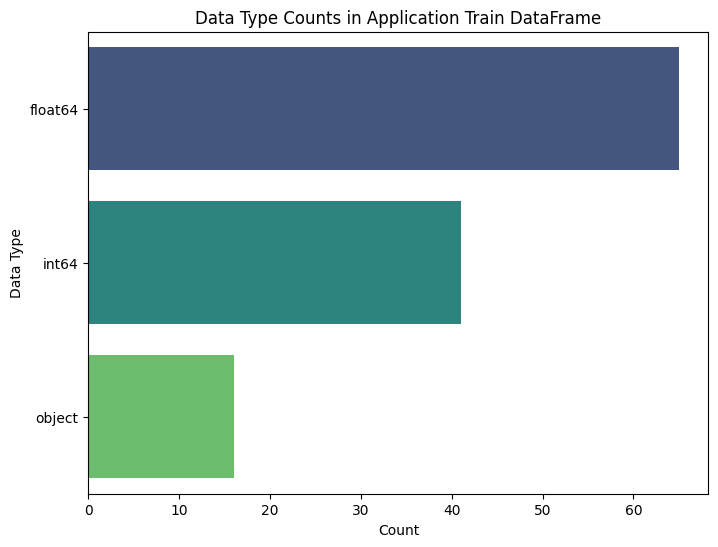

Summary of Application Train DataFrame Data Types:


Column Data Type  Null Count  Unique Values
0                    SK_ID_CURR     int64           0         307511
1                        TARGET     int64           0              2
2            NAME_CONTRACT_TYPE    object           0              2
3                   CODE_GENDER    object           0              3
4                  FLAG_OWN_CAR    object           0              2
..                          ...       ...         ...            ...
117   AMT_REQ_CREDIT_BUREAU_DAY   float64       41519              9
118  AMT_REQ_CREDIT_BUREAU_WEEK   float64       41519              9
119   AMT_REQ_CREDIT_BUREAU_MON   float64       41519             24
120   AMT_REQ_CREDIT_BUREAU_QRT   float64       41519             11
121  AMT_REQ_CREDIT_BUREAU_YEAR   float64       41519             25

[122 rows x 4 columns]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data_types(df, df_name="DataFrame"):
    """
    Visualizes the data types in a DataFrame.
    
    Parameters:
    - df: The DataFrame to analyze.
    - df_name: A name for the DataFrame (used in plot titles).
    """
    # Get the data types and their counts
    data_types = df.dtypes.value_counts()
    
    # Create a summary table
    summary_table = pd.DataFrame({
        'Column': df.columns,
        'Data Type': df.dtypes,
        'Null Count': df.isnull().sum(),
        'Unique Values': df.nunique()
    }).reset_index(drop=True)
    
    # Plot the data type counts
    plt.figure(figsize=(8, 6))
    sns.barplot(x=data_types.values, y=data_types.index, palette="viridis")
    plt.title(f"Data Type Counts in {df_name}")
    plt.xlabel("Count")
    plt.ylabel("Data Type")
    plt.show()
    
    # Display the summary table
    print(f"Summary of {df_name} Data Types:")
    display(summary_table)


visualize_data_types(df, "Application Train DataFrame")


# Analysis of Missing Data <a name="missing_data"></a>

### Defining Functions <a name="defining-functions"></a>

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# creating a group of functions to analyze missing data

def missing_data_summary(df):
    """
    returns a summary of missing data in each column.
    """
    missing_data = df.isnull().sum()
    missing_percent = (missing_data / len(df)) * 100
    return pd.DataFrame({
        'missing values': missing_data,
        'percent missing': missing_percent
    }).sort_values(by='percent missing', ascending=False)


def plot_missing_data(df):
    """
    visualizes missing data using a heatmap.
    """
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('heatmap of missing data')
    plt.show()


def plot_missing_bar(df, threshold=0):
    """
    plots the percentage of missing data for each column.
    only columns with more than `threshold` percent missing data will be plotted.
    """
    missing_percent = df.isnull().mean() * 100
    missing_percent = missing_percent[missing_percent > threshold].sort_values()
    
    plt.figure(figsize=(12, 8))
    missing_percent.plot(kind='barh', color='c')
    plt.title('percentage of missing data')
    plt.xlabel('% missing')
    plt.xticks(rotation=0)
    plt.ylabel('columns')
    plt.show()


def missingness_correlation(df):
    """
    returns a dataframe of correlations between missing data indicators and other variables.
    useful for identifying mar (missing at random) data.
    """
    missing_indicators = df.isnull().astype(int)
    correlations = missing_indicators.corrwith(df.select_dtypes(include=[float, int]), axis=0)
    return correlations.sort_values(ascending=False)


def compare_missing_vs_nonmissing(df, col_missing, col_compare):
    """
    compares the distribution of a variable for missing vs non-missing values in a given column.
    useful for examining mar data.
    """
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col_missing].isnull(), y=df[col_compare])
    plt.title(f'comparison of {col_compare} for missing vs non-missing {col_missing}')
    plt.show()


def check_nmar(df, col_missing, col_categorical):
    """
    checks whether missingness in `col_missing` is related to values in a categorical variable `col_categorical`.
    """
    missing_indicator = df[col_missing].isnull().astype(int)
    grouped_missing = df.groupby(col_categorical)[missing_indicator.name].mean()
    print(grouped_missing)
    
    plt.figure(figsize=(10, 6))
    grouped_missing.plot(kind='bar', color='orange')
    plt.title(f'missingness in {col_missing} across {col_categorical}')
    plt.ylabel('proportion missing')
    plt.show()


# set options for better interpretability of outputs
pd.set_option('display.max_rows', None)  # ensure all rows are displayed
pd.set_option('display.max_columns', None)  # ensure all columns are displayed


In [5]:
missing_data_summary(df)

missing values  percent missing
COMMONAREA_AVG                        214865        69.872297
COMMONAREA_MODE                       214865        69.872297
COMMONAREA_MEDI                       214865        69.872297
NONLIVINGAPARTMENTS_MEDI              213514        69.432963
NONLIVINGAPARTMENTS_MODE              213514        69.432963
NONLIVINGAPARTMENTS_AVG               213514        69.432963
FONDKAPREMONT_MODE                    210295        68.386172
LIVINGAPARTMENTS_AVG                  210199        68.354953
LIVINGAPARTMENTS_MEDI                 210199        68.354953
LIVINGAPARTMENTS_MODE                 210199        68.354953
FLOORSMIN_MODE                        208642        67.848630
FLOORSMIN_AVG                         208642        67.848630
FLOORSMIN_MEDI                        208642        67.848630
YEARS_BUILD_AVG                       204488        66.497784
YEARS_BUILD_MODE                      204488        66.497784
YEARS_BUILD_MEDI                      204488        66.497784
OWN_CAR_AGE                           202929        65.990810
LANDAREA_MEDI                         182590        59.376738
LANDAREA_AVG                          182590        59.376738
LANDAREA_MODE                         182590        59.376738
BASEMENTAREA_MODE                     179943        58.515956
BASEMENTAREA_MEDI                     179943        58.515956
BASEMENTAREA_AVG                      179943        58.515956
EXT_SOURCE_1                          173378        56.381073
NONLIVINGAREA_MODE                    169682        55.179164
NONLIVINGAREA_AVG                     169682        55.179164
NONLIVINGAREA_MEDI                    169682        55.179164
ELEVATORS_AVG                         163891        53.295980
ELEVATORS_MEDI                        163891        53.295980
ELEVATORS_MODE                        163891        53.295980
WALLSMATERIAL_MODE                    156341        50.840783
APARTMENTS_AVG                        156061        50.749729
APARTMENTS_MEDI                       156061        50.749729
APARTMENTS_MODE                       156061        50.749729
ENTRANCES_MODE                        154828        50.348768
ENTRANCES_MEDI                        154828        50.348768
ENTRANCES_AVG                         154828        50.348768
LIVINGAREA_AVG                        154350        50.193326
LIVINGAREA_MEDI                       154350        50.193326
LIVINGAREA_MODE                       154350        50.193326
HOUSETYPE_MODE                        154297        50.176091
FLOORSMAX_MODE                        153020        49.760822
FLOORSMAX_AVG                         153020        49.760822
FLOORSMAX_MEDI                        153020        49.760822
YEARS_BEGINEXPLUATATION_MODE          150007        48.781019
YEARS_BEGINEXPLUATATION_MEDI          150007        48.781019
YEARS_BEGINEXPLUATATION_AVG           150007        48.781019
TOTALAREA_MODE                        148431        48.268517
EMERGENCYSTATE_MODE                   145755        47.398304
OCCUPATION_TYPE                        96391        31.345545
EXT_SOURCE_3                           60965        19.825307
AMT_REQ_CREDIT_BUREAU_HOUR             41519        13.501631
AMT_REQ_CREDIT_BUREAU_WEEK             41519        13.501631
AMT_REQ_CREDIT_BUREAU_MON              41519        13.501631
AMT_REQ_CREDIT_BUREAU_YEAR             41519        13.501631
AMT_REQ_CREDIT_BUREAU_DAY              41519        13.501631
AMT_REQ_CREDIT_BUREAU_QRT              41519        13.501631
NAME_TYPE_SUITE                         1292         0.420148
DEF_60_CNT_SOCIAL_CIRCLE                1021         0.332021
OBS_60_CNT_SOCIAL_CIRCLE                1021         0.332021
DEF_30_CNT_SOCIAL_CIRCLE                1021         0.332021
OBS_30_CNT_SOCIAL_CIRCLE                1021         0.332021
EXT_SOURCE_2                             660         0.214626
AMT_GOODS_PRICE                          278         0.090403


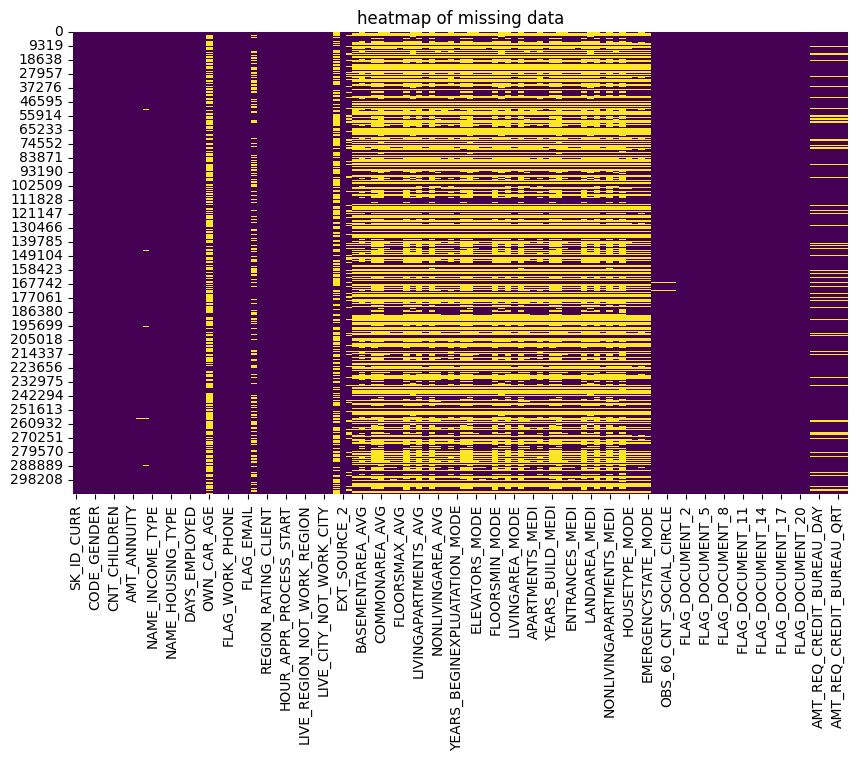

In [6]:
#heatmap of missingness

plot_missing_data(df)


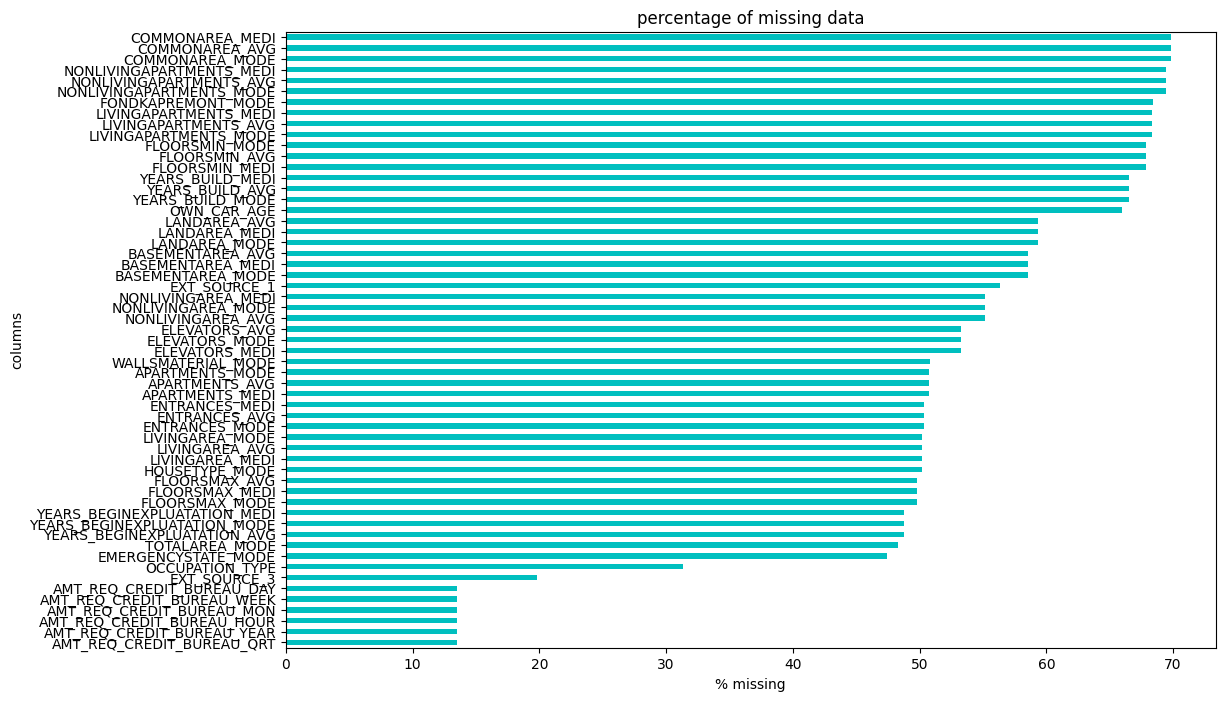

In [7]:
#barplot of missingness
plot_missing_bar(df, 5)

In [ ]:
def missingness_correlation(df):
    """
    returns a dataframe of correlations between missing data indicators and other numerical variables.
    ignores non-numeric columns and handles cases with constant columns or NaNs.
    """
    #create a dataframe with missing indicators (1 if missing, 0 if not)
    missing_indicators = df.isnull().astype(int)
    
    #select only numeric columns from the original dataframe
    numeric_df = df.select_dtypes(include=[float, int])
    
    #fill missing values in numeric columns to ensure correlation calculations are valid
    numeric_df = numeric_df.fillna(0)  # other imputation methods can be applied if needed

    #calculate correlations between missing indicators and numeric features
    correlations = {
        col: missing_indicators.corrwith(numeric_df[col]) for col in numeric_df.columns
    }
    
    return pd.DataFrame(correlations)

missingness_correlation(df)


c:\Users\david\Projects\Credit_Risk_Project\Credit_Risk_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\david\Projects\Credit_Risk_Project\Credit_Risk_venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


SK_ID_CURR    TARGET  CNT_CHILDREN  \
SK_ID_CURR                           NaN       NaN           NaN   
TARGET                               NaN       NaN           NaN   
NAME_CONTRACT_TYPE                   NaN       NaN           NaN   
CODE_GENDER                          NaN       NaN           NaN   
FLAG_OWN_CAR                         NaN       NaN           NaN   
FLAG_OWN_REALTY                      NaN       NaN           NaN   
CNT_CHILDREN                         NaN       NaN           NaN   
AMT_INCOME_TOTAL                     NaN       NaN           NaN   
AMT_CREDIT                           NaN       NaN           NaN   
AMT_ANNUITY                    -0.002206 -0.001851     -0.003608   
AMT_GOODS_PRICE                 0.003624 -0.000573      0.004205   
NAME_TYPE_SUITE                 0.002548 -0.006330      0.000917   
NAME_INCOME_TYPE                     NaN       NaN           NaN   
NAME_EDUCATION_TYPE                  NaN       NaN           NaN   
NAME_FAMILY_STATUS                   NaN       NaN           NaN   
NAME_HOUSING_TYPE                    NaN       NaN           NaN   
REGION_POPULATION_RELATIVE           NaN       NaN           NaN   
DAYS_BIRTH                           NaN       NaN           NaN   
DAYS_EMPLOYED                        NaN       NaN           NaN   
DAYS_REGISTRATION                    NaN       NaN           NaN   
DAYS_ID_PUBLISH                      NaN       NaN           NaN   
OWN_CAR_AGE                    -0.001206  0.021841     -0.102025   
FLAG_MOBIL                           NaN       NaN           NaN   
FLAG_EMP_PHONE                       NaN       NaN           NaN   
FLAG_WORK_PHONE                      NaN       NaN           NaN   
FLAG_CONT_MOBILE                     NaN       NaN           NaN   
FLAG_PHONE                           NaN       NaN           NaN   
FLAG_EMAIL                           NaN       NaN           NaN   
OCCUPATION_TYPE                -0.000591 -0.038690     -0.175988   
CNT_FAM_MEMBERS                -0.001124 -0.000756     -0.001473   
REGION_RATING_CLIENT                 NaN       NaN           NaN   
REGION_RATING_CLIENT_W_CITY          NaN       NaN           NaN   
WEEKDAY_APPR_PROCESS_START           NaN       NaN           NaN   
HOUR_APPR_PROCESS_START              NaN       NaN           NaN   
REG_REGION_NOT_LIVE_REGION           NaN       NaN           NaN   
REG_REGION_NOT_WORK_REGION           NaN       NaN           NaN   
LIVE_REGION_NOT_WORK_REGION          NaN       NaN           NaN   
REG_CITY_NOT_LIVE_CITY               NaN       NaN           NaN   
REG_CITY_NOT_WORK_CITY               NaN       NaN           NaN   
LIVE_CITY_NOT_WORK_CITY              NaN       NaN           NaN   
ORGANIZATION_TYPE                    NaN       NaN           NaN   
EXT_SOURCE_1                    0.000438  0.018641     -0.112907   
EXT_SOURCE_2                   -0.001614 -0.000330      0.000365   
EXT_SOURCE_3                   -0.000257  0.022617     -0.020090   
APARTMENTS_AVG                 -0.001523  0.040266      0.037188   
BASEMENTAREA_AVG               -0.000951  0.036619      0.031921   
YEARS_BEGINEXPLUATATION_AVG    -0.000808  0.040554      0.038175   
YEARS_BUILD_AVG                 0.000180  0.031435      0.027124   
COMMONAREA_AVG                 -0.000624  0.028026      0.024216   
ELEVATORS_AVG                  -0.001411  0.040299      0.038063   
ENTRANCES_AVG                  -0.001137  0.040872      0.037682   
FLOORSMAX_AVG                  -0.000877  0.040847      0.038105   
FLOORSMIN_AVG                   0.000022  0.029765      0.026076   
LANDAREA_AVG                   -0.000870  0.033146      0.029686   
LIVINGAPARTMENTS_AVG           -0.000828  0.029590      0.025302   
LIVINGAREA_AVG                 -0.001401  0.039405      0.037027   
NONLIVINGAPARTMENTS_AVG         0.000233  0.028251      0.025060   
NONLIVINGAREA_AVG              -0.000751  0.039168      0.034888   
APARTMENTS_MODE   

## Analysis of Missingness Correlations

In examining the missing data patterns, we found some interesting correlations that reveal systematic trends, especially around certain types of features. Generative AI helped sift through the massive correlation matrix, identifying key relationships worth highlighting.

1. **Strong Links Among Property-Related Features**  
   - Features like `APARTMENTS_AVG`, `BASEMENTAREA_AVG`, and `YEARS_BEGINEXPLUATATION_AVG` tend to be missing together and are also linked with other related variables, such as `ELEVATORS_AVG` and `COMMONAREA_AVG`.  
   - This pattern suggests that if one property-related field is missing, others are likely missing too. It could mean there’s a systematic reason behind the missing data in real estate fields, possibly indicating that not all applicants or properties have these amenities.

2. **High Correlation Among EXT_SOURCE Variables**  
   - Missing values in the external score variables (`EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`) show a striking pattern. When one of these scores is missing, it’s very likely the others are missing as well.  
   - This might suggest that some clients simply lack external credit scores, leading to gaps across all three EXT_SOURCE variables.

3. **OWN_CAR_AGE and Employment Variables**  
   - There’s a noticeable correlation between missing values in `OWN_CAR_AGE` and fields like `DAYS_EMPLOYED` and `DAYS_BIRTH`. It seems that older applicants or those with longer work histories may have missing data in these fields, hinting at a specific demographic trend rather than random missingness.

### What Do These Patterns Mean?

From this analysis, we’re treating the property-related features (like `APARTMENTS_AVG` and `BASEMENTAREA_AVG`) and external credit scores (`EXT_SOURCE_1`, `EXT_SOURCE_2`, `EXT_SOURCE_3`) as **Not Missing at Random (NMAR)**. The consistent missingness among these fields could be due to practical reasons, such as properties without certain amenities or clients without external scores. 

For the rest of the data, we’ll assume it’s **Missing Completely at Random (MCAR)**, meaning that these gaps don’t follow any noticeable pattern or trend.

### Our Strategy for Handling Missing Data

- **For MCAR data**: We’ll use simple median or mean imputation, as this approach fills in the gaps without biasing the results.
  
- **For NMAR data**: We’ll handle these fields more thoughtfully by:  
   - Adding **flag columns** to indicate where categorical values are missing.  
   - Imputing missing numerical values with the **median** to keep the data balanced without artificially skewing it. We’ll avoid using placeholders like zero or -1 to maintain the integrity of the data.


# Creating Cleaning Pipeline

In [ ]:
### here i'll be creating generic parts of a pipeline to clean the data

# what happens in the pipeline:
# step 1: flag missing values in nmar assumed numericals
# step 2: impute assumed nmar categoricals with 'unknown'
# step 3: cap outliers in the data so scaling isn't distorted significantly by massive outliers, such as billionaire loan applications
# step 4: handle any remaining missing values in numeric columns using the median
# step 5: handle any remaining missing values in categorical columns using the mode

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# flagmissing transformer 
class FlagMissing(BaseEstimator, TransformerMixin):
    """
    flags missing values by creating new columns for each feature, indicating if a value is missing.
    this helps track where data was missing for future analysis.
    """
    def __init__(self, columns_to_flag):
        self.columns_to_flag = columns_to_flag
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()  # avoid modifying original data during transformation
        
        #create a separate dataframe for the flags
        missing_flags = pd.DataFrame()
        
        for col in self.columns_to_flag:
            missing_flags[f'FLAG_{col}'] = np.where(X[col].isnull(), 0, 1)
        
        # concatenate the flags to the original dataframe to avoid fragmentation
        X = pd.concat([X, missing_flags], axis=1)
        
        return X

# custom transformer to impute missing values with specified strategies
class ImputeColumns(BaseEstimator, TransformerMixin):
    """
    imputes missing values using different strategies:
    - median for selected columns
    - 'unknown' for selected categorical columns
    """
    def __init__(self, unknown_columns=None):
        self.unknown_columns = unknown_columns
  
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # impute with 'unknown' for specified categorical columns
        if self.unknown_columns:
            for col in self.unknown_columns:
                X[col].fillna('Unknown', inplace=True)
        
        return X

# custom transformer to cap outliers before scaling, ensuring percentiles are only calculated once
class CapOutliers(BaseEstimator, TransformerMixin):
    """
    caps outliers for numerical columns by setting values above the specified percentiles.
    percentiles are calculated once during fit and applied consistently during transforms.
    """
    def __init__(self, columns_to_cap, lower_percentile=2, upper_percentile=98):
        self.columns_to_cap = columns_to_cap
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile
        self.lower_caps_ = {}
        self.upper_caps_ = {}
    
    def fit(self, X, y=None):
        #calculate and store the caps for each column during fit
        for col in self.columns_to_cap:
            self.lower_caps_[col] = X[col].quantile(self.lower_percentile / 100)
            self.upper_caps_[col] = X[col].quantile(self.upper_percentile / 100)
        return self
    
    def transform(self, X):
        X = X.copy()  # work on a copy to avoid modifying the original dataframe
        
        #apply the pre-calculated caps during transform
        for col in self.columns_to_cap:
            X[col] = X[col].clip(lower=self.lower_caps_[col], upper=self.upper_caps_[col])
        return X

# custom transformer to scale numerical columns
class ScaleNumericFeatures(BaseEstimator, TransformerMixin):
    """
    scales numerical features using standardscaler.
    this ensures that all features are on a similar scale, which helps models converge faster.
    """
    def __init__(self, columns_to_scale):
        self.columns_to_scale = columns_to_scale
        self.scaler = StandardScaler()
    
    def fit(self, X, y=None):
        self.scaler.fit(X[self.columns_to_scale])
        return self
    
    def transform(self, X):
        X = X.copy()
        X[self.columns_to_scale] = self.scaler.transform(X[self.columns_to_scale])
        return X

#custom transformer to impute remaining missing values with median for numeric columns
class ImputeWithMedian(BaseEstimator, TransformerMixin):
    """
    imputes missing values for numeric columns using the median of each column.
    useful for handling the last few missing values in numeric columns.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X.select_dtypes(include=['float64', 'int64']).columns:
            if X[col].isnull().sum() > 0:
                X[col].fillna(X[col].median(), inplace=True)
        return X

#custom transformer to impute remaining missing values with mode for non-numeric columns
class ImputeWithMode(BaseEstimator, TransformerMixin):
    """
    imputes missing values for non-numeric columns using the most frequent value (mode).
    useful for categorical data.
    """
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X.select_dtypes(exclude=['float64', 'int64']).columns:
            if X[col].isnull().sum() > 0:
                X[col].fillna(X[col].mode()[0], inplace=True)
        return X


# bringing together a pipeline for this dataset

# columns suspected to have nmar (not missing at random) missingness patterns
flag_cols = [
    'COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAPARTMENTS_MEDI',
    'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI',
    'FLOORSMIN_AVG', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI',
    'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE', 'YEARS_BUILD_AVG',
    'LANDAREA_MEDI', 'LANDAREA_MODE', 'LANDAREA_AVG',
    'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MODE',
    'NONLIVINGAREA_MODE', 'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI',
    'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'ELEVATORS_MODE',
    'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE',
    'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE',
    'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI',
    'HOUSETYPE_MODE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'FLOORSMAX_AVG',
    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BEGINEXPLUATATION_AVG',
    'TOTALAREA_MODE',
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'
]

# columns where missing values should be imputed with 'unknown' for categorical consistency
unknown_columns = ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE']


def get_columns_to_scale(df):
    """
    returns a list of columns that should be scaled, i.e., continuous numeric columns
    excluding binary and id columns.
    
    parameters:
    - df: the dataframe to select columns from.
    
    returns:
    - a list of columns to scale.
    """
    #select numeric columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    #exclude id columns
    numeric_cols = [col for col in numeric_cols if col != 'SK_ID_CURR']
    
    #exclude binary columns (those with only two unique values)
    columns_to_scale = [
        col for col in numeric_cols if df[col].nunique() > 2
    ]
    
    return columns_to_scale


# function to get all categorical columns
def get_cat_columns(df):
    """
    select only non-numeric columns (object and category).
    
    parameters:
    - df: the dataframe to select columns from.
    
    returns:
    - a list of categorical columns in the dataframe
    """
    # select only non-numeric columns (object and category)
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    return cat_cols

numerical_cols = get_columns_to_scale(df)




# Create the pipeline that chains all the transformations together
application_pipeline = Pipeline(steps=[
    ('flag_missing', FlagMissing(columns_to_flag=flag_cols)),
    ('unknowns', ImputeColumns( unknown_columns=unknown_columns)),
    ('cap_outliers', CapOutliers(columns_to_cap=numerical_cols)),  # Cap outliers
    ('mean_impute', ImputeWithMedian()),   # Impute remaining numeric columns with median
    ('mode_impute', ImputeWithMode())    # Impute remaining non-numeric columns with mode
])


#fit the pipeline
application_pipeline.fit(df)
#transform df
df_transformed = application_pipeline.transform(df)
#checking for missingvalues
df_transformed.isnull().sum()



C:\Users\david\AppData\Local\Temp\ipykernel_4388\1006957539.py:61: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna('Unknown', inplace=True)
C:\Users\david\AppData\Local\Temp\ipykernel_4388\1006957539.py:125: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

SK_ID_CURR                           0
TARGET                               0
NAME_CONTRACT_TYPE                   0
CODE_GENDER                          0
FLAG_OWN_CAR                         0
FLAG_OWN_REALTY                      0
CNT_CHILDREN                         0
AMT_INCOME_TOTAL                     0
AMT_CREDIT                           0
AMT_ANNUITY                          0
AMT_GOODS_PRICE                      0
NAME_TYPE_SUITE                      0
NAME_INCOME_TYPE                     0
NAME_EDUCATION_TYPE                  0
NAME_FAMILY_STATUS                   0
NAME_HOUSING_TYPE                    0
REGION_POPULATION_RELATIVE           0
DAYS_BIRTH                           0
DAYS_EMPLOYED                        0
DAYS_REGISTRATION                    0
DAYS_ID_PUBLISH                      0
OWN_CAR_AGE                          0
FLAG_MOBIL                           0
FLAG_EMP_PHONE                       0
FLAG_WORK_PHONE                      0
FLAG_CONT_MOBILE         

# Dataset Reduction

**Feature Selection and Dataset Reduction**

In this step, we reduce the dataset by eliminating features that exhibit high multicollinearity.
High multicollinearity means that certain features are highly correlated and provide redundant
information. Removing such features helps improve the efficiency of the model and ensures that 
the remaining features convey unique, valuable insights. This also simplifies feature engineering 
by focusing on the most important and informative features for further analysis and model building.


In [10]:
import numpy as np

def check_multicollinearity(df, columns, threshold=0.9):
    """
    checks for multicollinearity within specified columns by calculating the correlation matrix
    and identifying feature pairs with correlations above a defined threshold.
    
    parameters:
    - df (pd.DataFrame): dataframe containing the dataset.
    - columns (list): list of column names to examine for multicollinearity (typically numeric columns).
    - threshold (float): correlation threshold above which multicollinearity is flagged (default is 0.9).
    
    returns:
    - pd.DataFrame: dataframe listing pairs of features with high correlation.
    """
    # subset the dataframe to include only specified columns
    df_subset = df[columns]
    
    # calculate absolute correlation matrix for the subset
    corr_matrix = df_subset.corr().abs()

    # select the upper triangle of the correlation matrix to avoid duplicate pairs
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # identify pairs of columns with correlations above the threshold
    high_corr_pairs = [
        (column, idx) for column in upper_triangle.columns 
        for idx in upper_triangle.index if upper_triangle.loc[idx, column] > threshold
    ]

    # create a dataframe containing highly correlated feature pairs
    high_corr_df = pd.DataFrame(high_corr_pairs, columns=['feature 1', 'feature 2'])

    return high_corr_df

high_corr_features = check_multicollinearity(df_transformed, numerical_cols, threshold=0.8)
high_corr_features


feature 1                     feature 2
0                AMT_GOODS_PRICE                    AMT_CREDIT
1                CNT_FAM_MEMBERS                  CNT_CHILDREN
2    REGION_RATING_CLIENT_W_CITY          REGION_RATING_CLIENT
3                  ELEVATORS_AVG                APARTMENTS_AVG
4                 LIVINGAREA_AVG                APARTMENTS_AVG
5                 LIVINGAREA_AVG                 ELEVATORS_AVG
6                APARTMENTS_MODE                APARTMENTS_AVG
7                APARTMENTS_MODE                LIVINGAREA_AVG
8              BASEMENTAREA_MODE              BASEMENTAREA_AVG
9   YEARS_BEGINEXPLUATATION_MODE   YEARS_BEGINEXPLUATATION_AVG
10              YEARS_BUILD_MODE               YEARS_BUILD_AVG
11               COMMONAREA_MODE                COMMONAREA_AVG
12                ELEVATORS_MODE                APARTMENTS_AVG
13                ELEVATORS_MODE                 ELEVATORS_AVG
14                ELEVATORS_MODE                LIVINGAREA_AVG
15                ELEVATORS_MODE               APARTMENTS_MODE
16                ENTRANCES_MODE                 ENTRANCES_AVG
17                FLOORSMAX_MODE                 FLOORSMAX_AVG
18                FLOORSMIN_MODE                 FLOORSMIN_AVG
19                 LANDAREA_MODE                  LANDAREA_AVG
20         LIVINGAPARTMENTS_MODE          LIVINGAPARTMENTS_AVG
21               LIVINGAREA_MODE                APARTMENTS_AVG
22               LIVINGAREA_MODE                 ELEVATORS_AVG
23               LIVINGAREA_MODE                LIVINGAREA_AVG
24               LIVINGAREA_MODE               APARTMENTS_MODE
25               LIVINGAREA_MODE                ELEVATORS_MODE
26      NONLIVINGAPARTMENTS_MODE       NONLIVINGAPARTMENTS_AVG
27            NONLIVINGAREA_MODE             NONLIVINGAREA_AVG
28               APARTMENTS_MEDI                APARTMENTS_AVG
29               APARTMENTS_MEDI                 ELEVATORS_AVG
30               APARTMENTS_MEDI                LIVINGAREA_AVG
31               APARTMENTS_MEDI               APARTMENTS_MODE
32               APARTMENTS_MEDI                ELEVATORS_MODE
33               APARTMENTS_MEDI               LIVINGAREA_MODE
34             BASEMENTAREA_MEDI              BASEMENTAREA_AVG
35             BASEMENTAREA_MEDI             BASEMENTAREA_MODE
36  YEARS_BEGINEXPLUATATION_MEDI   YEARS_BEGINEXPLUATATION_AVG
37  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BEGINEXPLUATATION_MODE
38              YEARS_BUILD_MEDI               YEARS_BUILD_AVG
39              YEARS_BUILD_MEDI              YEARS_BUILD_MODE
40               COMMONAREA_MEDI                COMMONAREA_AVG
41               COMMONAREA_MEDI               COMMONAREA_MODE
42                ELEVATORS_MEDI                APARTMENTS_AVG
43                ELEVATORS_MEDI                 ELEVATORS_AVG
44                ELEVATORS_MEDI                LIVINGAREA_AVG
45                ELEVATORS_MEDI                ELEVATORS_MODE
46                ELEVATORS_MEDI               LIVINGAREA_MODE
47                ELEVATORS_MEDI               APARTMENTS_MEDI
48                ENTRANCES_MEDI                 ENTRANCES_AVG
49                ENTRANCES_MEDI                ENTRANCES_MODE
50                FLOORSMAX_MEDI                 FLOORSMAX_AVG
51                FLOORSMAX_MEDI                FLOORSMAX_MODE
52                FLOORSMIN_MEDI                 FLOORSMIN_AVG
53                FLOORSMIN_MEDI                FLOORSMIN_MODE
54                 LANDAREA_MEDI                  LANDAREA_AVG
55                 LANDAREA_MEDI                 LANDAREA_MODE
56         LIVINGAPARTMENTS_MEDI          LIVINGAPARTMENTS_AVG
57         LIVINGAPARTMENTS_MEDI         LIVINGAPARTMENTS_MODE
58               LIVINGAREA_MEDI                APARTMENTS_AVG
59               LIVINGAREA_MEDI                 ELEVATORS_AVG
60               LIVINGAREA_MEDI                LIVINGAREA_AVG
61               LIVINGAREA_MEDI               APARTMENTS_MODE
62               LIVINGAREA_MEDI                ELEVAT

In [ ]:
"""
pairs of high multi-collinearity columns are displayed above. one immediate observation is that property descriptors like 
'apartments_mode', 'apartments_medi', and 'apartments_avg' convey very similar information. with a threshold set at 0.8, 
these descriptors still appear as correlated pairs; even with a threshold of 0.95, property features remain highly correlated.
to streamline exploratory data analysis (eda), only '_avg' columns will be retained, as they provide a single representation 
of each property descriptor.
"""

def drop_medi_mode_columns(df):
    """
    drops columns ending with '_medi' or '_mode' from the dataframe to reduce multicollinearity among property descriptors.
    
    parameters:
    - df (pd.DataFrame): the dataframe from which to drop columns.
    
    returns:
    - pd.DataFrame: a dataframe with '_medi' and '_mode' columns removed.
    """
    # identify columns to drop
    columns_to_drop = [col for col in df.columns if col.endswith('_medi') or col.endswith('_mode')]
    
    #drop the identified columns
    df_cleaned = df.drop(columns=columns_to_drop)
    
    return df_cleaned

df_transformed = drop_medi_mode_columns(df_transformed)
df_transformed.shape


(307511, 169)

# Understanding the Target

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2070252407.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_percentage.index, y=target_percentage.values, palette=target_colors)


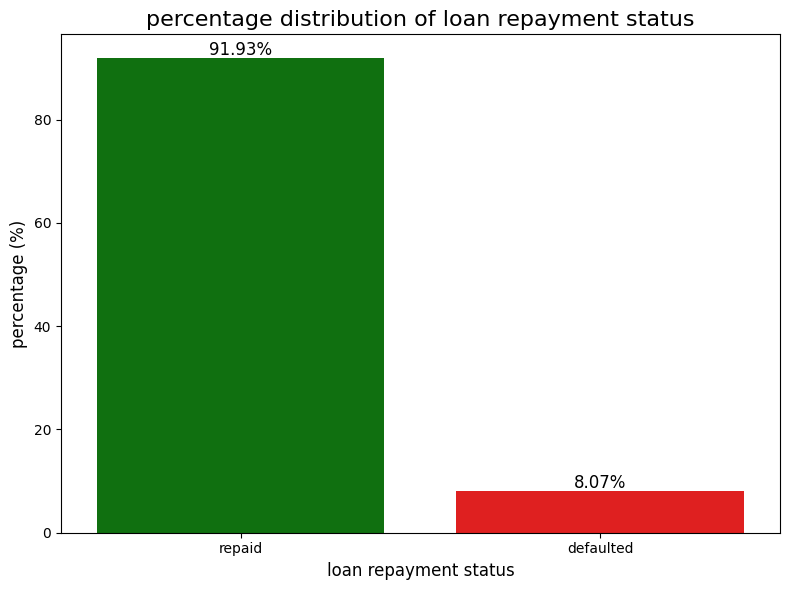

In [ ]:
#analyze the distribution of the target variable

# labels and colors for the target categories
target_labels = ['repaid', 'defaulted']
target_colors = ['green', 'red']

#calculate the percentage distribution of the target variable
target_counts = df_transformed['TARGET'].value_counts(normalize=True) * 100
target_percentage = target_counts.sort_index()

#create a bar plot to visualize the percentage distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=target_percentage.index, y=target_percentage.values, palette=target_colors)

#add titles and labels for clarity
plt.title('percentage distribution of loan repayment status', fontsize=16)
plt.xlabel('loan repayment status', fontsize=12)
plt.ylabel('percentage (%)', fontsize=12)
plt.xticks(ticks=[0, 1], labels=target_labels)

#add percentage labels on top of the bars
for i, v in enumerate(target_percentage.values):
    plt.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontsize=12)

#display the plot
plt.tight_layout()
plt.show()


## Handling an Imbalanced Dataset

The target variable—whether a client defaults on their loan—is highly imbalanced, with far fewer defaults than non-defaults. This imbalance can cause models to favor predicting non-defaults. To address it, we will:

- Use resampling techniques, such as oversampling defaults and/or undersampling non-defaults.
- Consider models with class weighting to penalize misclassified defaults more heavily.
- Focus on performance metrics like Precision, Recall, F1-Score, and ROC-AUC instead of accuracy alone to better evaluate default prediction.

These approaches will help create a model that effectively identifies clients at risk of defaulting, even with imbalanced data.


# Analysis of Numerical Features

- **Financial Information**
  - `AMT_INCOME_TOTAL`: Total income of the applicant.
  - `AMT_CREDIT`: Total amount of credit requested.
  - `AMT_ANNUITY`: Annuity payment amount.
  - `AMT_GOODS_PRICE`: Price of the goods for which the loan is requested.

- **Binned Discrete Information**
  - `AMT_REQ_CREDIT_BUREAU_HOUR`: Number of credit bureau inquiries in the last hour.
  - `AMT_REQ_CREDIT_BUREAU_DAY`: Number of credit bureau inquiries in the last day.
  - `AMT_REQ_CREDIT_BUREAU_WEEK`: Number of credit bureau inquiries in the last week.
  - `AMT_REQ_CREDIT_BUREAU_MON`: Number of credit bureau inquiries in the last month.
  - `AMT_REQ_CREDIT_BUREAU_QRT`: Number of credit bureau inquiries in the last quarter.
  - `AMT_REQ_CREDIT_BUREAU_YEAR`: Number of credit bureau inquiries in the last year.
  
  - `OBS_30_CNT_SOCIAL_CIRCLE`: Number of 30-day observations of the applicant’s social circle.
  - `DEF_30_CNT_SOCIAL_CIRCLE`: Number of 30-day defaults in the applicant’s social circle.
  - `OBS_60_CNT_SOCIAL_CIRCLE`: Number of 60-day observations of the applicant’s social circle.
  - `DEF_60_CNT_SOCIAL_CIRCLE`: Number of 60-day defaults in the applicant’s social circle.



- **Demographic Information**
  - `REGION_POPULATION_RELATIVE`: Population of the applicant's region relative to the national average.
  - `CNT_CHILDREN`: Number of children the applicant has.
  - `CNT_FAM_MEMBERS`: Number of family members.

- **Time-Based Information**
  - `DAYS_BIRTH`: Age of the applicant (in days, negative since birth).
  - `DAYS_EMPLOYED`: Number of days the applicant has been employed.
  - `DAYS_REGISTRATION`: Number of days since the applicant registered their current address.
  - `DAYS_ID_PUBLISH`: Number of days since the applicant's ID was published.
  - `DAYS_LAST_PHONE_CHANGE`: Number of days since the applicant last changed their phone.
  - `OWN_CAR_AGE`: Age of the applicant's car

- **External Risk Scores**
  - `EXT_SOURCE_1`: External credit score or risk score 1.
  - `EXT_SOURCE_2`: External credit score or risk score 2.
  - `EXT_SOURCE_3`: External credit score or risk score 3.

- **Property and Housing Information**
  - `APARTMENTS_AVG`: Average apartment information.
  - `BASEMENTAREA_AVG`: Average basement area.
  - `YEARS_BEGINEXPLUATATION_AVG`: Average year of the building's exploitation.
  - `YEARS_BUILD_AVG`: Average year of the building's construction.
  - `COMMONAREA_AVG`: Average common area.
  - `ELEVATORS_AVG`: Average number of elevators..
  - `ENTRANCES_AVG`: Average number of entrances.
  - `FLOORSMAX_AVG`: Maximum floors in the building (average).
  - `FLOORSMIN_AVG`: Minimum floors in the building (average).
  - `LANDAREA_AVG`: Average land area.
  - `LIVINGAPARTMENTS_AVG`: Average number of living apartments.
  - `LIVINGAREA_AVG`: Average living area.
  - `NONLIVINGAPARTMENTS_AVG`: Average number of non-living apartments.
  - `NONLIVINGAREA_AVG`: Average non-living area.






In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import jarque_bera, skew, kurtosis, ttest_ind

def segment_analysis(df, feature, target='TARGET', bins=4, ax=None):
    
    
    #define custom labels based on the number of bins
    bin_labels = {
        4: ['0-25%', '25-50%', '50-75%', '75-100%'],
        #add more options for different bin counts if needed
    }
    
    # Create quantile bins for the feature
    df['bin'] = pd.qcut(df[feature], bins, labels=bin_labels.get(bins, [f'Q{i}' for i in range(1, bins+1)]))
    
    #group by income_bin and calculate default rates (mean of target) and count per bin
    groups = df.groupby('bin').agg({
        target: ['mean', 'count']  # Default rate and count per bin
    }).reset_index()

    #rename columns for better readability
    groups.columns = ['income_bin', 'default_rate', 'count']
    
    #plot the default rate across income segments (quantiles) in the provided axis
    sns.barplot(x='income_bin', y='default_rate', data=groups, ax=ax)
    ax.set_title(f'Default Rate Across {feature} Segments (Quantiles)')
    ax.set_ylabel('Default Rate')
    ax.set_xlabel(f'{feature} Segments (Percentiles)')
    
    return groups

#function to plot histogram and boxplot with percentile filtering
def plot_histogram_and_boxplot(df, column_name, percentile=100):
    if column_name in df.columns and pd.api.types.is_numeric_dtype(df[column_name]):
        # Filter out extreme values above a given percentile
        threshold = np.percentile(df[column_name], percentile)
        filtered_data = df[df[column_name] <= threshold]
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
        
        #histogram
        axes[0].hist(filtered_data[column_name], bins=30, edgecolor='k', alpha=0.7)
        axes[0].set_title(f'Histogram of {column_name} (<= {percentile}th Percentile)')
        axes[0].set_xlabel(column_name)
        axes[0].set_ylabel('Frequency')
        axes[0].grid(True)
        
        # Boxplot with outliers still shown
        axes[1].boxplot(filtered_data[column_name], vert=False, showfliers=True)
        axes[1].set_title(f'Boxplot of {column_name} (With Outliers)')
        axes[1].set_xlabel(column_name)
        
        plt.tight_layout()
        plt.show()
    else:
        print(f"{column_name} is either not a column in the dataframe or not numeric.")

#function to assess normality using Jarque-Bera test, skewness, and kurtosis
def assess_normality(df, column_name, percentile=100):
    if column_name in df.columns and pd.api.types.is_numeric_dtype(df[column_name]):
        #filter the data to exclude values above a given percentile
        threshold = np.percentile(df[column_name], percentile)
        filtered_data = df[df[column_name] <= threshold][column_name].dropna()
        
        #jarque-Bera test
        jb_stat, jb_pvalue = jarque_bera(filtered_data)
        
        #descriptive statistics
        skewness = skew(filtered_data)
        kurt_value = kurtosis(filtered_data, fisher=False)
        
        #display results
        print(f"Normality Assessment for {column_name} (<= {percentile}th Percentile):")
        print(f"Jarque-Bera Statistic: {jb_stat:.4f}, p-value: {jb_pvalue:.4f}")
        print(f"Skewness: {skewness:.4f}")
        print(f"Kurtosis: {kurt_value:.4f}")
        
        if jb_pvalue < 0.05:
            print("Conclusion: The data is likely not normally distributed (reject null hypothesis). \n")
        else:
            print("Conclusion: The data appears to be normally distributed (fail to reject null hypothesis). \n")
    else:
        print(f"{column_name} is either not a column in the dataframe or not numeric.")

#bivariate analysis with custom colors and subplotting
def bivariate_analysis(df, numerical_feature, target, percentile=100, ax=None):
    if numerical_feature in df.columns and pd.api.types.is_numeric_dtype(df[numerical_feature]):
        #filter the data to exclude values above a given percentile
        threshold = np.percentile(df[numerical_feature], percentile)
        filtered_df = df[df[numerical_feature] <= threshold]
        
        #ensure target column is of type string to match palette keys
        filtered_df[target] = filtered_df[target].astype(str)
        
        #custom color palette: green for non-defaulters (target='0'), red for defaulters (target='1')
        palette = {'0': 'green', '1': 'red'}
        
        #boxplot to visualize the relationship with custom colors
        sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)
        ax.set_title(f"Bivariate Analysis of {numerical_feature} vs Defaulter/Non-Defaulter")
        
        #group means
        group_0 = filtered_df[filtered_df[target] == '0'][numerical_feature]
        group_1 = filtered_df[filtered_df[target] == '1'][numerical_feature]
        
        #t-test to check if means are significantly different
        t_stat, p_value = ttest_ind(group_0, group_1, nan_policy='omit')
        
        print(f"Percentile limit: {percentile}th")
        print(f"Mean for target=0 (Non-Defaulter): {group_0.mean()}")
        print(f"Mean for target=1 (Defaulter): {group_1.mean()}")
        print(f"t-statistic: {t_stat}, p-value: {p_value}")
        
        if p_value < 0.05:
            print("There is a significant difference between the groups. \n")
        else:
            print("No significant difference between the groups. \n")
    else:
        print(f"{numerical_feature} is either not a column in the dataframe or not numeric.")

def bivariate_analysis(df, numerical_feature, target, percentile=100, ax=None):
    if numerical_feature in df.columns and pd.api.types.is_numeric_dtype(df[numerical_feature]):
        # Filter the data to exclude values above a given percentile
        threshold = np.percentile(df[numerical_feature], percentile)
        filtered_df = df[df[numerical_feature] <= threshold]
        
        # Convert target column values to integer strings to match the palette keys
        filtered_df[target] = filtered_df[target].astype(int).astype(str)
        
        # Custom color palette: green for non-defaulters ('0'), red for defaulters ('1')
        palette = {'0': 'green', '1': 'red'}
        
        # Boxplot to visualize the relationship with custom colors
        sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)
        ax.set_title(f"Bivariate Analysis of {numerical_feature} vs Defaulter/Non-Defaulter")
        
        # Group means
        group_0 = filtered_df[filtered_df[target] == '0'][numerical_feature]
        group_1 = filtered_df[filtered_df[target] == '1'][numerical_feature]
        
        # Perform t-test
        t_stat, p_value = ttest_ind(group_0, group_1, nan_policy='omit')
        
        print(f"Percentile limit: {percentile}th")
        print(f"Mean for target=0 (Non-Defaulter): {group_0.mean()}")
        print(f"Mean for target=1 (Defaulter): {group_1.mean()}")
        print(f"t-statistic: {t_stat}, p-value: {p_value}")
        
        if p_value < 0.05:
            print("There is a significant difference between the groups. \n")
        else:
            print("No significant difference between the groups. \n")
    else:
        print(f"{numerical_feature} is either not a column in the dataframe or not numeric.")



# Comprehensive numerical analysis with side-by-side subplots
def numerical_analysis(df, column, target_column="TARGET", percentile=100):
    """
    Perform a comprehensive numerical analysis on a specified column of a DataFrame.
    """
    # Step 1: Assess normality
    assess_normality(df, column, percentile)
    
    # Step 2: Plot histogram and boxplot
    plot_histogram_and_boxplot(df, column, percentile)
    
    # Create a side-by-side plot for bivariate analysis and segment analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
    
    # Step 3: Perform bivariate analysis and plot on the first axis (left)
    bivariate_analysis(df, column, target_column, percentile, ax=axes[0])
    
    # Step 4: Default rate over quartiles (Segment Analysis) and plot on the second axis (right)
    print(f"\nSegment analysis for {column}:")
    segment_analysis(df, column, target=target_column, ax=axes[1])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()









Normality Assessment for AMT_INCOME_TOTAL (<= 100th Percentile):
Jarque-Bera Statistic: 102431.8161, p-value: 0.0000
Skewness: 1.2170
Kurtosis: 4.4389
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



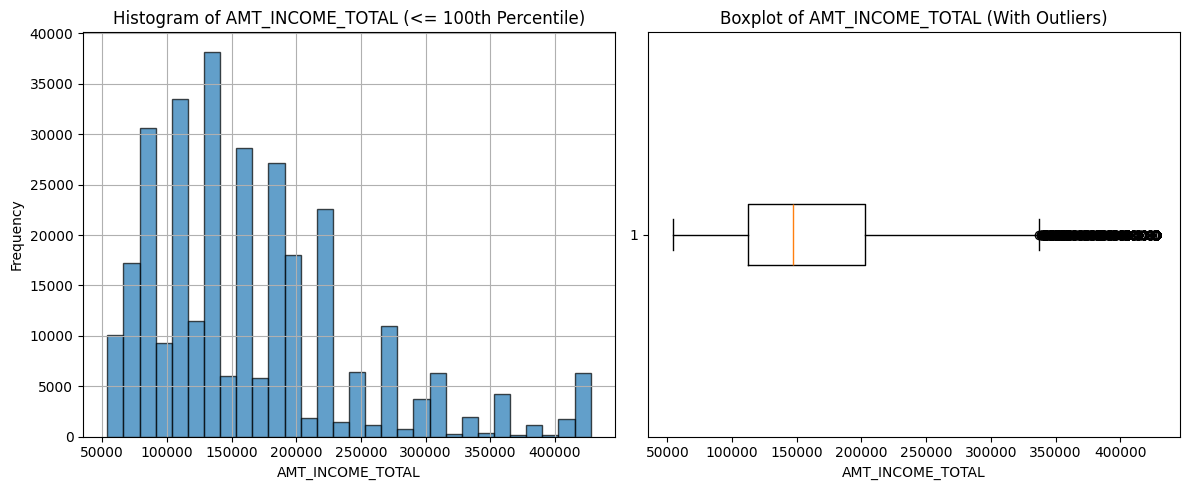

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 166101.40087965087
Mean for target=1 (Defaulter): 159206.11758308156
t-statistic: 12.924351605291962, p-value: 3.3566503693440587e-38
There is a significant difference between the groups. 


Segment analysis for AMT_INCOME_TOTAL:


C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('bin').agg({


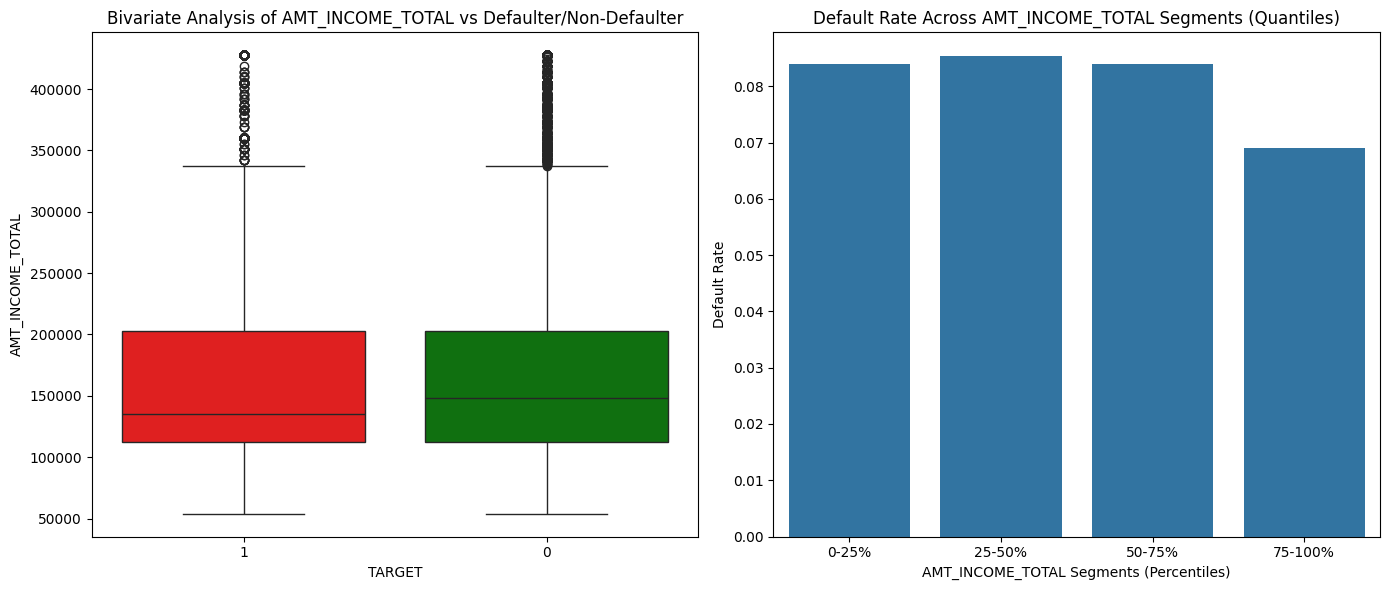

Normality Assessment for AMT_CREDIT (<= 100th Percentile):
Jarque-Bera Statistic: 43655.6746, p-value: 0.0000
Skewness: 0.9184
Kurtosis: 3.1818
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



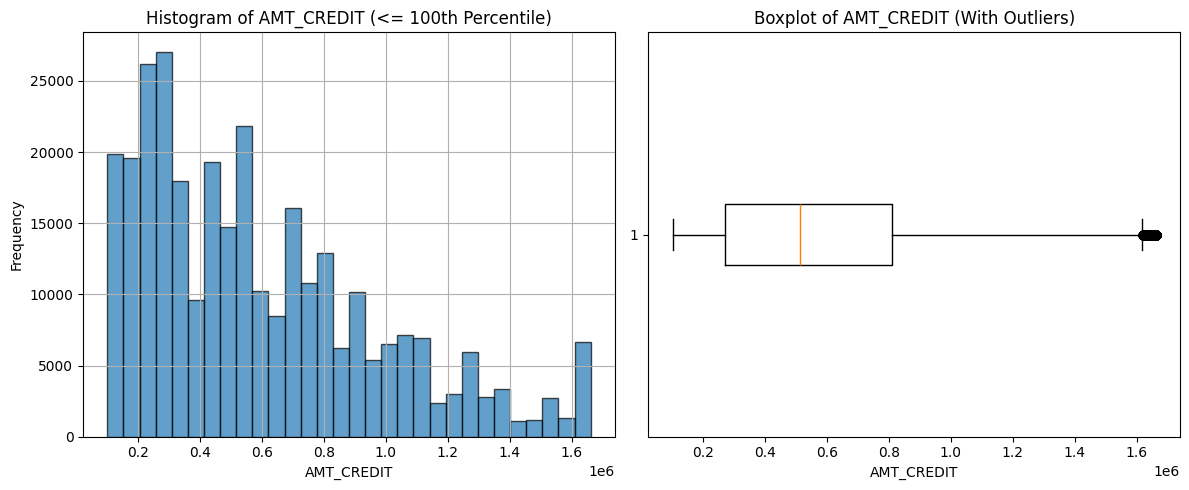

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 597136.7649352993
Mean for target=1 (Defaulter): 555301.4171601208
t-statistic: 16.544649162336803, p-value: 1.8604705045186617e-61
There is a significant difference between the groups. 


Segment analysis for AMT_CREDIT:


C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('bin').agg({


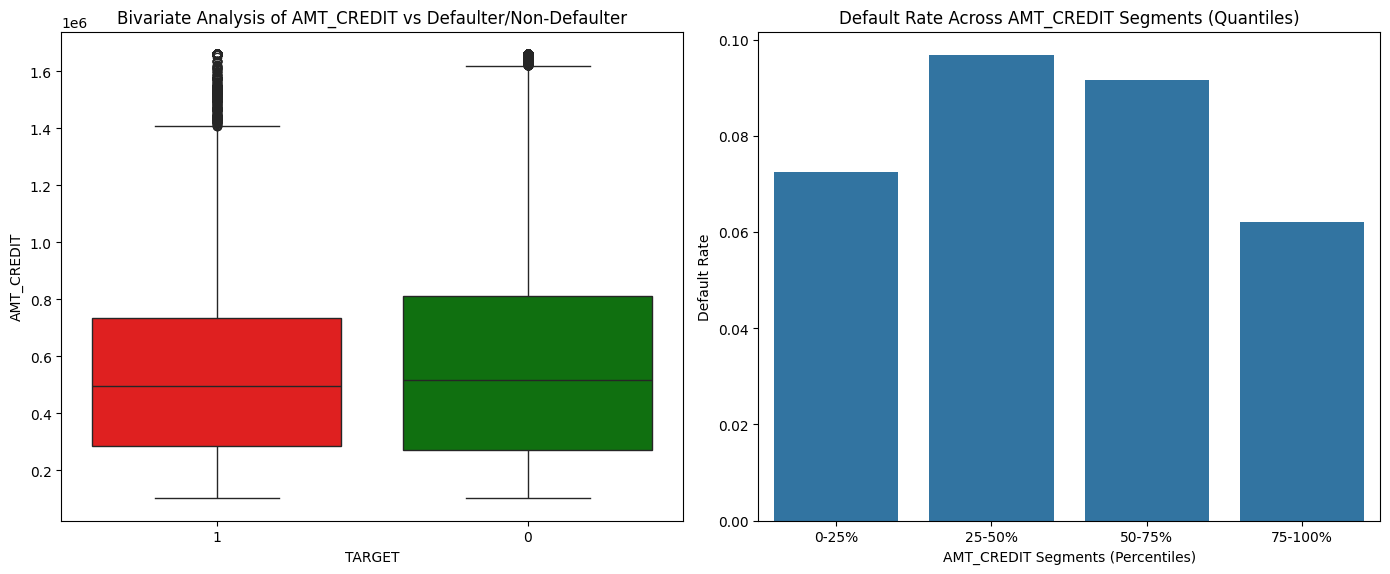

Normality Assessment for AMT_ANNUITY (<= 100th Percentile):
Jarque-Bera Statistic: 28297.9160, p-value: 0.0000
Skewness: 0.7422
Kurtosis: 3.0719
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



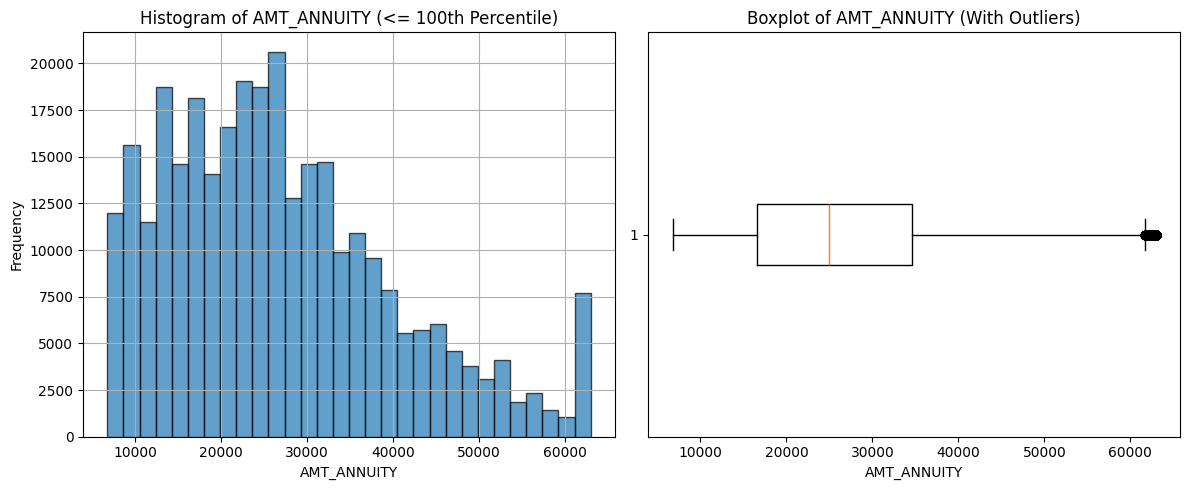

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 26882.603512377693
Mean for target=1 (Defaulter): 26392.83063444109
t-statistic: 5.551097126716409, p-value: 2.8411556675291238e-08
There is a significant difference between the groups. 


Segment analysis for AMT_ANNUITY:


C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('bin').agg({


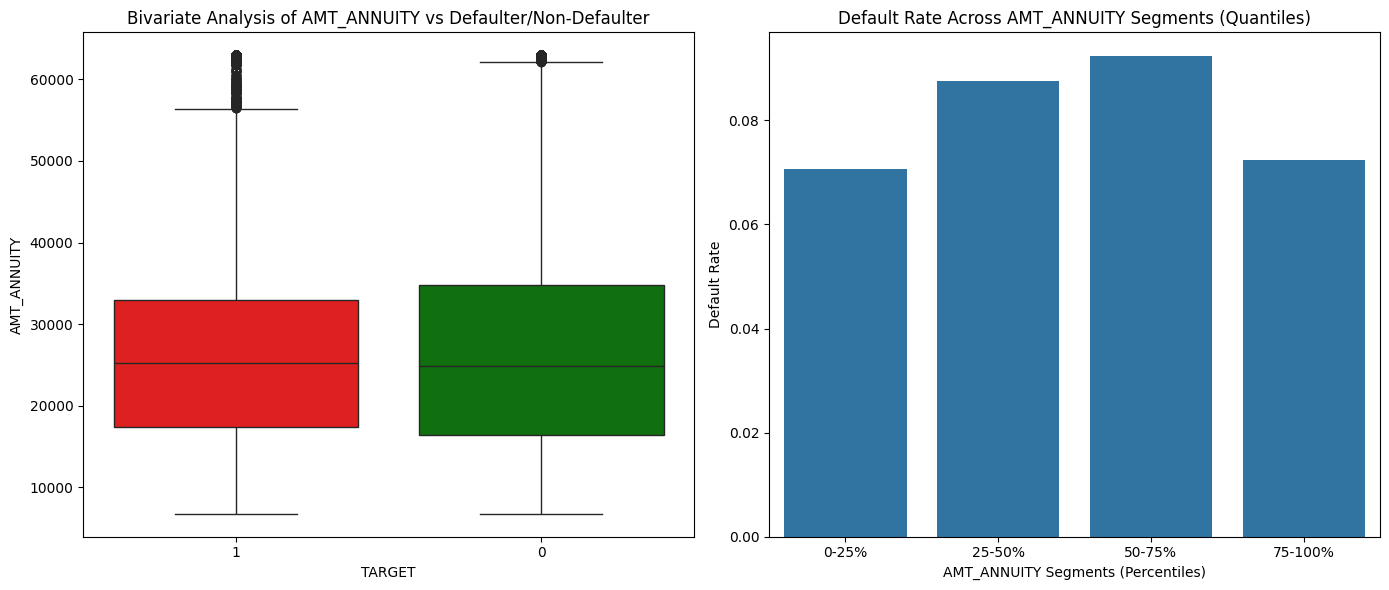

Normality Assessment for AMT_GOODS_PRICE (<= 100th Percentile):
Jarque-Bera Statistic: 58480.8591, p-value: 0.0000
Skewness: 1.0345
Kurtosis: 3.5323
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



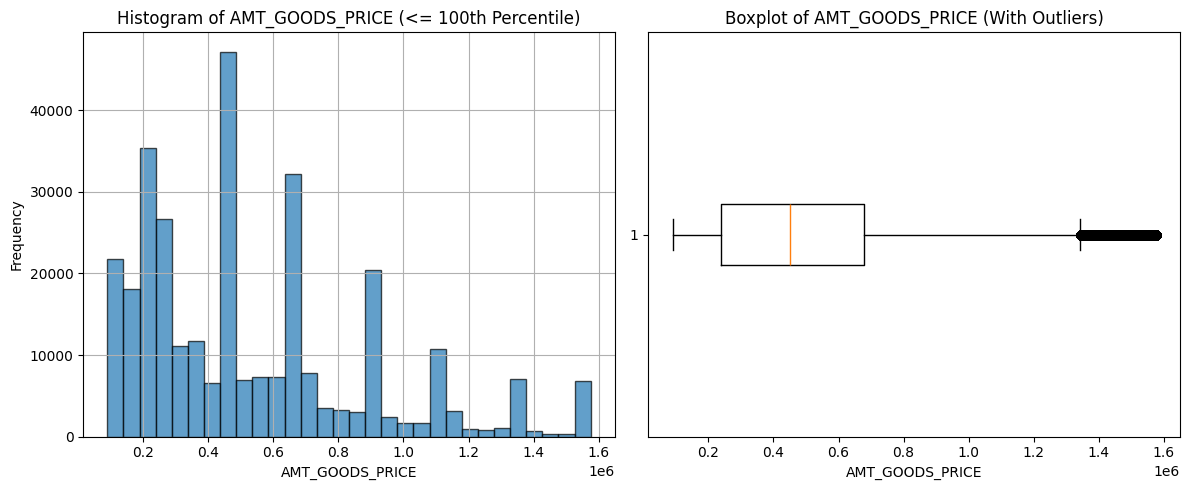

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 538120.0007623299
Mean for target=1 (Defaulter): 487116.42380664655
t-statistic: 21.923390365839058, p-value: 1.8766234433676127e-106
There is a significant difference between the groups. 


Segment analysis for AMT_GOODS_PRICE:


C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = df.groupby('bin').agg({


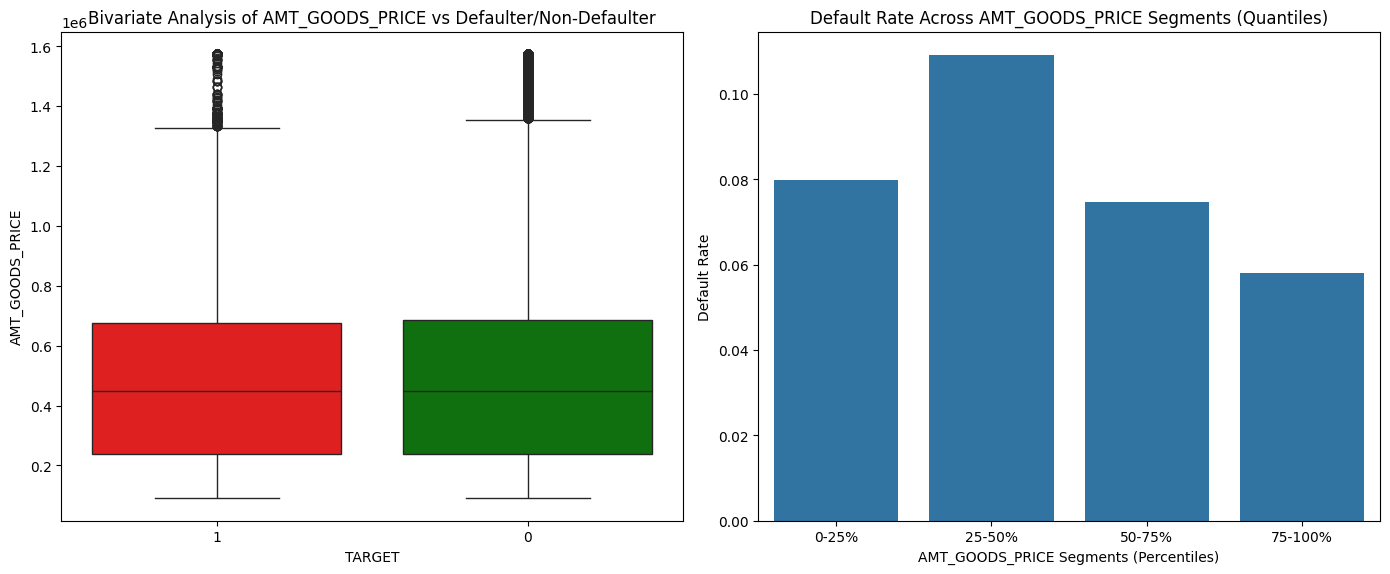

In [14]:
numerical_analysis(df_transformed, "AMT_INCOME_TOTAL")
numerical_analysis(df_transformed, "AMT_CREDIT")
numerical_analysis(df_transformed, "AMT_ANNUITY")
numerical_analysis(df_transformed, "AMT_GOODS_PRICE")


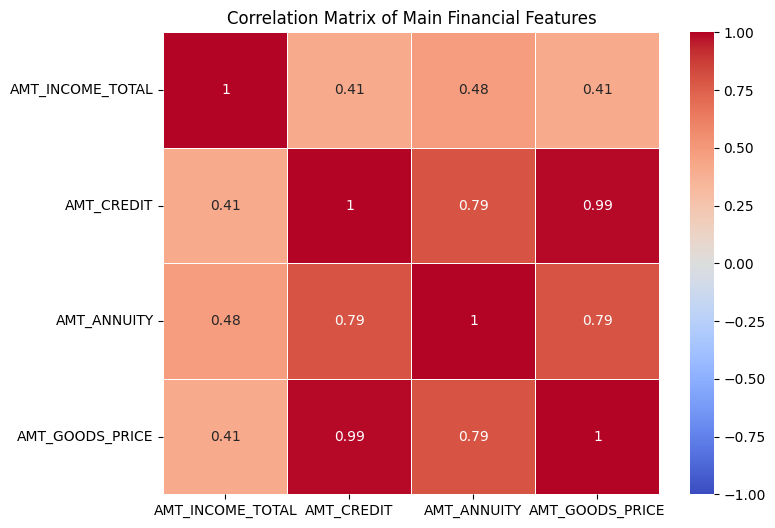

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          9.0           1               1                0   
1             -291          9.0           1               1                0   
2            -2531         26.0           1               1                1   
3            -2437          9.0           1               1                0   
4            -3458          9.0           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   
3                 1           0           0        Laborers              2.0   
4                 1           0           0      Core staff              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                        

In [15]:

financial_features = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'
]

# Correlation matrix for financial features
corr_matrix = df_transformed[financial_features].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix of Main Financial Features")
plt.show()

df_transformed.head()

## Analysis of Key Financial Features

---

#### Overview:
All the financial features analyzed demonstrate statistical significance, and the data is right-skewed, which is common for financial datasets. It is expected that credit, annuity, and goods prices follow similar patterns to income, as individuals tend to make financial decisions based on what they perceive is within their means. This alignment in the distribution of goods prices, credit amounts, and annuities is a reflection of income levels.

---

### Key Insights:

- **AMT_GOODS_PRICE**:
  - Default rates spike in the 25-50% range, suggesting that individuals in this financial bracket may be more susceptible to financial shocks or overextending themselves. This group may lack the financial flexibility to handle unexpected expenses, leading to higher default rates.
  - **Key Takeaway**: Individuals in the 25-50% range may be more vulnerable to financial shocks.

- **AMT_ANNUITY**:
  - Default rates are highest between the 25%-75% range, peaking in the 50%-75% range. This indicates a potential "financial grey zone" where individuals may be overextending themselves. Those in the lowest 25% take on smaller loans, reducing their risk of default, while the highest 25% are typically financially secure enough to manage their annuities.
  - **Key Takeaway**: A "financial grey zone" exists between 50%-75%, where overextension is likely, with higher annuities amplifying the risk of default.

- **AMT_CREDIT**:
  - AMT_CREDIT follows a similar pattern to AMT_GOODS_PRICE, as the amount requested in a loan is closely tied to the price of the financed item. The high correlation between credit and goods prices underscores this relationship.
  - **Key Takeaway**: Default risk patterns for credit amounts align closely with those for goods prices.

- **AMT_INCOME_TOTAL**:
  - Default rates are relatively uniform outside the 75%-100% income range, suggesting that income alone is not the sole determinant of default risk. In the 75%-100% income range, a complex interplay between income, annuity size, and loan size likely influences default risk. While high income can reduce risk, factors such as the income-to-annuity ratio must be considered.
  - **Key Takeaway**: Default risk is most pronounced below the 75% income percentile.

---

### Conclusion:
Income plays a leading role in determining default risk, but the interactions between goods price, credit, and annuity sizes reveal that individuals in the middle-income ranges are more vulnerable to default. There is significant value in exploring the relationship between income, loan amounts, and annuities to better understand default behavior, especially in the context of overextension and financial shocks.


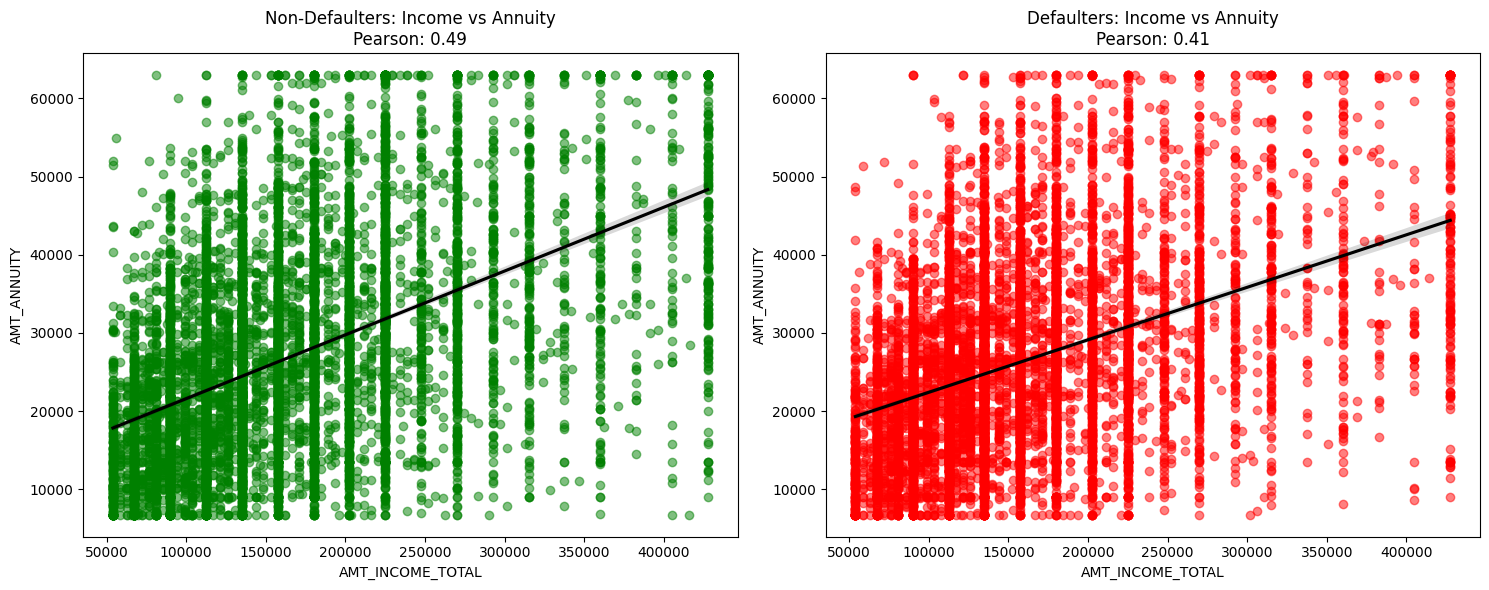

(np.float64(0.4882497202801717), np.float64(0.429092461739574))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

sample_size = 10000

# Randomly sample the same number of defaulters and non-defaulters
non_defaulters_sample = df_transformed[df_transformed['TARGET'] == 0].sample(n=sample_size, random_state=42)
defaulters_sample = df_transformed[df_transformed['TARGET'] == 1].sample(n=sample_size, random_state=42)

# Calculate Pearson correlation for both samples
pearson_non_defaulters, _ = pearsonr(non_defaulters_sample['AMT_INCOME_TOTAL'], non_defaulters_sample['AMT_ANNUITY'])
pearson_defaulters, _ = pearsonr(defaulters_sample['AMT_INCOME_TOTAL'], defaulters_sample['AMT_ANNUITY'])

# Create subplots side by side
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))

# Scatter plot with line of best fit for Non-Defaulters
sns.regplot(x="AMT_INCOME_TOTAL", y="AMT_ANNUITY", data=non_defaulters_sample,
            scatter_kws={'alpha':0.5, 'color':'green'}, line_kws={'color':'black'}, ax=axes[0])
axes[0].set_title(f'Non-Defaulters: Income vs Annuity\nPearson: {pearson_non_defaulters:.2f}')

# Scatter plot with line of best fit for Defaulters
sns.regplot(x="AMT_INCOME_TOTAL", y="AMT_ANNUITY", data=defaulters_sample,
            scatter_kws={'alpha':0.5, 'color':'red'}, line_kws={'color':'black'}, ax=axes[1])
axes[1].set_title(f'Defaulters: Income vs Annuity\nPearson: {pearson_defaulters:.2f}')

# Set labels for both
for ax in axes:
    ax.set_xlabel('AMT_INCOME_TOTAL')
    ax.set_ylabel('AMT_ANNUITY')

plt.tight_layout()
plt.show()

# Pearson correlation for both groups (all members)
non_defaulters_corr, _ = pearsonr(df_transformed[df_transformed['TARGET'] == 0]['AMT_INCOME_TOTAL'], df_transformed[df_transformed['TARGET'] == 0]['AMT_ANNUITY'])
defaulters_corr, _ = pearsonr(df_transformed[df_transformed['TARGET'] == 1]['AMT_INCOME_TOTAL'], df_transformed[df_transformed['TARGET'] == 1]['AMT_ANNUITY'])

non_defaulters_corr, defaulters_corr


### Income vs Annuity: Defaulters vs Non-Defaulters

---

- **Non-Defaulters (Green Plot)**: The correlation between income and annuity is **0.49**, indicating a moderate positive relationship. This suggests that non-defaulters tend to take loans that are proportionate to their income. Higher-income individuals generally have larger annuities, but these remain within a manageable range.

- **Defaulters (Red Plot)**: The correlation is **0.41**, which is weaker than that of non-defaulters. This suggests that defaulters are more likely to take on loans that are **less proportional** to their income, often leading to overextension. Their annuity sizes (loan repayments) do not scale as predictably with their income, making them more vulnerable to financial stress.

---

### Conclusion:
Defaulters tend to take loans that are **larger relative to their income**, which increases their risk of default when facing financial pressures. Non-defaulters, on the other hand, manage their loans more in line with their income, showing greater financial restraint.


## Analysis of Region & Demographic Features

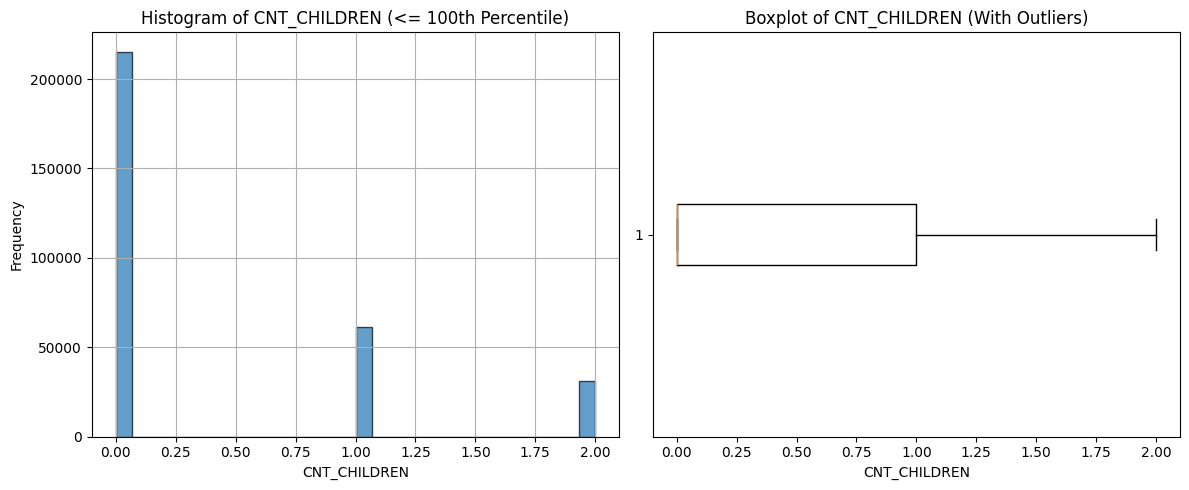

Chi-square test results for CNT_CHILDREN and TARGET:
Chi-square statistic: 126.2860
Degrees of freedom: 2
P-value: 3.7786e-28
Result: Significant association (reject null hypothesis)



C:\Users\david\AppData\Local\Temp\ipykernel_4388\600815862.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discrete_feature, y=target, data=df_percentage, palette='coolwarm')


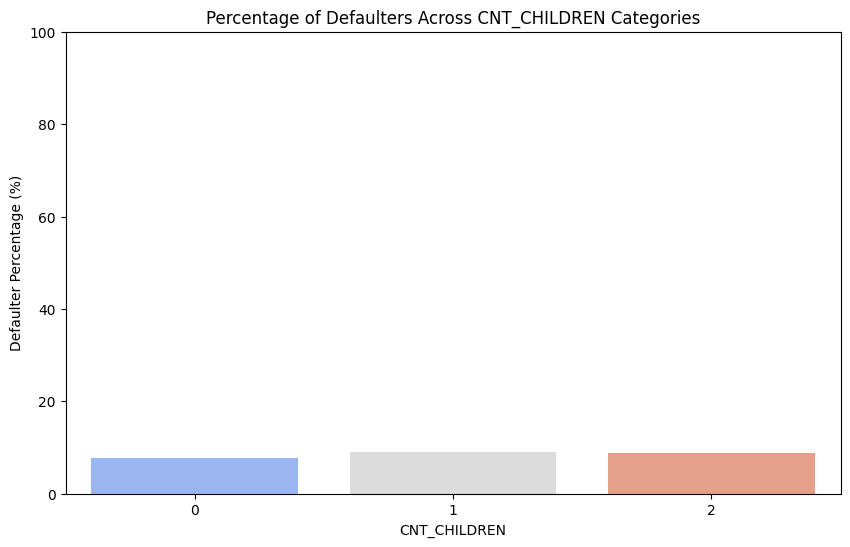

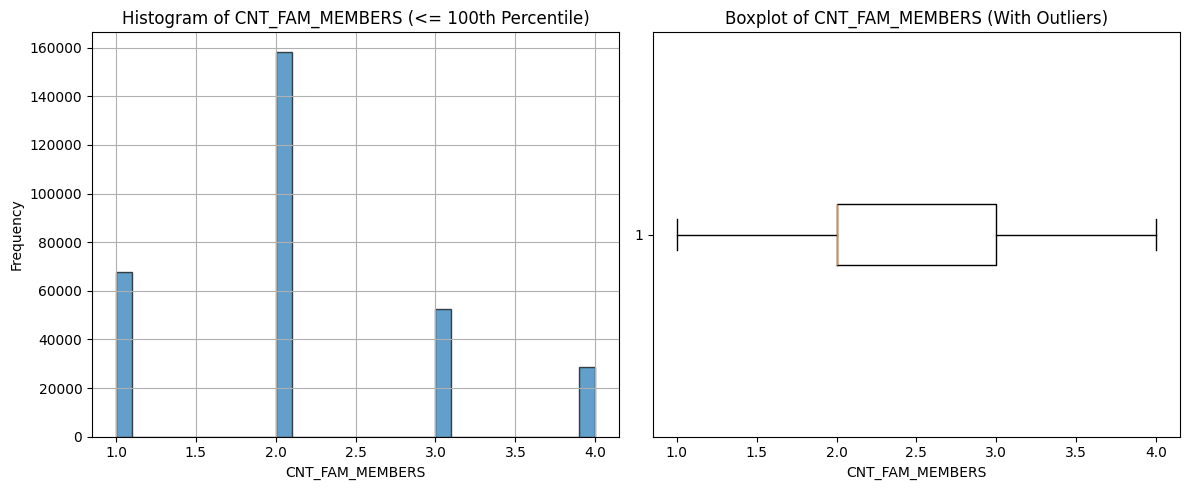

Chi-square test results for CNT_FAM_MEMBERS and TARGET:
Chi-square statistic: 114.2422
Degrees of freedom: 3
P-value: 1.3404e-24
Result: Significant association (reject null hypothesis)



C:\Users\david\AppData\Local\Temp\ipykernel_4388\600815862.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discrete_feature, y=target, data=df_percentage, palette='coolwarm')


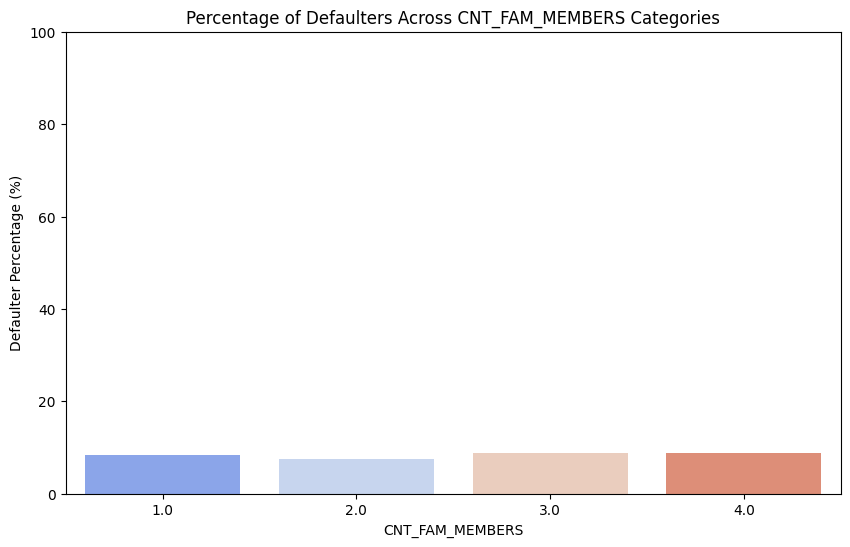

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def plot_defaulter_percentage(df, discrete_feature, target='TARGET'):
    """
    Plots the percentage of defaulters within each category of a discrete variable and performs a chi-square test.
    
    Parameters:
    - df: DataFrame containing the data.
    - discrete_feature: Name of the discrete variable column to analyze.
    - target: Name of the target column indicating defaulter (1) or non-defaulter (0). Default is 'TARGET'.
    """
    # Calculate the percentage of defaulters within each category of the discrete variable
    df_percentage = df.groupby(discrete_feature)[target].mean().reset_index()
    df_percentage[target] *= 100  # Convert to percentage
    
    # Create a contingency table for the chi-square test
    contingency_table = pd.crosstab(df[discrete_feature], df[target])
    
    # Perform the chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Print the results of the chi-square test
    print(f"Chi-square test results for {discrete_feature} and {target}:")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"Degrees of freedom: {dof}")
    print(f"P-value: {p_value:.4e}")
    if p_value < 0.05:
        print("Result: Significant association (reject null hypothesis)\n")
    else:
        print("Result: No significant association (fail to reject null hypothesis)\n")
    
    # Plot the defaulter percentage
    plt.figure(figsize=(10, 6))
    sns.barplot(x=discrete_feature, y=target, data=df_percentage, palette='coolwarm')
    plt.title(f"Percentage of Defaulters Across {discrete_feature} Categories")
    plt.xlabel(discrete_feature)
    plt.ylabel("Defaulter Percentage (%)")
    plt.ylim(0, 100)
    plt.show()

plot_histogram_and_boxplot(df_transformed, "CNT_CHILDREN")
plot_defaulter_percentage(df_transformed, "CNT_CHILDREN")

plot_histogram_and_boxplot(df_transformed, "CNT_FAM_MEMBERS")
plot_defaulter_percentage(df_transformed, "CNT_FAM_MEMBERS", "TARGET")

### Family Members and Default Risk

---

#### **CNT_CHILDREN**

The chi-square test reveals a **significant association** between the number of children (`CNT_CHILDREN`) and the likelihood of default, as indicated by the extremely low p-value. The percentage of defaulters rises slightly with the number of children, though the differences between categories are relatively modest.

**Insights**:
- Individuals with more children (e.g., 2) tend to have a slightly higher default rate. This aligns with the idea that having more dependents can increase financial strain, making it harder to meet financial commitments.
- While the differences in default percentages across categories are not extreme, the statistical significance suggests a meaningful pattern that may contribute to default risk.

---

#### **CNT_FAM_MEMBERS**

Similarly, the chi-square test for `CNT_FAM_MEMBERS` shows a highly significant association with default risk. Although the variation in default percentage across family sizes is subtle, there’s a consistent increase in default rate as family size grows.

**Insights**:
- Larger family sizes (e.g., 4 members) exhibit a slightly higher percentage of defaulters. This suggests that the financial obligations associated with supporting a larger household could contribute to a higher risk of default.
- The incremental increase in default rate as family size grows supports the idea that, while the difference in percentages might be small, larger households could face cumulative financial pressures that increase vulnerability to default.

---

### Conclusion

Both **number of children** and **family size** have a statistically significant relationship with default risk, as indicated by the chi-square test results. Although the observed differences in default rates across categories are not large, the consistent trend suggests that additional dependents add to financial strain.

**Implications**:
- For lenders, it may be beneficial to factor in household size when assessing credit risk. While family size alone is unlikely to be a sole predictor, it can contribute to a broader understanding of financial obligations that could impact loan repayment ability.


Normality Assessment for REGION_POPULATION_RELATIVE (<= 100th Percentile):
Jarque-Bera Statistic: 253280.9756, p-value: 0.0000
Skewness: 1.4989
Kurtosis: 6.2835
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



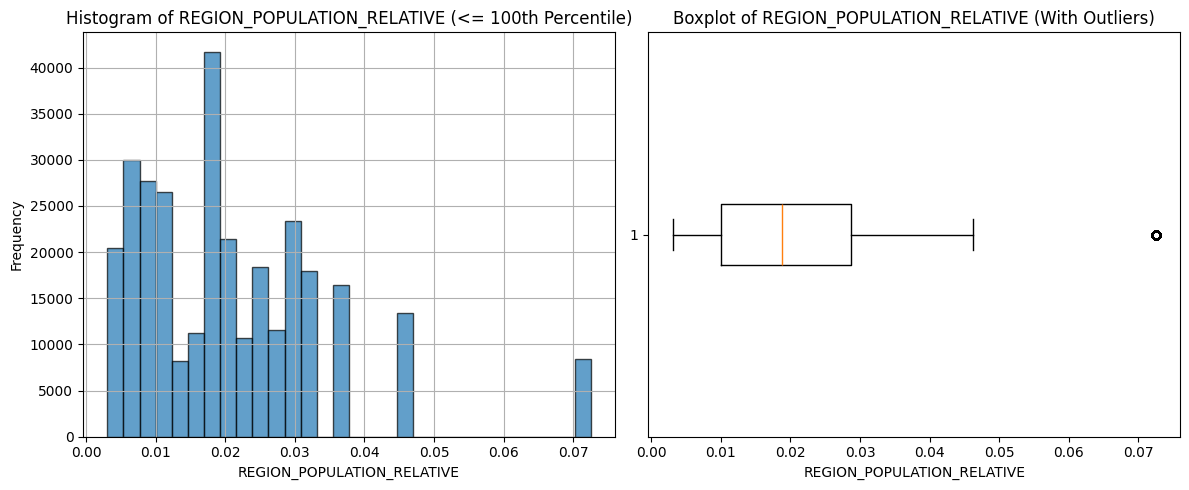

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.021038183397833626
Mean for target=1 (Defaulter): 0.019154829969788515
t-statistic: 20.620147253110456, p-value: 2.097814020191895e-94
There is a significant difference between the groups. 



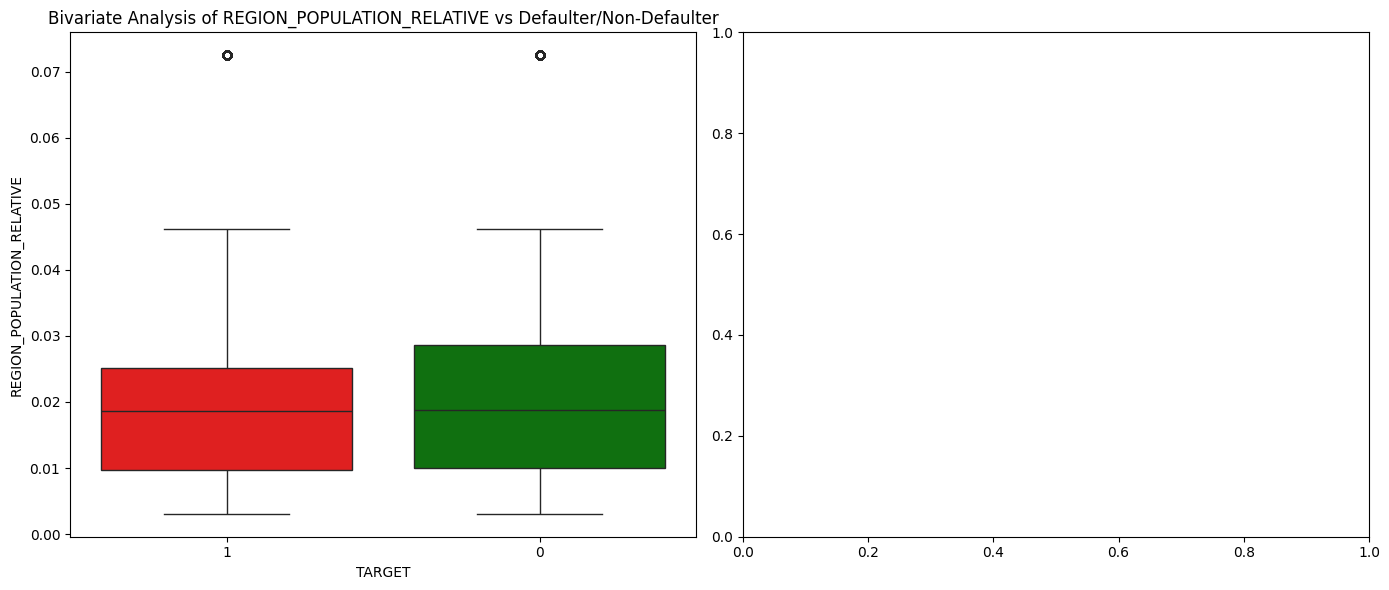

In [18]:
# Comprehensive numerical analysis with side-by-side subplots
def numerical_analysis(df, column, target_column="TARGET", percentile=100):
    """
    Perform a comprehensive numerical analysis on a specified column of a DataFrame.
    """
    # Step 1: Assess normality
    assess_normality(df, column, percentile)
    
    # Step 2: Plot histogram and boxplot
    plot_histogram_and_boxplot(df, column, percentile)
    
    # Create a side-by-side plot for bivariate analysis and segment analysis
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns
    
    # Step 3: Perform bivariate analysis and plot on the first axis (left)
    bivariate_analysis(df, column, target_column, percentile, ax=axes[0])
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

numerical_analysis(df_transformed, "REGION_POPULATION_RELATIVE")



### Region Population

---

#### Skew and Kurtosis Analysis
The distribution of `REGION_POPULATION_RELATIVE` is **positively skewed** (1.8104), indicating a small number of regions with much higher relative population densities. The **kurtosis** (8.3595) suggests a **leptokurtic distribution** with pronounced tails, where most regions have low to moderate densities, but a few have exceptionally high densities.

---

#### Does Region Population Density Affect Default Risk?

There is a **statistically significant difference** between defaulters and non-defaulters in terms of region population density, with non-defaulters residing in regions with slightly higher densities on average. Although the mean difference is small, the large sample size makes this difference highly significant. This is demonstrated in the visible pattern that those in high density population areas the upper quartile, show the lowest default rates

**Potential Reasons**:
- **Economic Stability**: Higher-density regions may have more developed economies and job opportunities, leading to greater financial stability.
- **Rural vs. Urban Factors**: Lower-density regions could represent rural areas with limited economic opportunities, increasing financial vulnerability and default risk.
- **Resource Access**: Higher-density areas often provide better access to resources and financial services, supporting individuals in managing financial obligations.

---

### Conclusion
While the difference in population density between defaulters and non-defaulters is minor, it is statistically significant, suggesting that individuals in higher-density areas may experience more financial stability due to better economic infrastructure. However, this relationship is likely one of several factors influencing default risk.


## Analysis of Bureau Request Features

Chi-square test results for CREDIT_BUREAU_REQ_TOTAL and TARGET:
Chi-square statistic: 126.2381
Degrees of freedom: 12
P-value: 3.5043e-21
Result: Significant association (reject null hypothesis)



C:\Users\david\AppData\Local\Temp\ipykernel_4388\600815862.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discrete_feature, y=target, data=df_percentage, palette='coolwarm')


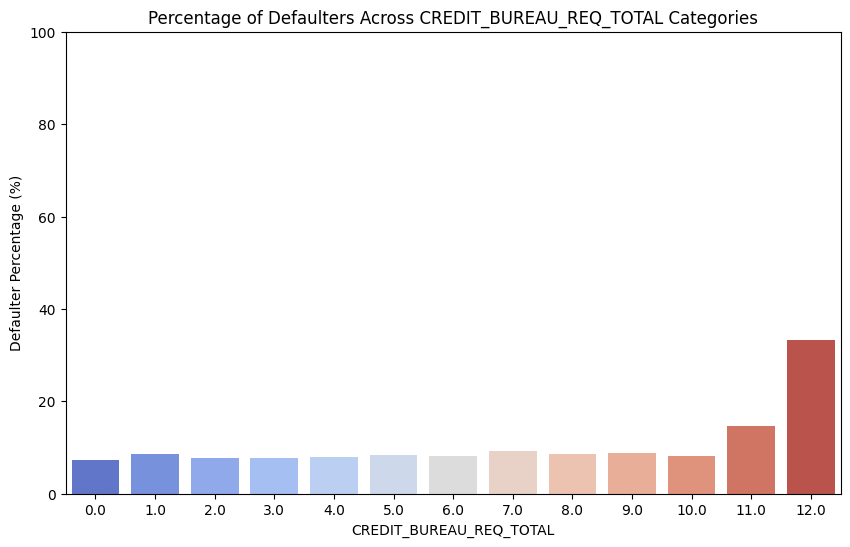

Chi-square test results for SOCIAL_CIRCLE_OBS_TOTAL and TARGET:
Chi-square statistic: 49.3105
Degrees of freedom: 17
P-value: 5.4012e-05
Result: Significant association (reject null hypothesis)



C:\Users\david\AppData\Local\Temp\ipykernel_4388\600815862.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discrete_feature, y=target, data=df_percentage, palette='coolwarm')


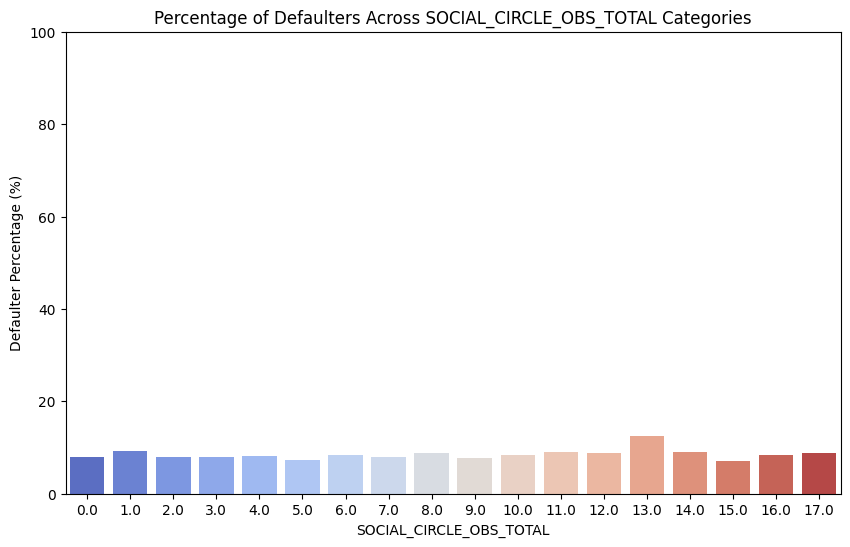

Chi-square test results for SOCIAL_CIRCLE_DEF_TOTAL and TARGET:
Chi-square statistic: 350.6901
Degrees of freedom: 3
P-value: 1.0574e-75
Result: Significant association (reject null hypothesis)



C:\Users\david\AppData\Local\Temp\ipykernel_4388\600815862.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=discrete_feature, y=target, data=df_percentage, palette='coolwarm')


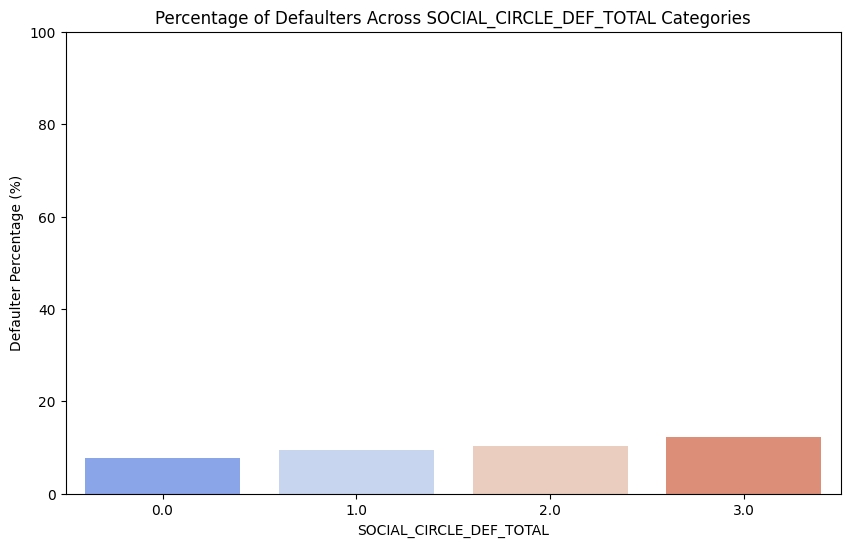

In [19]:

# Aggregate Credit Bureau Inquiries
df_transformed['CREDIT_BUREAU_REQ_TOTAL'] = (
    df_transformed['AMT_REQ_CREDIT_BUREAU_HOUR'] +
    df_transformed['AMT_REQ_CREDIT_BUREAU_DAY'] +
    df_transformed['AMT_REQ_CREDIT_BUREAU_WEEK'] +
    df_transformed['AMT_REQ_CREDIT_BUREAU_MON'] +
    df_transformed['AMT_REQ_CREDIT_BUREAU_QRT'] +
    df_transformed['AMT_REQ_CREDIT_BUREAU_YEAR']
)
# Aggregate Social Circle Observations (OBS columns)
df_transformed['SOCIAL_CIRCLE_OBS_TOTAL'] = (
    df_transformed['OBS_30_CNT_SOCIAL_CIRCLE'] +
    df_transformed['OBS_60_CNT_SOCIAL_CIRCLE']
)
# Aggregate Social Circle Defaults (DEF columns)
df_transformed['SOCIAL_CIRCLE_DEF_TOTAL'] = (
    df_transformed['DEF_30_CNT_SOCIAL_CIRCLE'] +
    df_transformed['DEF_60_CNT_SOCIAL_CIRCLE']
)

plot_defaulter_percentage(df_transformed, "CREDIT_BUREAU_REQ_TOTAL", "TARGET")

# Apply numerical_analysis function to SOCIAL_CIRCLE_OBS_TOTAL
plot_defaulter_percentage(df_transformed, 'SOCIAL_CIRCLE_OBS_TOTAL', "TARGET")

# Apply numerical_analysis function to SOCIAL_CIRCLE_DEF_TOTAL
plot_defaulter_percentage(df_transformed, 'SOCIAL_CIRCLE_DEF_TOTAL', "TARGET")


### Social Circle Observations and Defaults

---

#### SOCIAL_CIRCLE_OBS_TOTAL (Count of Observed Contacts in Social Circle)

The chi-square test indicates a **significant association** between `SOCIAL_CIRCLE_OBS_TOTAL` and `TARGET`, suggesting that the number of social circle observations is statistically related to default risk. However, visually, there is no clear pattern across categories, as default rates vary inconsistently.

**Insights**:
- The lack of a visible pattern suggests that simply having more observed social contacts does not directly correlate with default risk.
- The statistical significance may reflect subtle differences across a large dataset, but these differences are not practically meaningful for predicting default risk.

---

#### SOCIAL_CIRCLE_DEF_TOTAL (Count of Defaulters in Social Circle)

The chi-square test reveals a **significant association** between `SOCIAL_CIRCLE_DEF_TOTAL` and `TARGET`, showing a meaningful relationship between the number of defaulters in a person’s social circle and their own default risk.

**Insights**:
- There is a clearer trend: individuals with more defaulters in their social circle tend to have a higher default rate themselves, indicating that social influence or shared economic conditions might increase default risk.
- This trend suggests that a high count of defaulters in an applicant’s social circle could serve as an indicator of elevated risk, reflecting either shared socioeconomic challenges or behavioral influences.

---

### Comparison to Credit Bureau Inquiries (Contextual Insight)

The findings on `SOCIAL_CIRCLE_DEF_TOTAL` can be contextualized alongside the analysis of `CREDIT_BUREAU_REQ_TOTAL`, where a high number of credit inquiries also correlated strongly with default risk. Both features highlight that **excessive reliance on credit** and **association with other defaulters** signal financial strain or instability, providing important indicators for creditworthiness.

---

### Conclusion

- **SOCIAL_CIRCLE_OBS_TOTAL**: Although statistically significant, it does not exhibit a clear pattern and may not be predictive of default risk.
- **SOCIAL_CIRCLE_DEF_TOTAL**: Shows a positive association with individual default risk, making it a potentially meaningful predictor.
- **CREDIT_BUREAU_REQ_TOTAL**: Similarly, high inquiry counts are associated with elevated default risk, suggesting a pattern where both personal connections and credit behavior influence an individual's financial reliability.

These findings suggest that while general social observations have limited impact, the presence of defaulters in one’s social circle and frequent credit inquiries could be relevant factors in assessing credit risk, as they both potentially reflect an underlying financial vulnerability.


## Analysis of Time Features

Normality Assessment for DAYS_BIRTH (<= 100th Percentile):
Jarque-Bera Statistic: 8881.6197, p-value: 0.0000
Skewness: 0.2202
Kurtosis: 2.1928
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



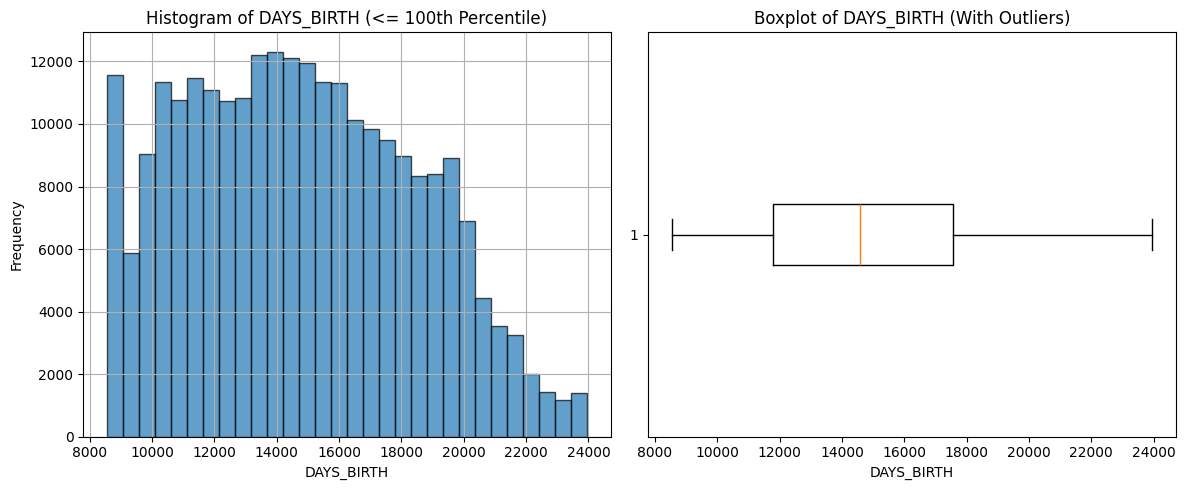

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 14849.821751439415
Mean for target=1 (Defaulter): 13998.433707350583
t-statistic: 33.059509481524074, p-value: 3.7075607659627767e-239
There is a significant difference between the groups. 



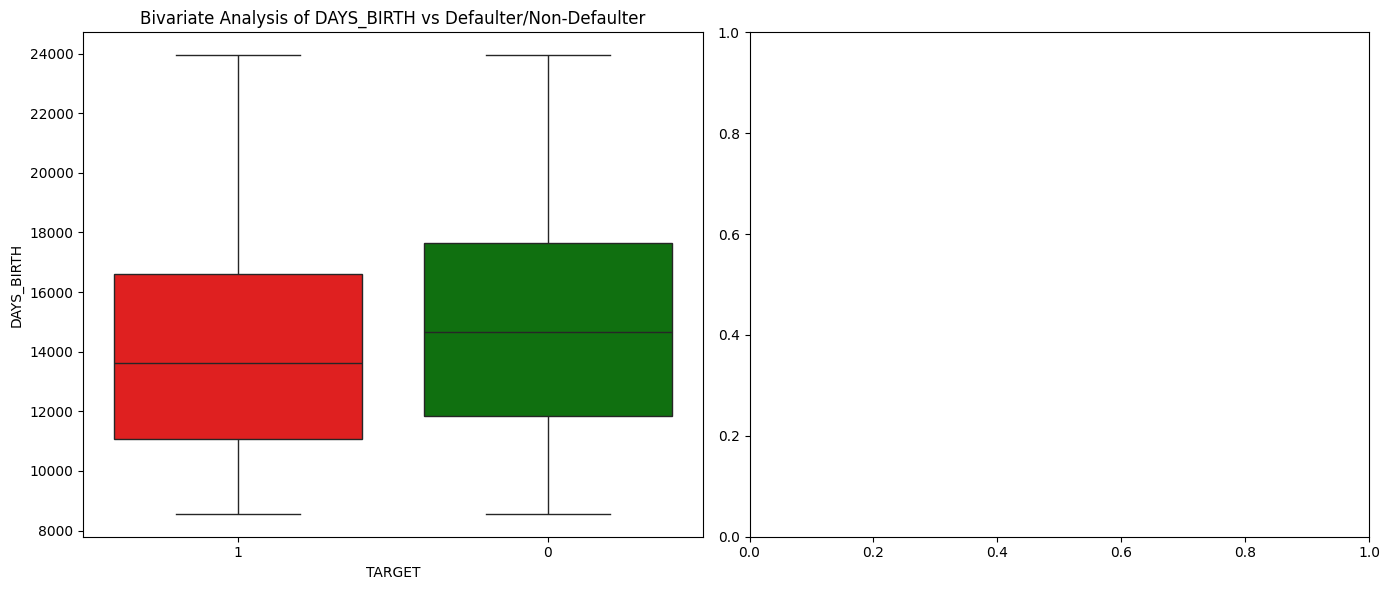

Normality Assessment for DAYS_EMPLOYED (<= 100th Percentile):
Jarque-Bera Statistic: 129114.8303, p-value: 0.0000
Skewness: 1.4919
Kurtosis: 4.8405
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



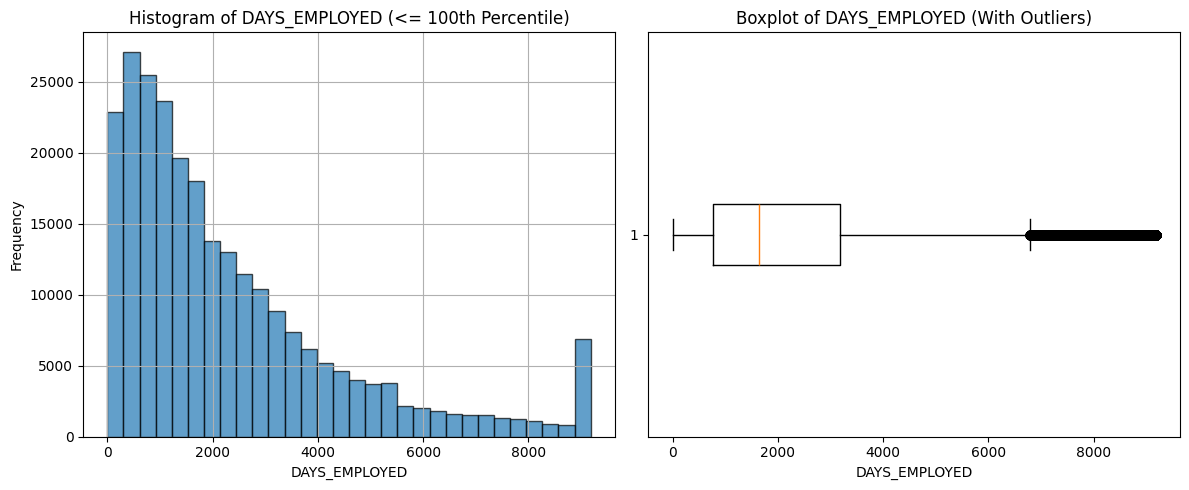

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 2384.5266259085897
Mean for target=1 (Defaulter): 1797.071170139684
t-statistic: 38.745460471359806, p-value: 0.0
There is a significant difference between the groups. 



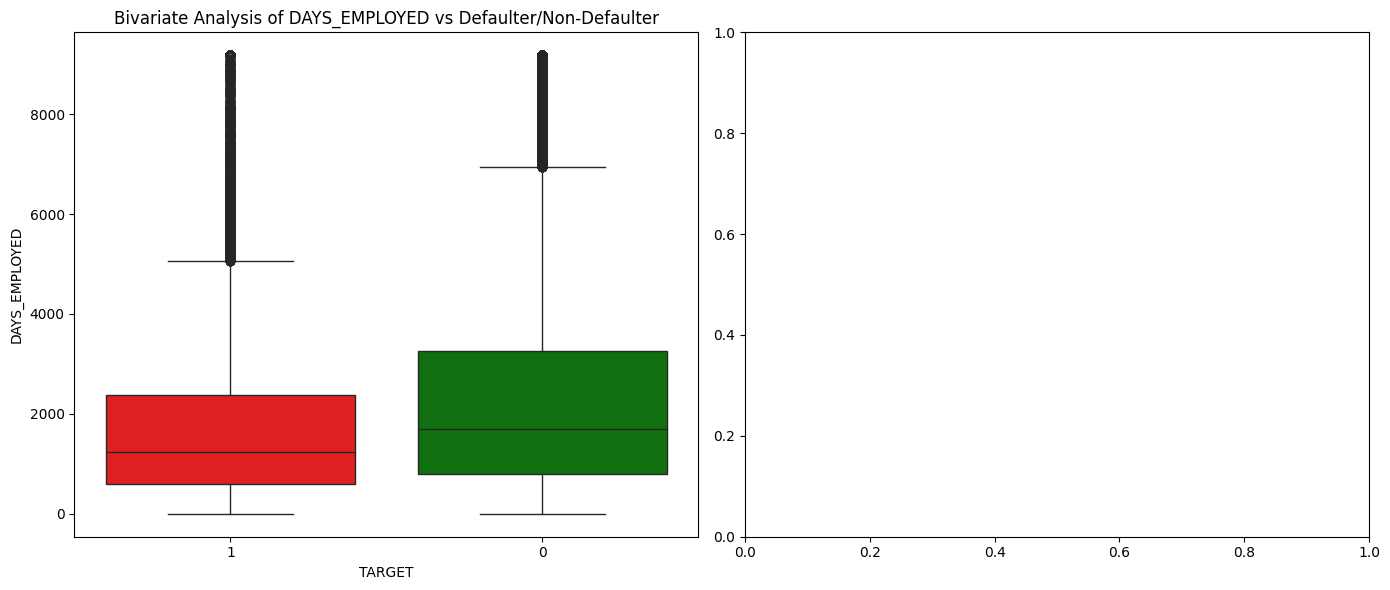

Normality Assessment for DAYS_REGISTRATION (<= 100th Percentile):
Jarque-Bera Statistic: 14353.0479, p-value: 0.0000
Skewness: 0.5032
Kurtosis: 2.4055
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



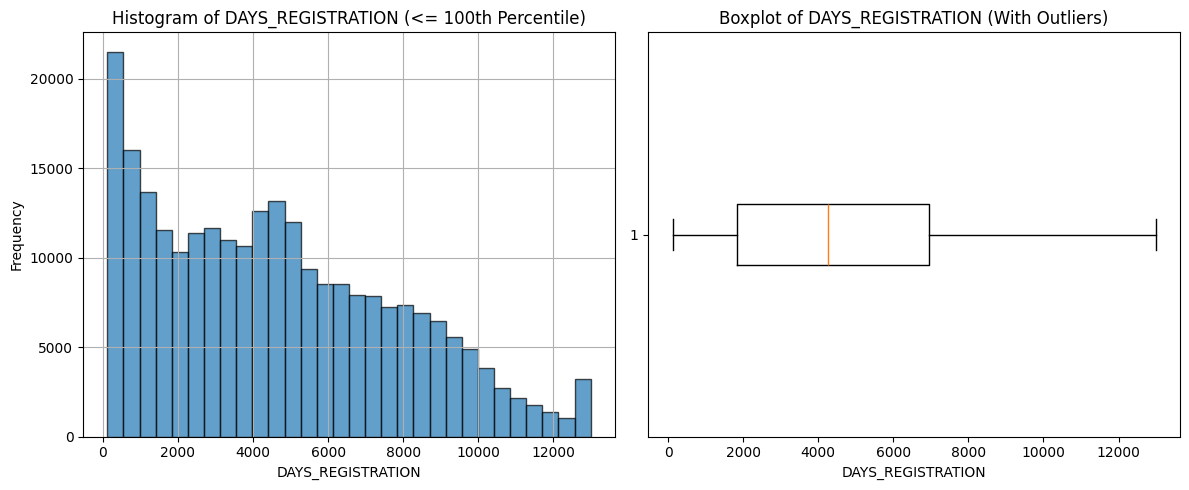

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 4661.263271885032
Mean for target=1 (Defaulter): 4249.444424089764
t-statistic: 18.090117488263445, p-value: 4.2422320984529264e-73
There is a significant difference between the groups. 



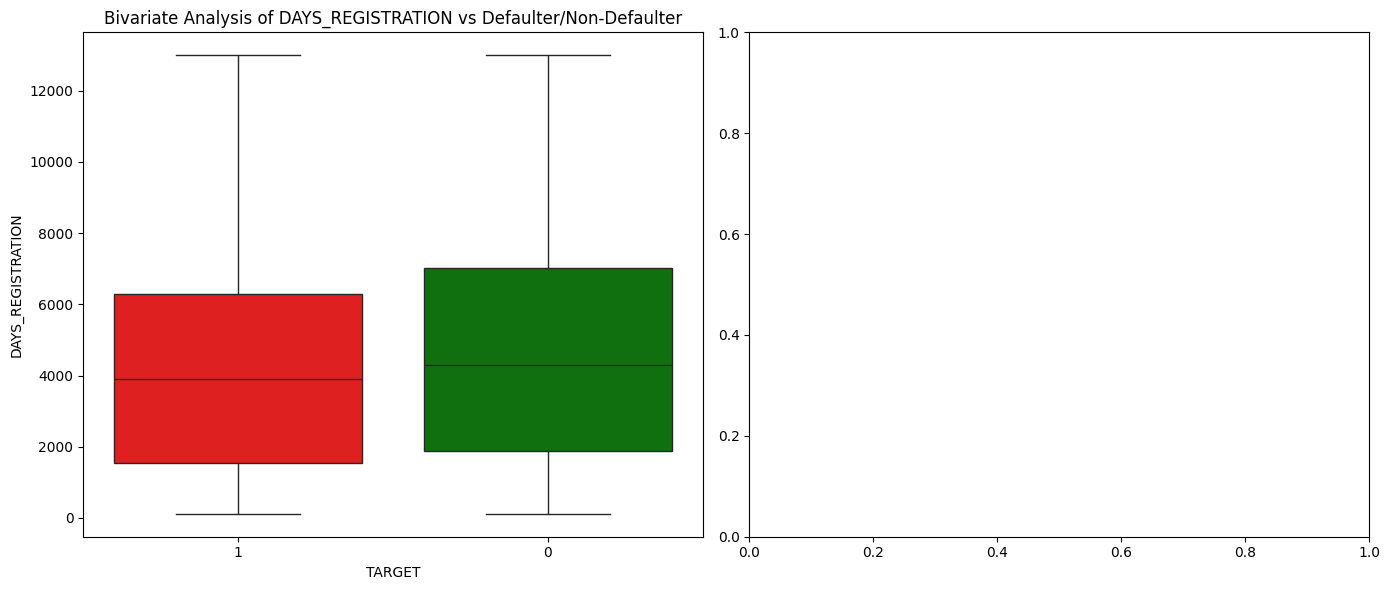

Normality Assessment for DAYS_ID_PUBLISH (<= 100th Percentile):
Jarque-Bera Statistic: 17342.0968, p-value: 0.0000
Skewness: -0.1762
Kurtosis: 1.7645
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



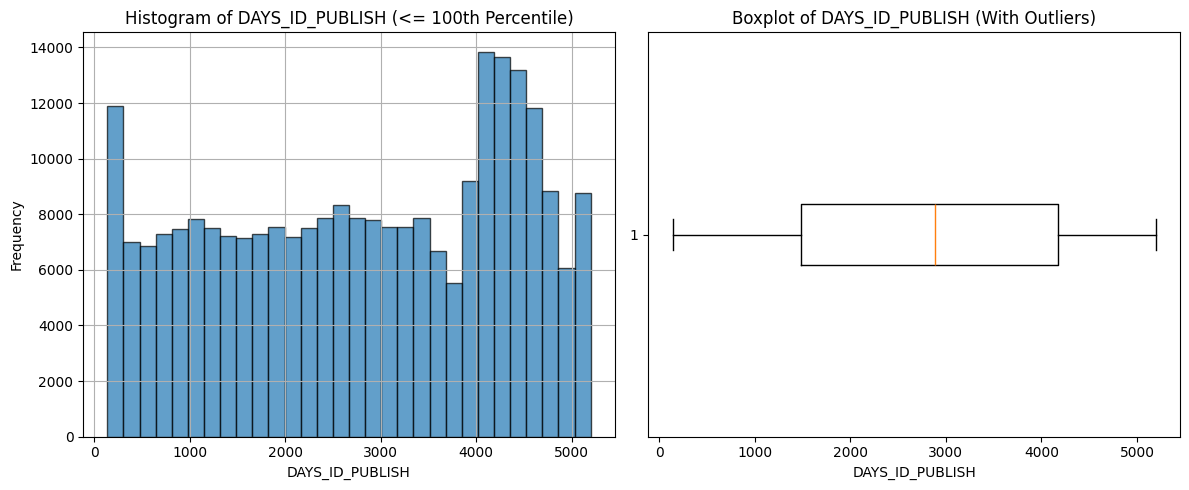

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 2814.4645248412953
Mean for target=1 (Defaulter): 2602.0275704144724
t-statistic: 20.003289258853318, p-value: 6.04653000136696e-89
There is a significant difference between the groups. 



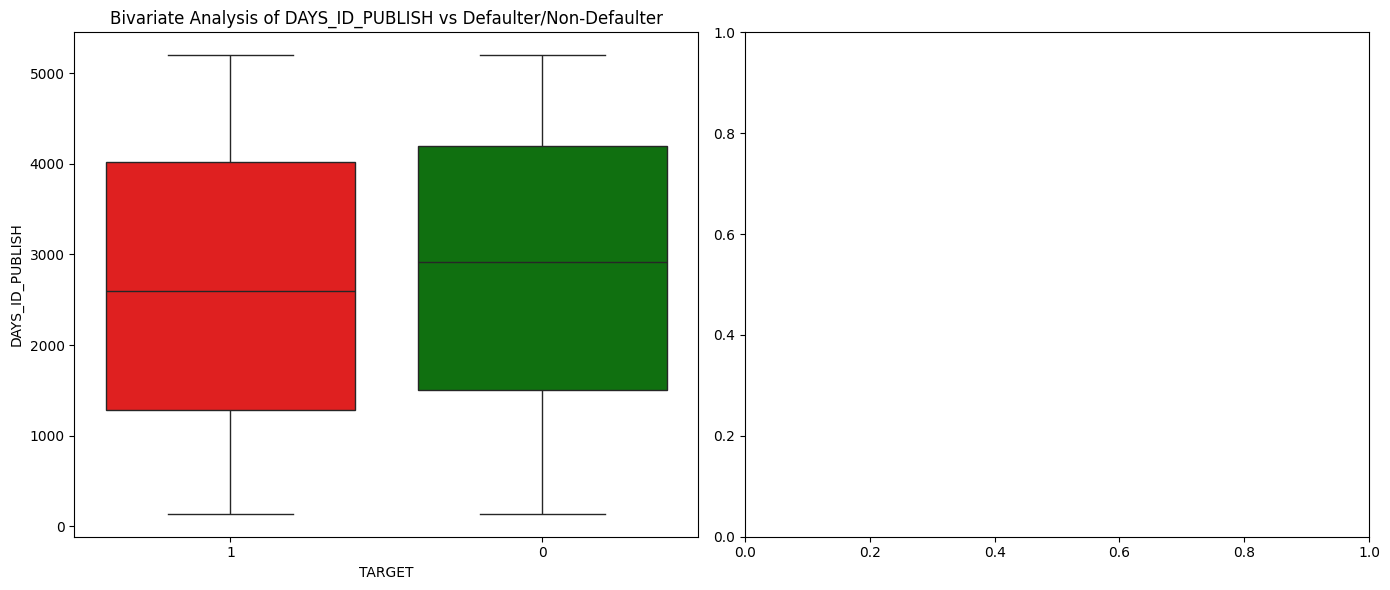

Normality Assessment for DAYS_LAST_PHONE_CHANGE (<= 100th Percentile):
Jarque-Bera Statistic: 20492.9134, p-value: 0.0000
Skewness: 0.6248
Kurtosis: 2.3763
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



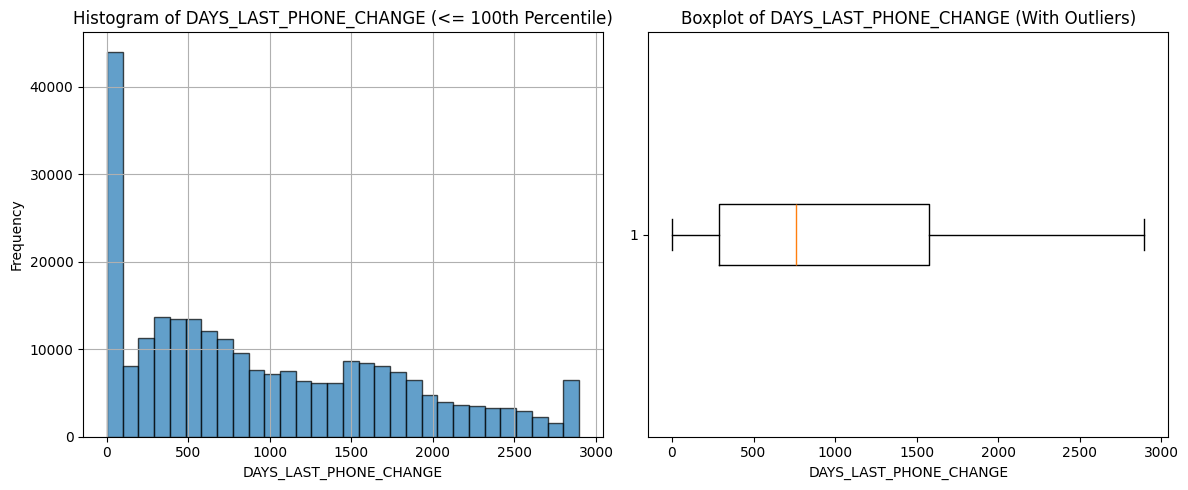

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 980.2927199937474
Mean for target=1 (Defaulter): 805.8501946416304
t-statistic: 30.39634361781657, p-value: 1.430953683717373e-202
There is a significant difference between the groups. 



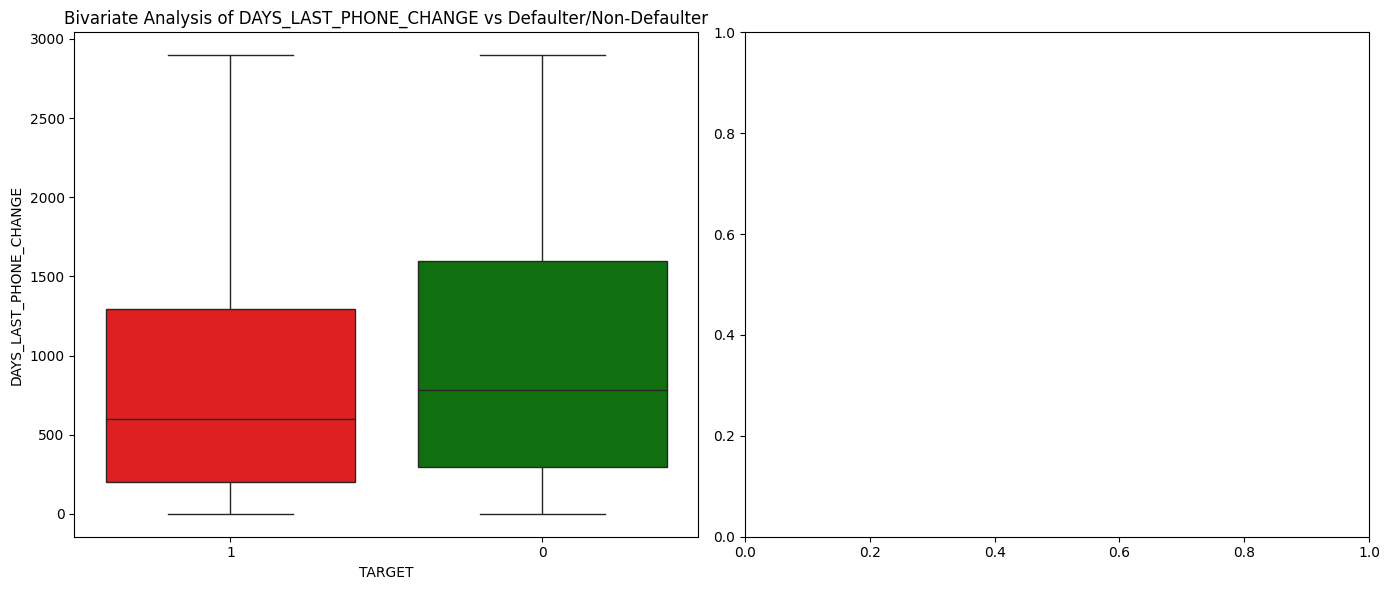

In [20]:

# List of time-based columns to convert to absolute values for better interpretability
time_columns = ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE']
# Apply abs() to all these columns
df_transformed[time_columns] = df_transformed[time_columns].abs()

threshold = 365 * 120 #since the data has been scaled
# Drop the rows where DAYS_EMPLOYED is greater than the threshold
df_transformed = df_transformed[df_transformed["DAYS_EMPLOYED"] <= threshold]
# this was neccesary as there was a misinput in the data which suggested an indiviudal had been working hard since 400BC presumably as a scribe in old bablyon massively skewing the graphs



for col in time_columns:
  numerical_analysis(df_transformed, col)




### Time-Based Features and Default Risk

The analysis of the **time-based features** (`DAYS_BIRTH`, `DAYS_EMPLOYED`, `DAYS_REGISTRATION`, `DAYS_ID_PUBLISH`, `DAYS_LAST_PHONE_CHANGE`) reveals a consistent trend: **longer durations correlate with lower default risk**, and these relationships are statistically significant.

---

### Key Insights:

1. **Age of the Applicant (`DAYS_BIRTH`)**:
   Older applicants (i.e., a larger number of days since birth) are significantly less likely to default. This could be attributed to **greater financial stability**, **risk aversion**, and accumulated **life experience**.

2. **Employment Duration (`DAYS_EMPLOYED`)**:
   The longer the applicant has been employed, the lower their risk of default. Stable, long-term employment often indicates **consistent income** and **financial security**, making them less prone to default.

3. **Address Registration (`DAYS_REGISTRATION`)**:
   A longer period since the applicant registered their current address is also correlated with lower default risk. This reflects **residential stability**, which could indicate fewer disruptions in their life, further lowering financial risk.

4. **ID Publish Date (`DAYS_ID_PUBLISH`)**:
   The number of days since the applicant's ID was issued is another marker of stability. The longer this duration, the less likely they are to default, possibly reflecting **low mobility** and **stability** in personal circumstances.

5. **Phone Change (`DAYS_LAST_PHONE_CHANGE`)**:
   Applicants who haven't changed their phone in a long time are less likely to default. Consistency in communication methods could signal **financial stability** and a more **settled lifestyle**.

---

### Possible Explanations:
- **Financial Stability**: Longer periods in employment, residence, or ID issuance reflect stable life choices, which typically reduce default risk.
- **Age-Related Wisdom and Risk Aversion**: As people age, they often become more financially prudent and avoid high-risk financial decisions.
- **Accumulated Wealth**: More time employed or settled in one place often means more opportunities to accumulate savings and wealth, which can be used to cushion financial shocks.

---

### Implications for Lenders:
Lenders should consider **time-based factors** like age, employment length, and stability in residence or communication methods as key indicators of lower default risk. These features reflect the applicant’s **financial resilience** and **stability**.


## Analysis of External-Credit Features

Normality Assessment for EXT_SOURCE_2 (<= 100th Percentile):
Jarque-Bera Statistic: 27602.5581, p-value: 0.0000
Skewness: -0.7962
Kurtosis: 2.6977
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



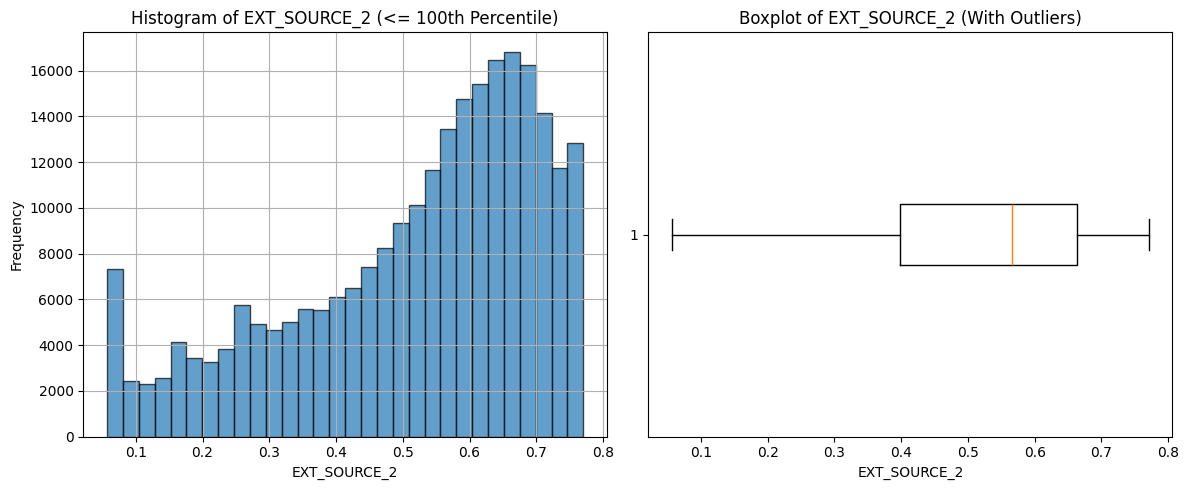

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.5263370600794496
Mean for target=1 (Defaulter): 0.41317547557304896
t-statistic: 86.3088818376593, p-value: 0.0
There is a significant difference between the groups. 



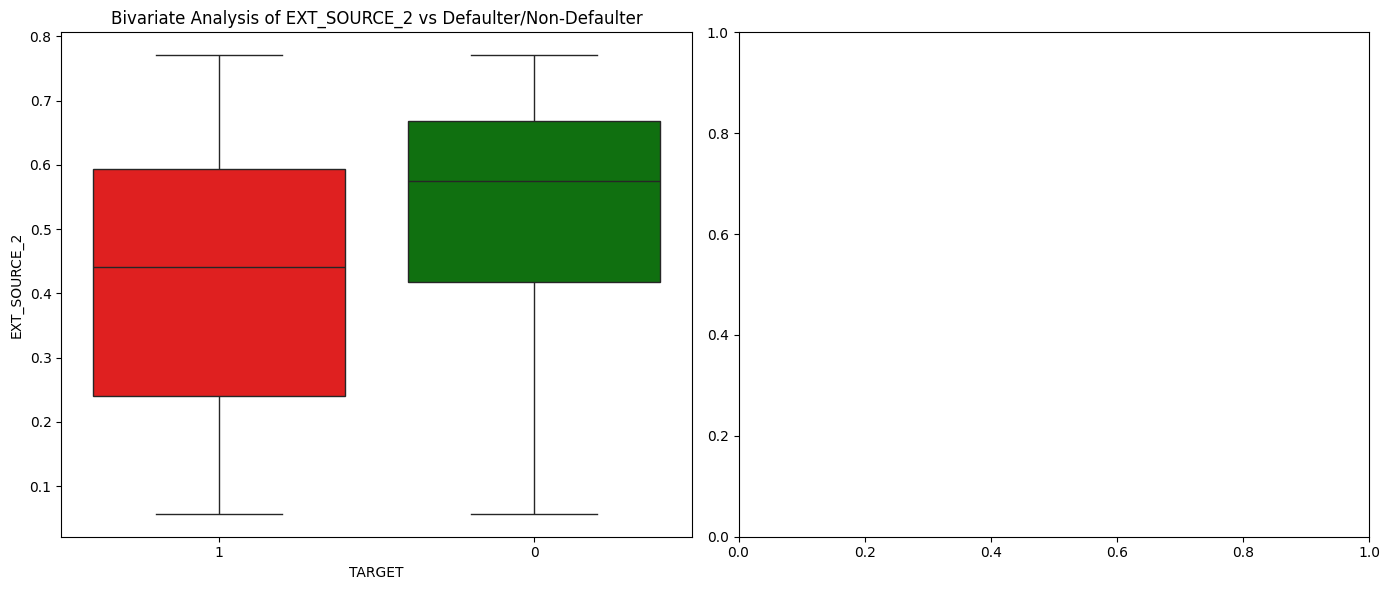

Normality Assessment for EXT_SOURCE_3 (<= 100th Percentile):
Jarque-Bera Statistic: 10348.9402, p-value: 0.0000
Skewness: -0.4769
Kurtosis: 2.7258
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



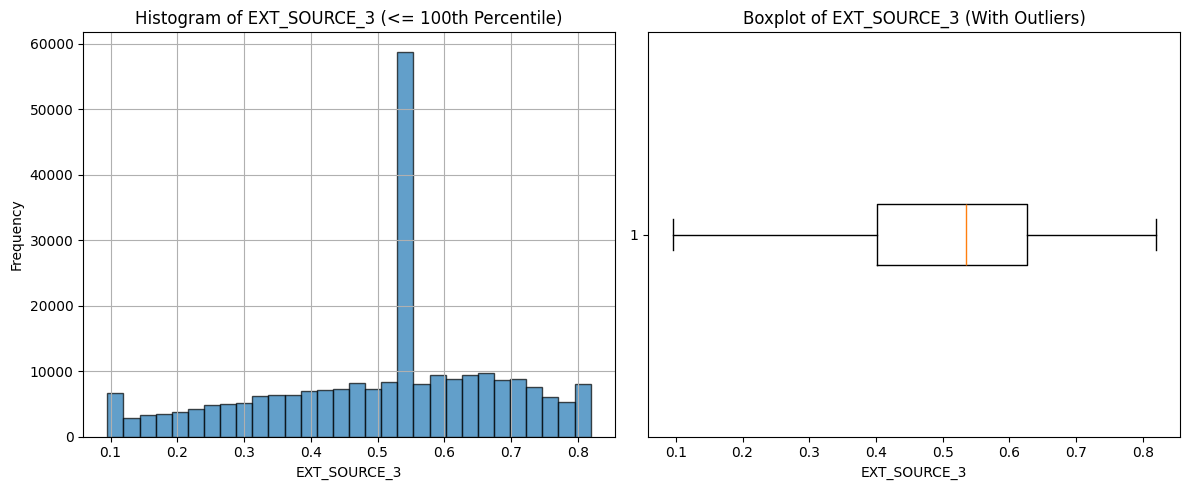

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.51594697243274
Mean for target=1 (Defaulter): 0.4200715701770996
t-statistic: 78.81722860851723, p-value: 0.0
There is a significant difference between the groups. 



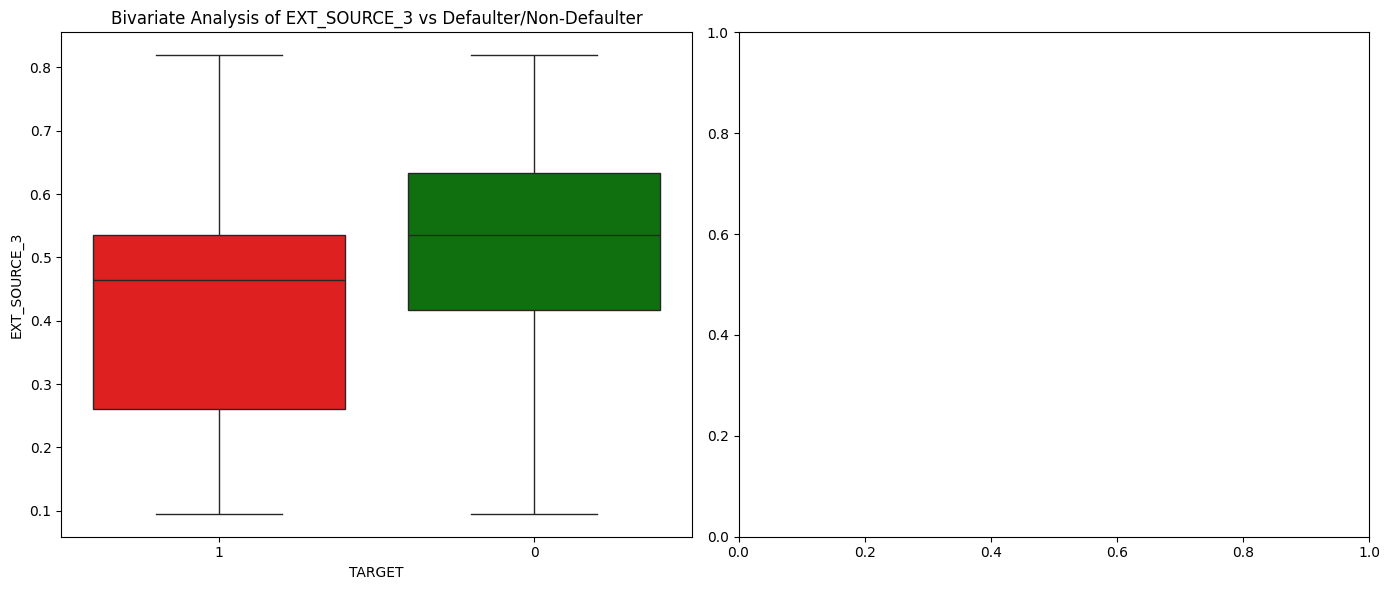

In [21]:
numerical_analysis(df_transformed,"EXT_SOURCE_2")
numerical_analysis(df_transformed,"EXT_SOURCE_3")

### Credit Risk Scores and Default Rates

The analysis shows that **credit risk scores** are reasonably effective at predicting **default risk**. Default rates follow a clear pattern from **high to low credit risk**, demonstrating the utility of these scores in assessing a borrower’s ability to repay.

---

### Key Insights:

1. **Credit Risk Scores Predict Defaults**:
   Higher **credit risk scores** correlate strongly with increased **default rates**. This confirms that **credit risk models** effectively capture underlying borrower vulnerability.

2. **EXTSOURCE1 Heavily Imputed**:
   **EXTSOURCE1** is heavily imputed and may not be reliable on its own. A more useful approach could be to convert it into a **binary flag** that indicates whether the applicant has multiple **credit ratings**, which may better reflect financial reliability.

3. **AMT_CREDIT_REQUEST**:
   Similar to **credit risk scores**, **AMT_CREDIT_REQUEST** provides significant insights into borrower behavior and can be a useful indicator of risk.

4. **Potential Self-Fulfilling Prophecy**:
   There’s a concern that low **credit scores** may result in **unfavorable loan terms** (e.g., higher interest rates, stricter conditions), making repayment more difficult. This raises the possibility that low **credit scores** might contribute to a higher likelihood of **default**, beyond the borrower’s actual financial capacity.

---

### Conclusion:
Credit risk scores are useful in assessing default risk, but care should be taken to consider how **heavily imputed features** and **unfavorable terms** for low-credit applicants could skew outcomes. Using alternative flags and understanding the broader implications of low credit scores may help refine these models.


## Analysis of Property Related Features

Feature: APARTMENTS_AVG, Flag Column: FLAG_APARTMENTS_AVG, Filtered Data Shape: (124801, 173)
Number of TARGET=0: 115542
Number of TARGET=1: 9259
Running bivariate analysis for APARTMENTS_AVG
Normality Assessment for APARTMENTS_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 79459.3738, p-value: 0.0000
Skewness: 1.5509
Kurtosis: 5.3789
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



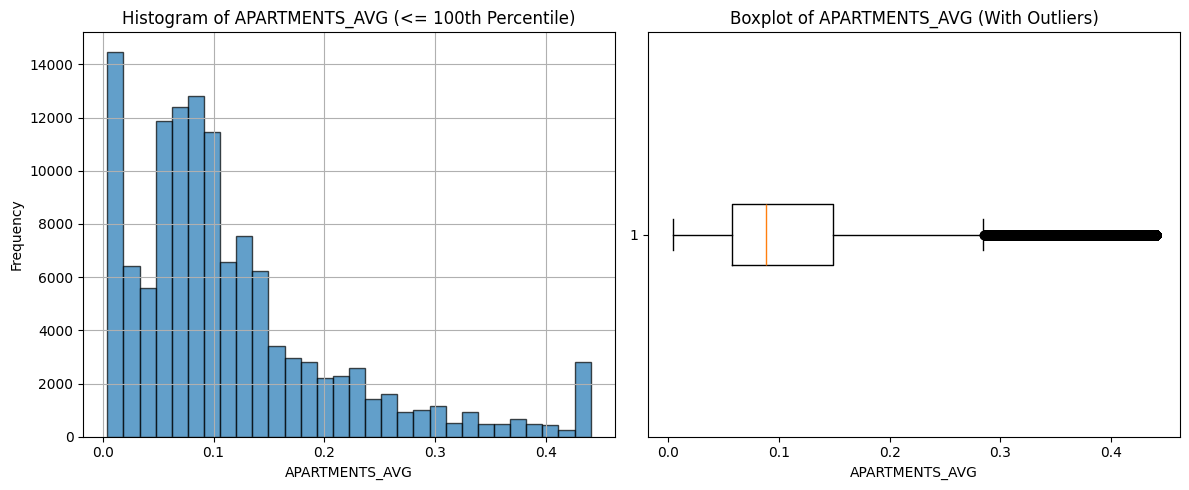

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.1162329369406796
Mean for target=1 (Defaulter): 0.10325885084782374
t-statistic: 12.6318845750772, p-value: 1.4832258398175616e-36
There is a significant difference between the groups. 



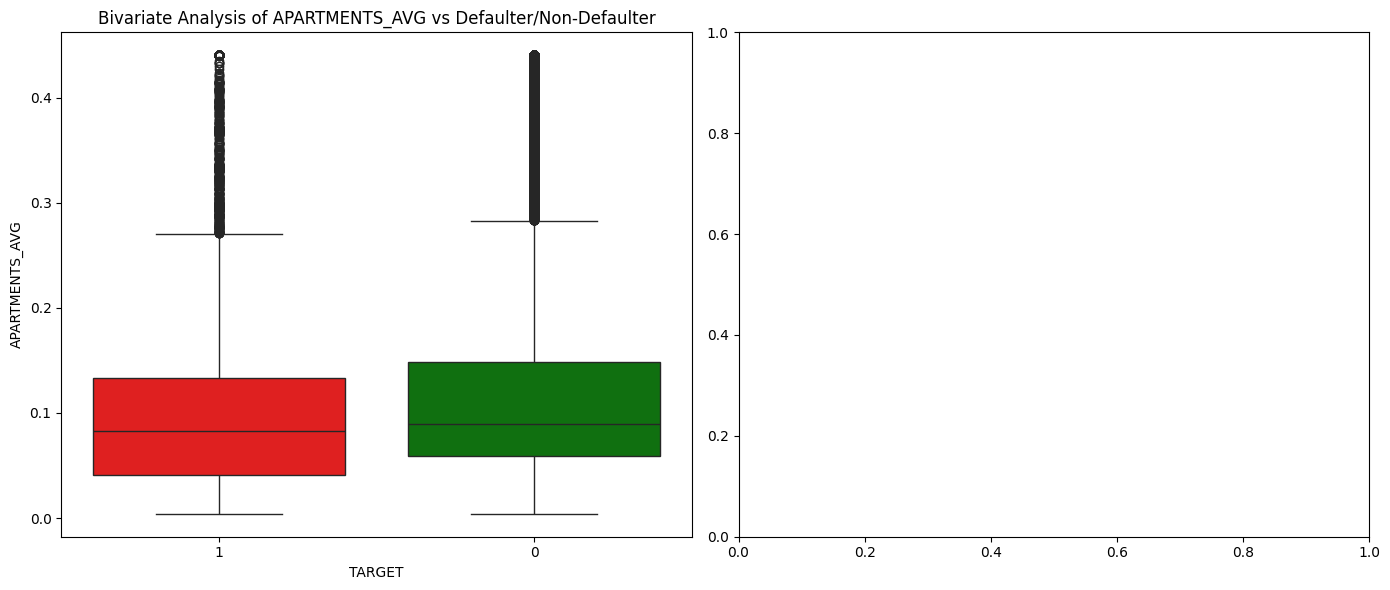

Feature: BASEMENTAREA_AVG, Flag Column: FLAG_BASEMENTAREA_AVG, Filtered Data Shape: (105124, 173)
Number of TARGET=0: 97410
Number of TARGET=1: 7714
Running bivariate analysis for BASEMENTAREA_AVG
Normality Assessment for BASEMENTAREA_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 44913.1629, p-value: 0.0000
Skewness: 1.2583
Kurtosis: 4.9801
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



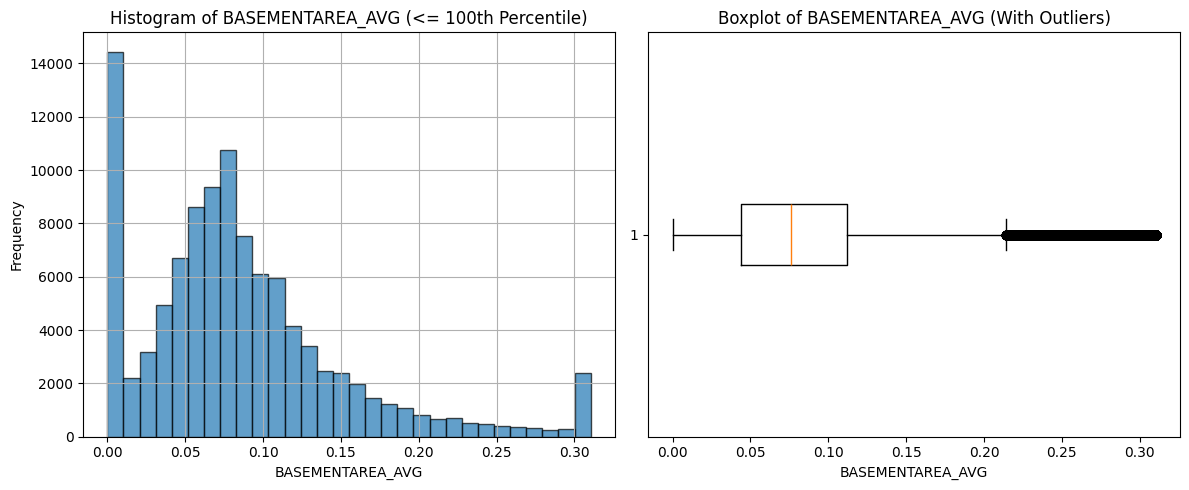

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.08612651883790166
Mean for target=1 (Defaulter): 0.07928781436349495
t-statistic: 8.632794087481818, p-value: 6.068820223806263e-18
There is a significant difference between the groups. 



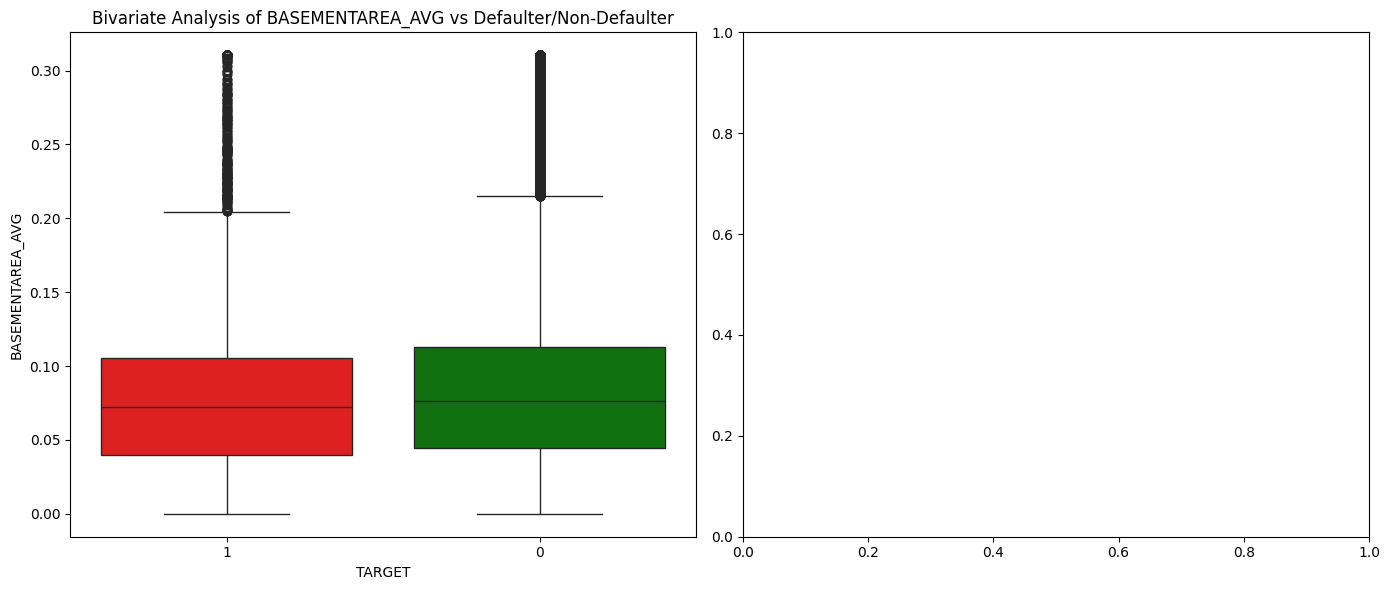

Feature: YEARS_BEGINEXPLUATATION_AVG, Flag Column: FLAG_YEARS_BEGINEXPLUATATION_AVG, Filtered Data Shape: (129796, 173)
Number of TARGET=0: 120115
Number of TARGET=1: 9681
Running bivariate analysis for YEARS_BEGINEXPLUATATION_AVG
Normality Assessment for YEARS_BEGINEXPLUATATION_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 7478.3129, p-value: 0.0000
Skewness: -0.4495
Kurtosis: 3.7581
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



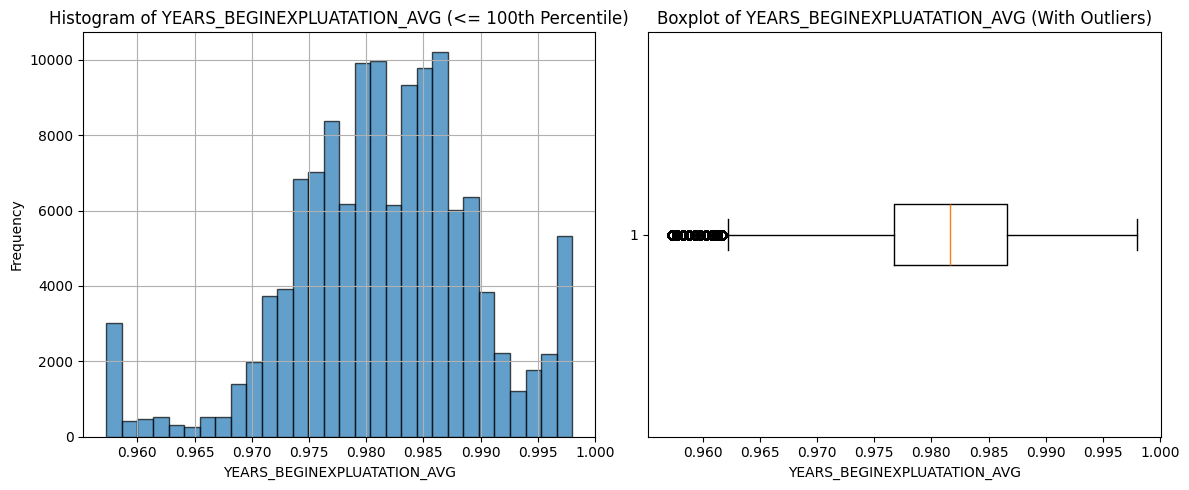

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.9816129908837362
Mean for target=1 (Defaulter): 0.9806711290155975
t-statistic: 10.905955069854812, p-value: 1.1098437781333269e-27
There is a significant difference between the groups. 



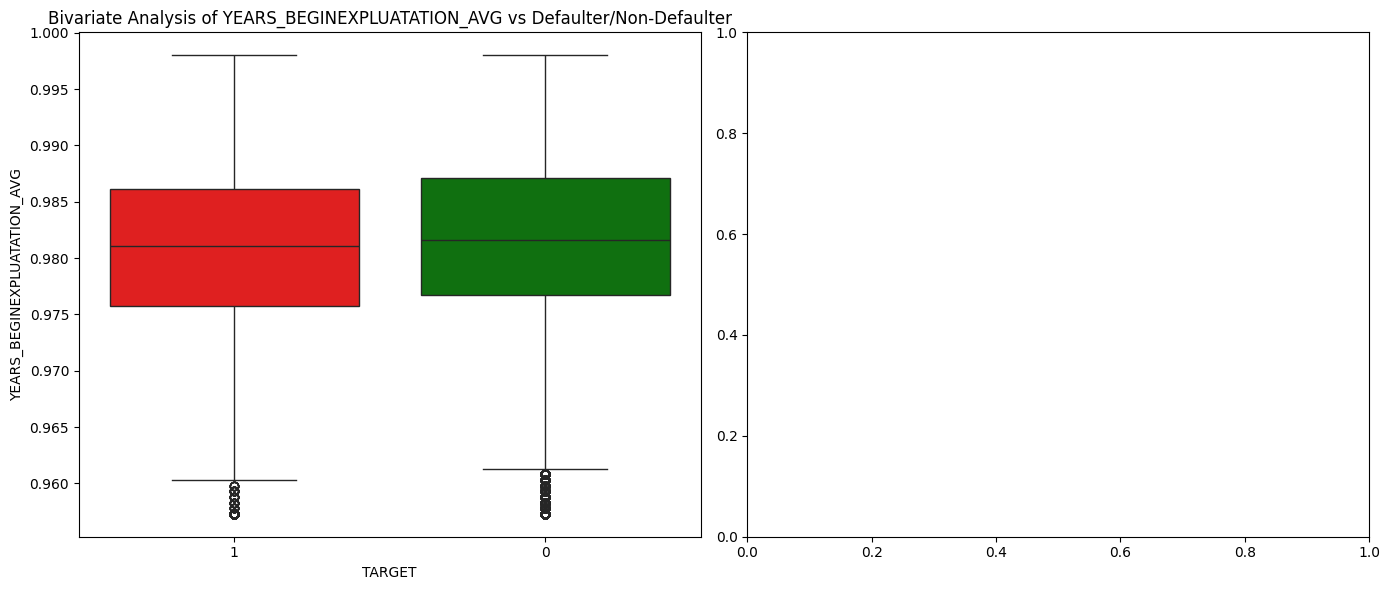

Feature: YEARS_BUILD_AVG, Flag Column: FLAG_YEARS_BUILD_AVG, Filtered Data Shape: (84757, 173)
Number of TARGET=0: 78540
Number of TARGET=1: 6217
Running bivariate analysis for YEARS_BUILD_AVG
Normality Assessment for YEARS_BUILD_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 367.5665, p-value: 0.0000
Skewness: -0.1200
Kurtosis: 3.2156
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



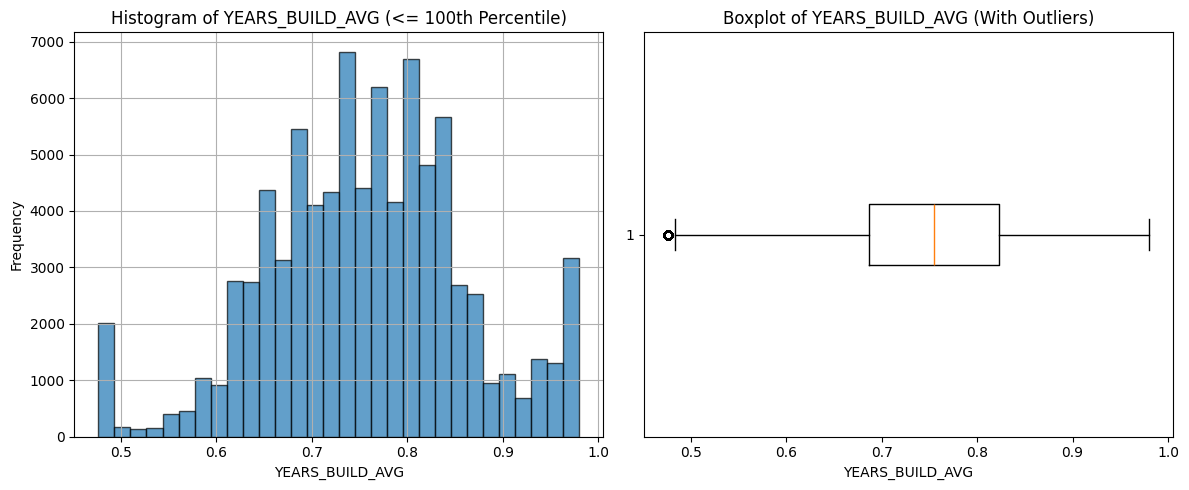

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.756182077922078
Mean for target=1 (Defaulter): 0.7454610262184332
t-statistic: 7.817044058375377, p-value: 5.469636400304209e-15
There is a significant difference between the groups. 



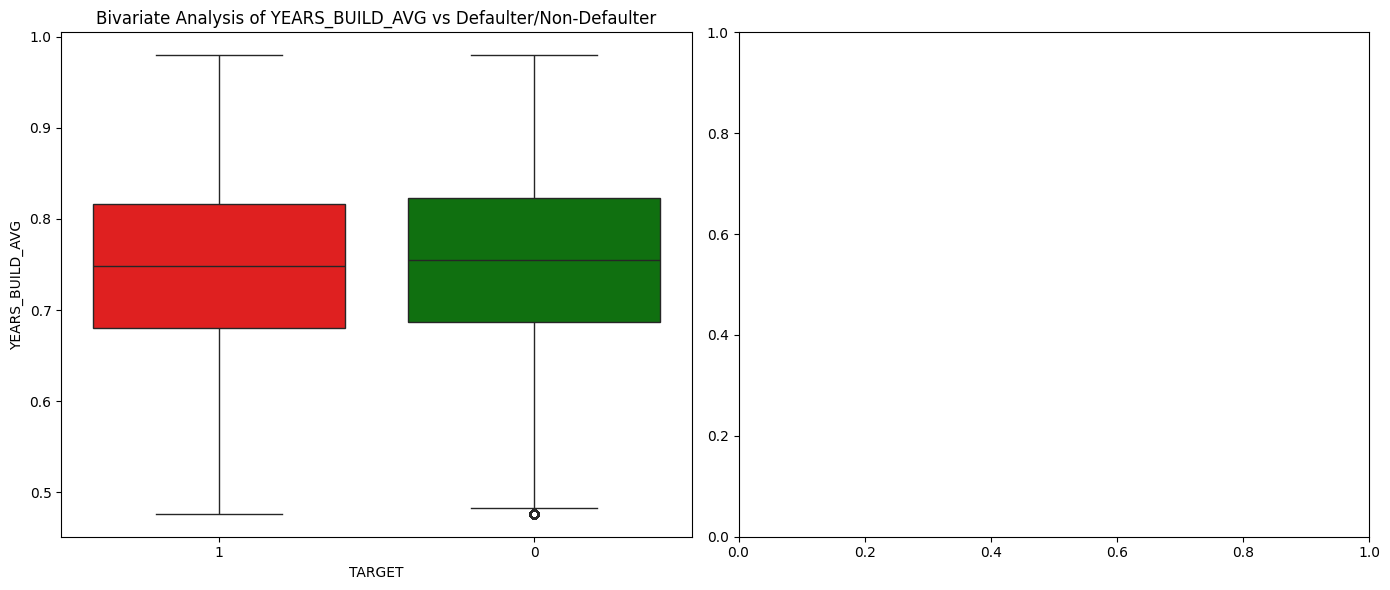

Feature: COMMONAREA_AVG, Flag Column: FLAG_COMMONAREA_AVG, Filtered Data Shape: (76250, 173)
Number of TARGET=0: 70622
Number of TARGET=1: 5628
Running bivariate analysis for COMMONAREA_AVG
Normality Assessment for COMMONAREA_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 168931.7624, p-value: 0.0000
Skewness: 2.3233
Kurtosis: 8.6197
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



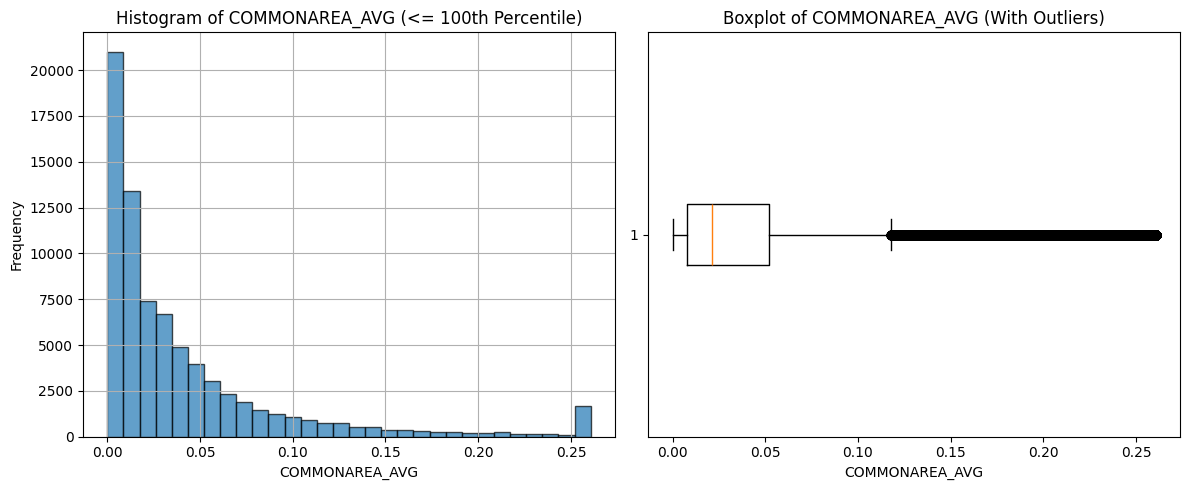

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.04176431423635694
Mean for target=1 (Defaulter): 0.036630739161336176
t-statistic: 6.830378280457845, p-value: 8.532318278876134e-12
There is a significant difference between the groups. 



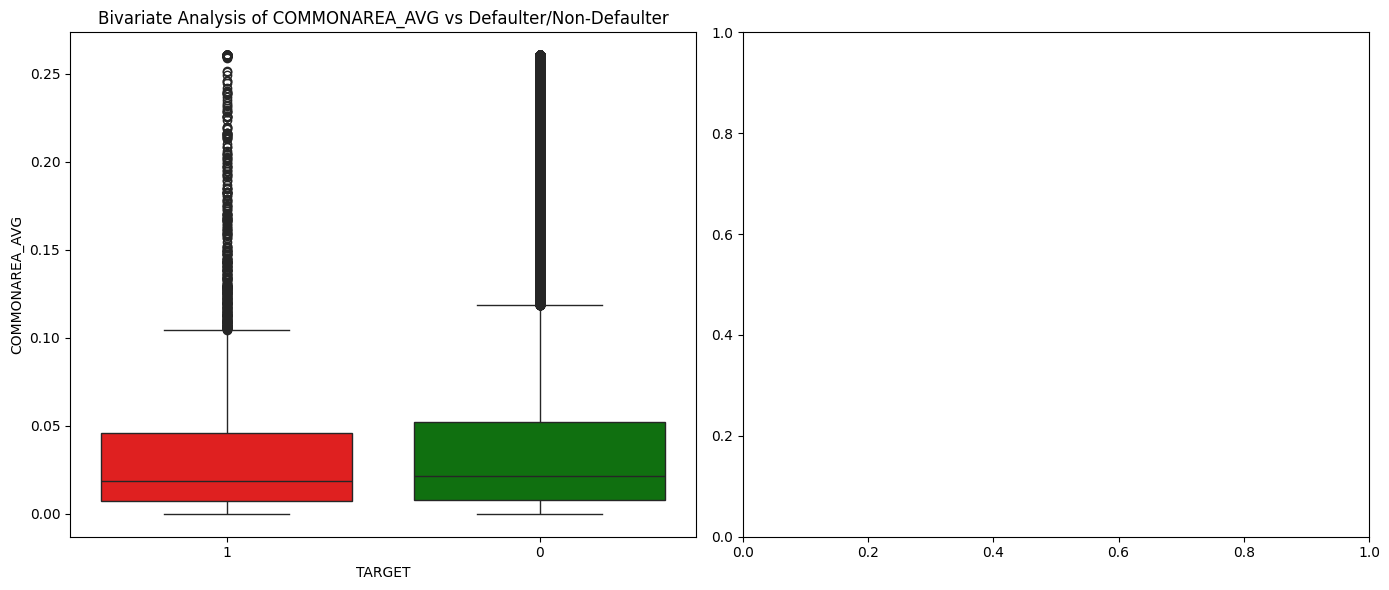

Feature: ELEVATORS_AVG, Flag Column: FLAG_ELEVATORS_AVG, Filtered Data Shape: (118359, 173)
Number of TARGET=0: 109671
Number of TARGET=1: 8688
Running bivariate analysis for ELEVATORS_AVG
Normality Assessment for ELEVATORS_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 82837.9812, p-value: 0.0000
Skewness: 1.7138
Kurtosis: 5.2468
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



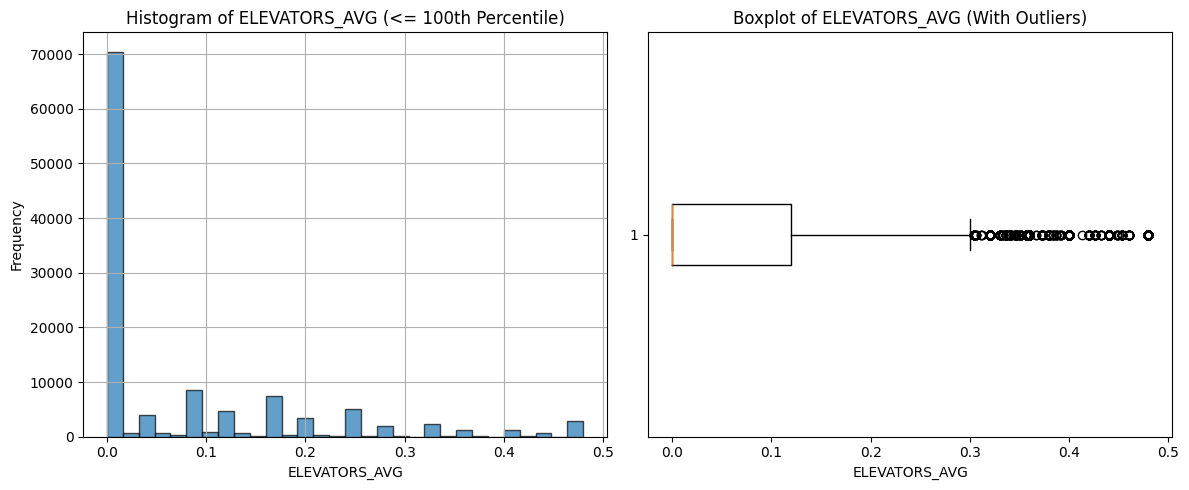

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.07759382516800248
Mean for target=1 (Defaulter): 0.05905879373848987
t-statistic: 13.753058449761815, p-value: 5.26912419744861e-43
There is a significant difference between the groups. 



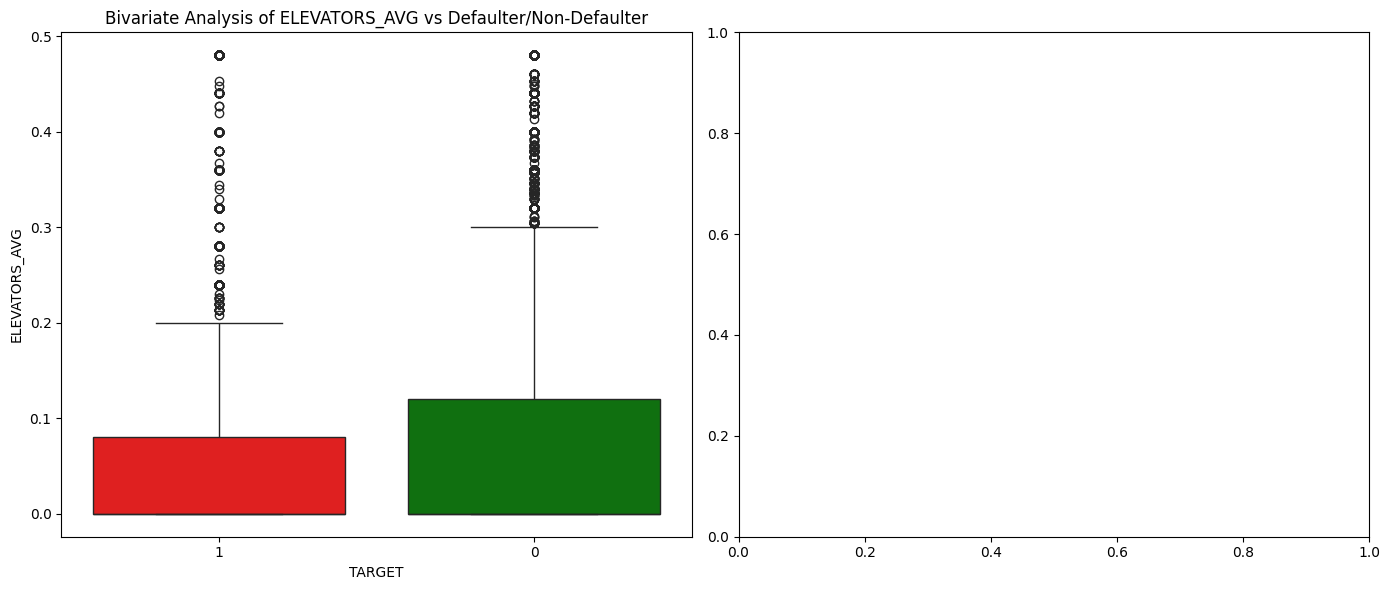

Feature: ENTRANCES_AVG, Flag Column: FLAG_ENTRANCES_AVG, Filtered Data Shape: (125787, 173)
Number of TARGET=0: 116469
Number of TARGET=1: 9318
Running bivariate analysis for ENTRANCES_AVG
Normality Assessment for ENTRANCES_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 29721.6487, p-value: 0.0000
Skewness: 1.0628
Kurtosis: 4.0735
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



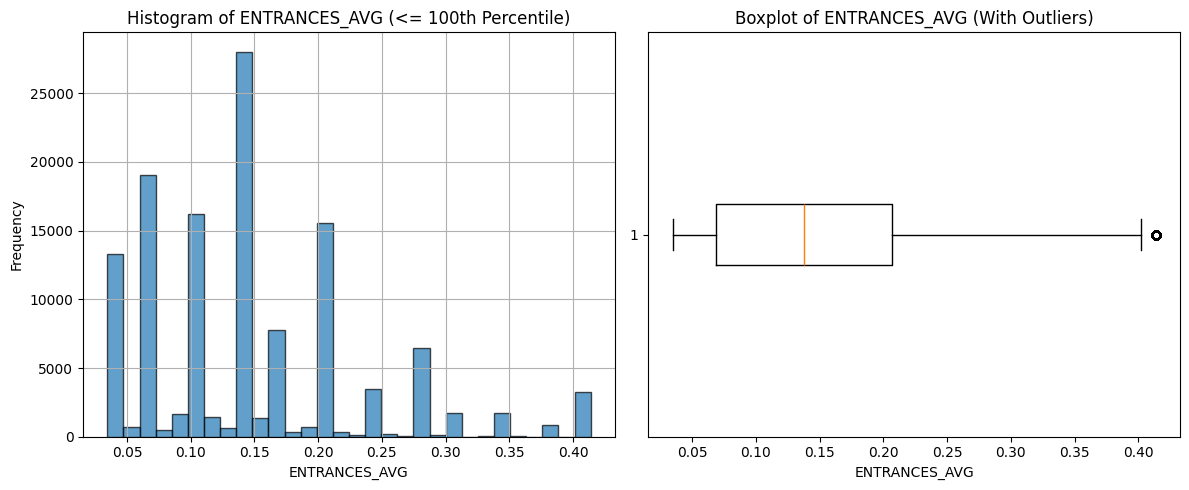

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.14698267693549358
Mean for target=1 (Defaulter): 0.1398646061386564
t-statistic: 7.666806483531333, p-value: 1.7758733770145306e-14
There is a significant difference between the groups. 



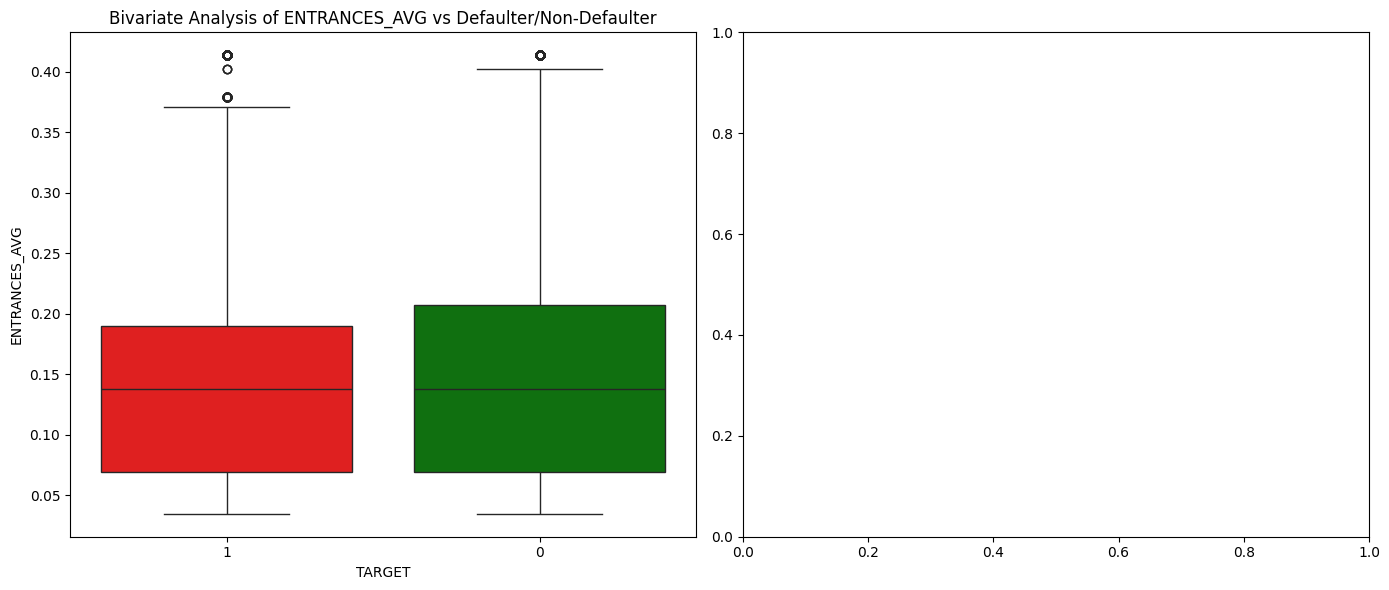

Feature: FLOORSMAX_AVG, Flag Column: FLAG_FLOORSMAX_AVG, Filtered Data Shape: (127280, 173)
Number of TARGET=0: 117825
Number of TARGET=1: 9455
Running bivariate analysis for FLOORSMAX_AVG
Normality Assessment for FLOORSMAX_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 19330.4149, p-value: 0.0000
Skewness: 0.9053
Kurtosis: 3.6056
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



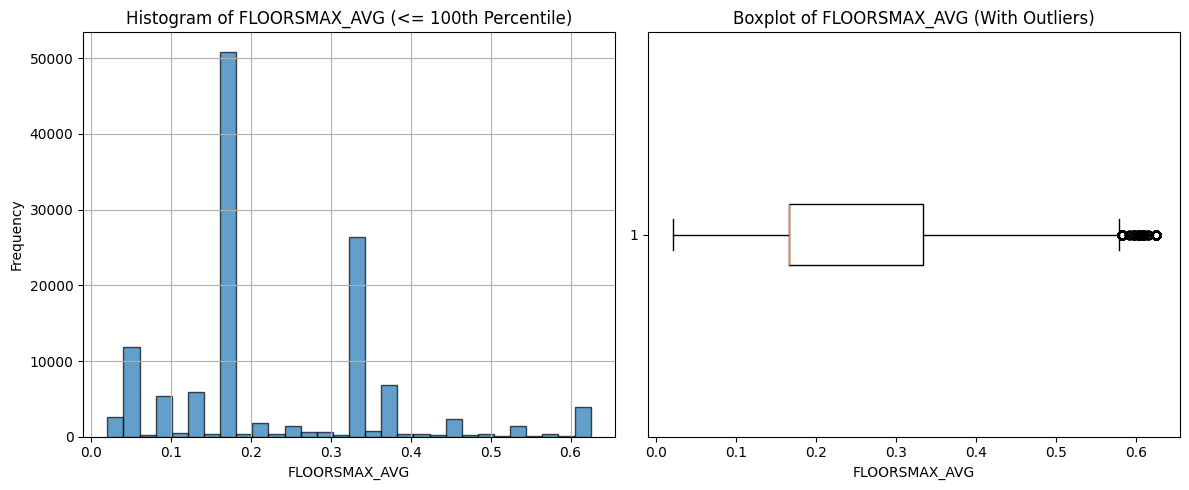

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.22771852323360922
Mean for target=1 (Defaulter): 0.20146233738762562
t-statistic: 17.84821276173003, p-value: 3.645980548196257e-71
There is a significant difference between the groups. 



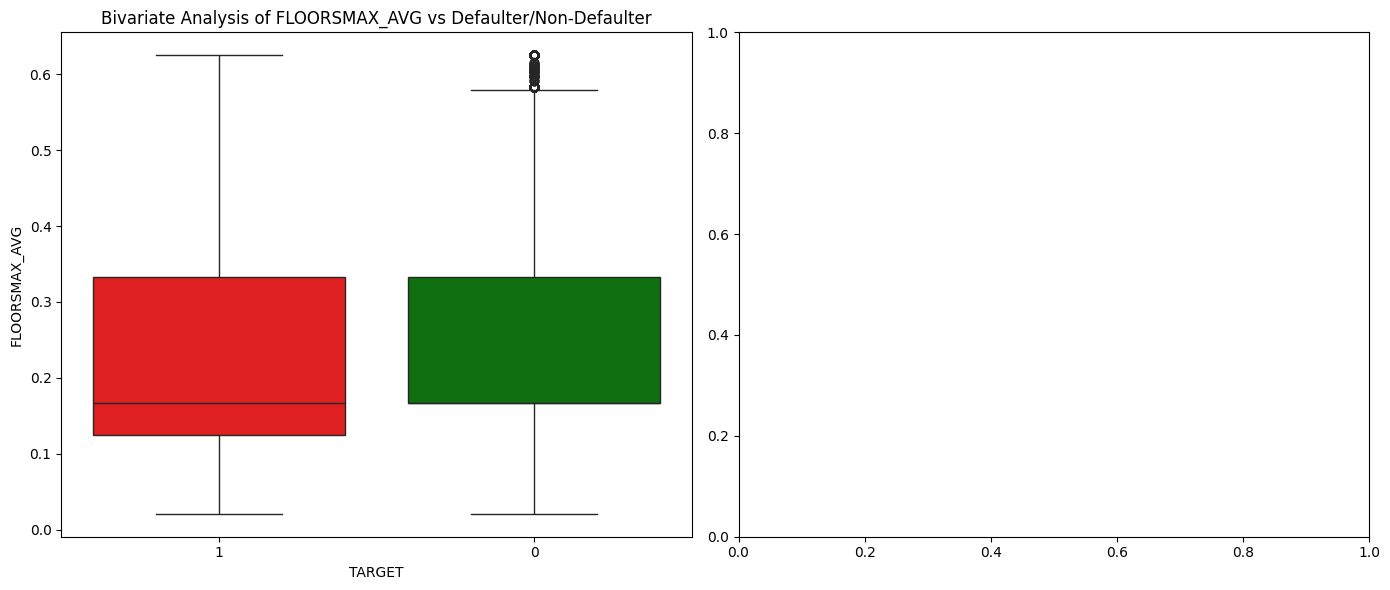

Feature: FLOORSMIN_AVG, Flag Column: FLAG_FLOORSMIN_AVG, Filtered Data Shape: (81339, 173)
Number of TARGET=0: 75349
Number of TARGET=1: 5990
Running bivariate analysis for FLOORSMIN_AVG
Normality Assessment for FLOORSMIN_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 6986.6504, p-value: 0.0000
Skewness: 0.7115
Kurtosis: 3.1908
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



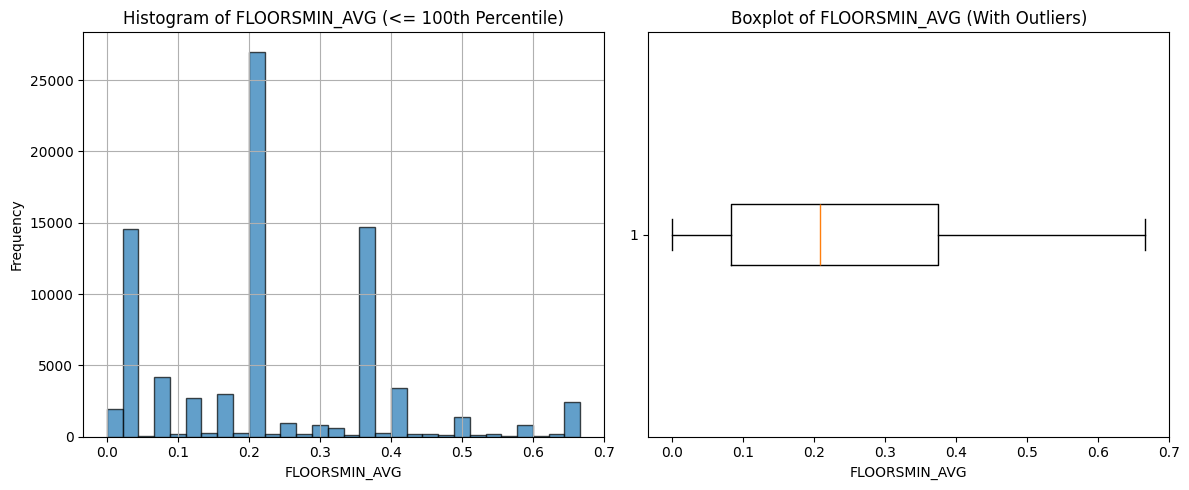

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.23315472136325632
Mean for target=1 (Defaulter): 0.209591285475793
t-statistic: 11.216968485242942, p-value: 3.5365075998998517e-29
There is a significant difference between the groups. 



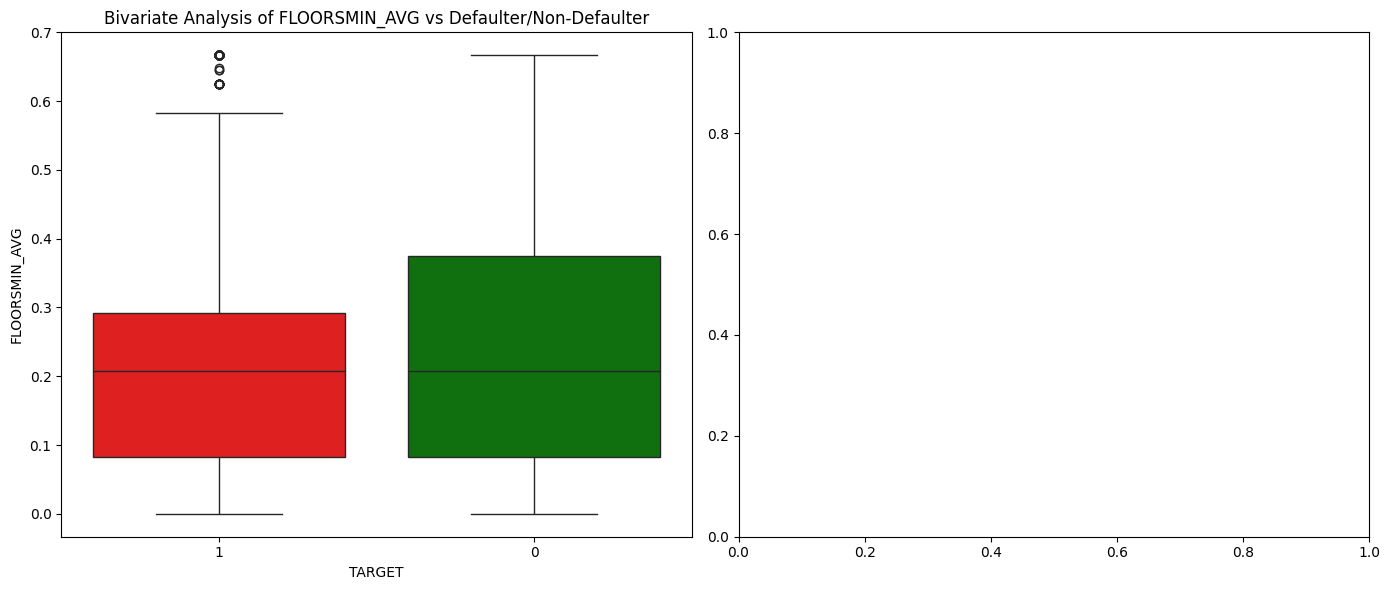

Feature: LANDAREA_AVG, Flag Column: FLAG_LANDAREA_AVG, Filtered Data Shape: (102995, 173)
Number of TARGET=0: 95314
Number of TARGET=1: 7681
Running bivariate analysis for LANDAREA_AVG
Normality Assessment for LANDAREA_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 88216.0208, p-value: 0.0000
Skewness: 1.6754
Kurtosis: 6.0542
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



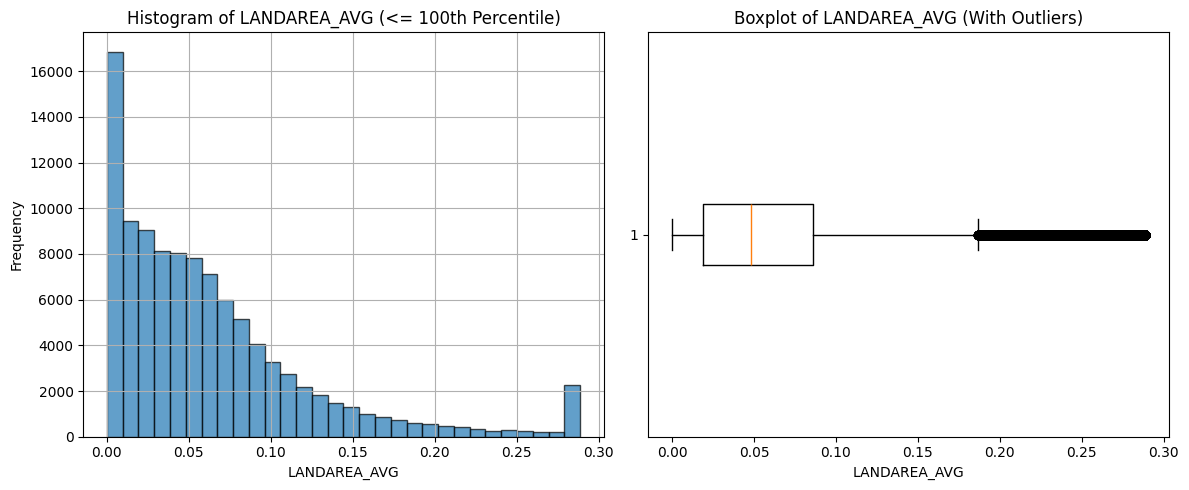

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.06352211217659526
Mean for target=1 (Defaulter): 0.06004297617497722
t-statistic: 4.708408109868606, p-value: 2.499832929582743e-06
There is a significant difference between the groups. 



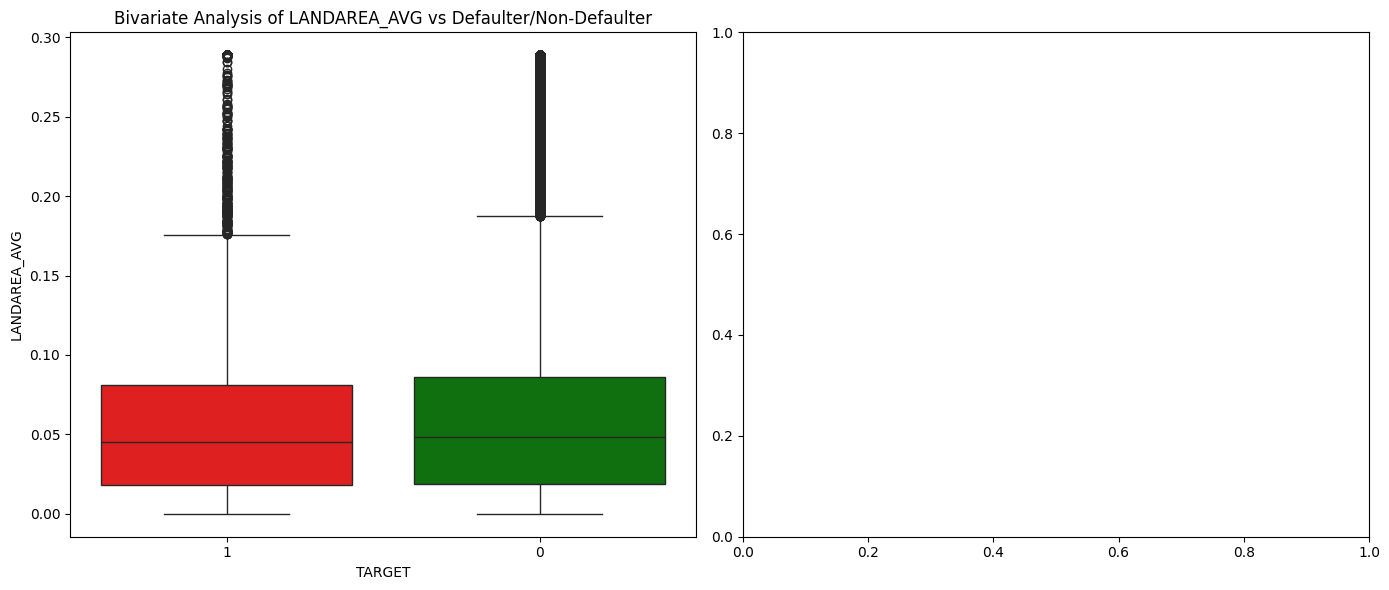

Feature: LIVINGAPARTMENTS_AVG, Flag Column: FLAG_LIVINGAPARTMENTS_AVG, Filtered Data Shape: (80073, 173)
Number of TARGET=0: 74181
Number of TARGET=1: 5892
Running bivariate analysis for LIVINGAPARTMENTS_AVG
Normality Assessment for LIVINGAPARTMENTS_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 49428.1871, p-value: 0.0000
Skewness: 1.5538
Kurtosis: 5.2711
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



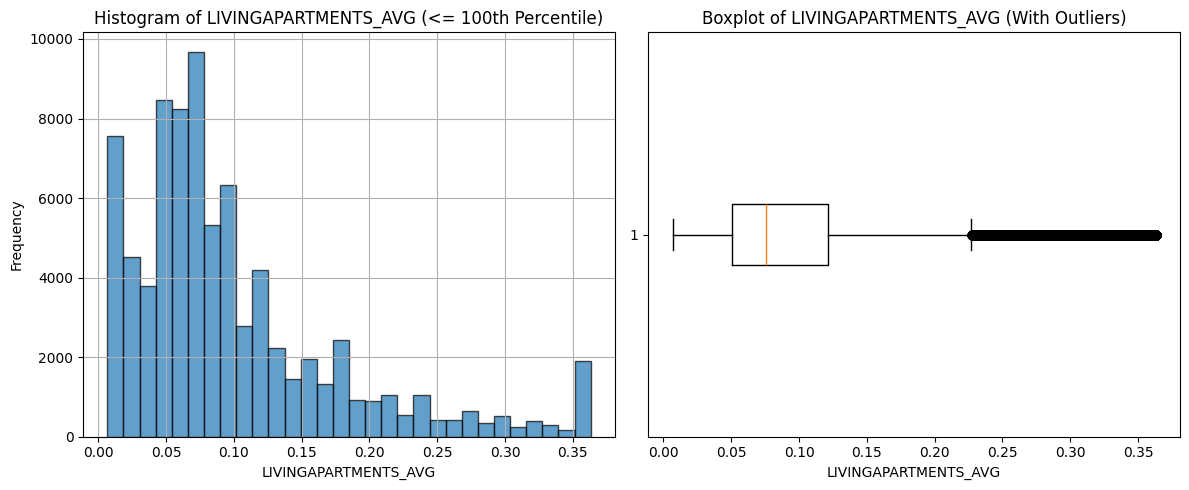

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.09946024453701081
Mean for target=1 (Defaulter): 0.08936096401900884
t-statistic: 9.454404574038348, p-value: 3.3325035637361253e-21
There is a significant difference between the groups. 



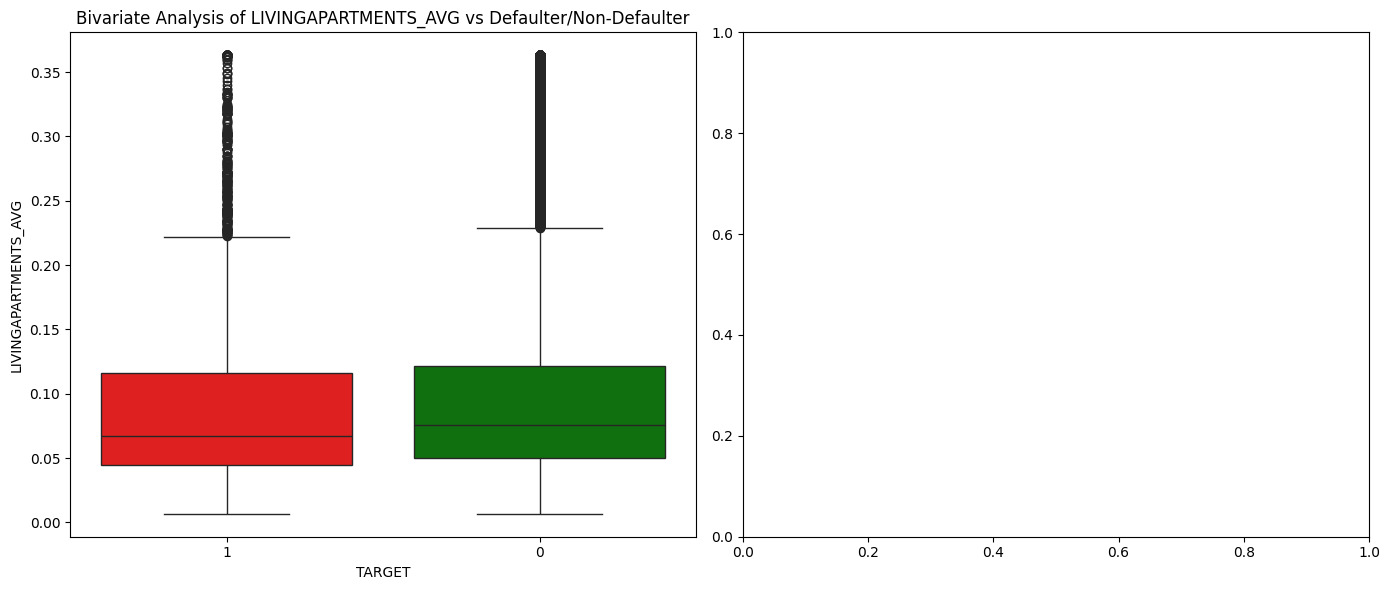

Feature: LIVINGAREA_AVG, Flag Column: FLAG_LIVINGAREA_AVG, Filtered Data Shape: (126224, 173)
Number of TARGET=0: 116818
Number of TARGET=1: 9406
Running bivariate analysis for LIVINGAREA_AVG
Normality Assessment for LIVINGAREA_AVG (<= 100th Percentile):
Jarque-Bera Statistic: 112294.2826, p-value: 0.0000
Skewness: 1.7576
Kurtosis: 5.9991
Conclusion: The data is likely not normally distributed (reject null hypothesis). 



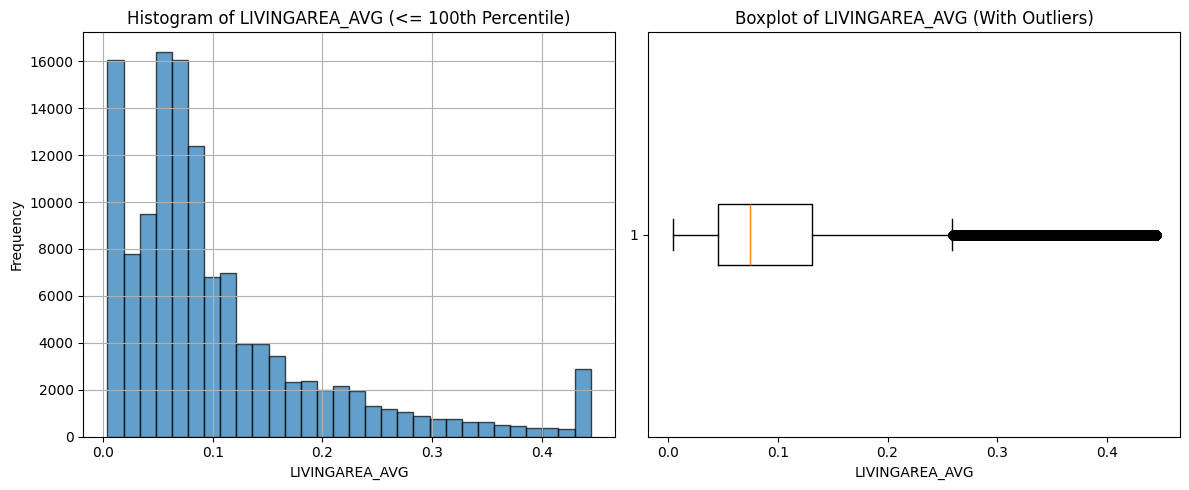

C:\Users\david\AppData\Local\Temp\ipykernel_4388\2502435203.py:141: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target, y=numerical_feature, data=filtered_df, palette=palette, ax=ax)


Percentile limit: 100th
Mean for target=0 (Non-Defaulter): 0.1059480259891455
Mean for target=1 (Defaulter): 0.0912533382947055
t-statistic: 14.275570585310287, p-value: 3.3761691293408587e-46
There is a significant difference between the groups. 



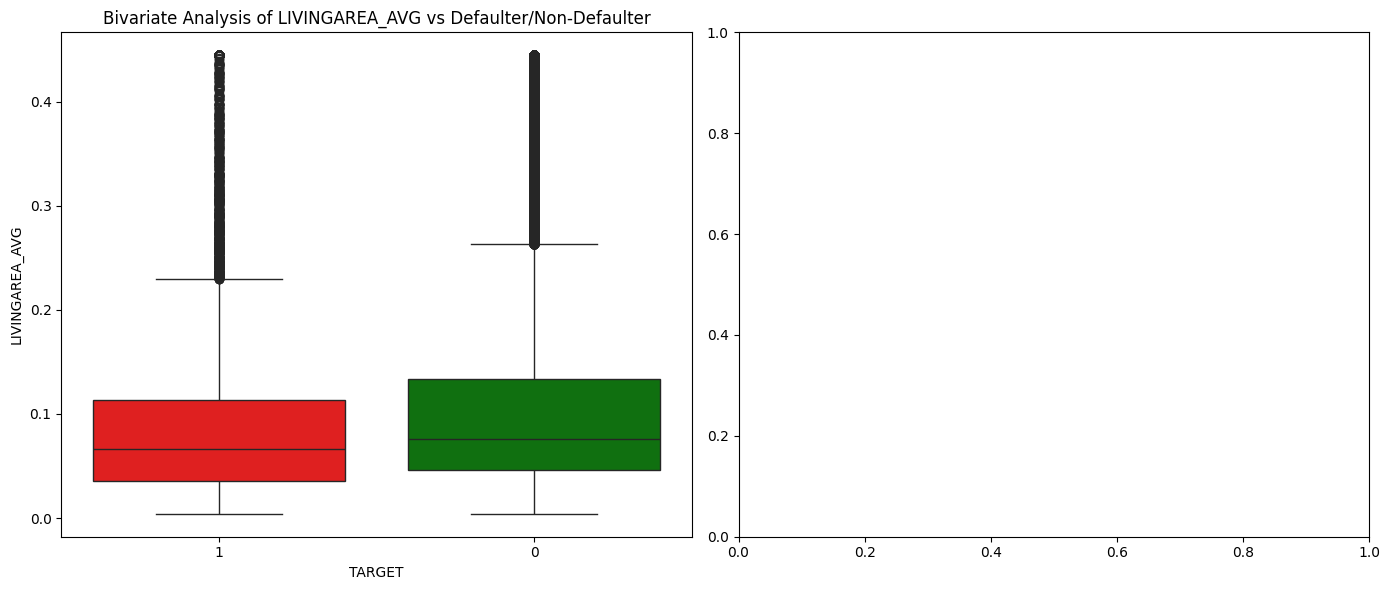

In [22]:
# Bivariate analysis function with custom colors and subplotting
# Due to how much housing data is imputed I'll be looking at only the data that was originally there, I do this by utilising the flag columns created earlier



#had to alter previous function due to axis issue

# List of property columns and their associated flag columns
property_columns_with_flags = {
    'APARTMENTS_AVG': 'FLAG_APARTMENTS_AVG',
    'BASEMENTAREA_AVG': 'FLAG_BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG': 'FLAG_YEARS_BEGINEXPLUATATION_AVG',
    'YEARS_BUILD_AVG': 'FLAG_YEARS_BUILD_AVG',
    'COMMONAREA_AVG': 'FLAG_COMMONAREA_AVG',
    'ELEVATORS_AVG': 'FLAG_ELEVATORS_AVG',
    'ENTRANCES_AVG': 'FLAG_ENTRANCES_AVG',
    'FLOORSMAX_AVG': 'FLAG_FLOORSMAX_AVG',
    'FLOORSMIN_AVG': 'FLAG_FLOORSMIN_AVG',
    'LANDAREA_AVG': 'FLAG_LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG': 'FLAG_LIVINGAPARTMENTS_AVG',
    'LIVINGAREA_AVG': 'FLAG_LIVINGAREA_AVG'
}

# Loop through each property column and its corresponding flag
for col, flag_col in property_columns_with_flags.items():
    # Filter the dataset for rows where the flag is 1 for this specific feature
    filtered_data = df_transformed[df_transformed[flag_col] == 1]
    
    # Debugging: Check if there are rows where the flag column is 1
    print(f"Feature: {col}, Flag Column: {flag_col}, Filtered Data Shape: {filtered_data.shape}")
    print(f"Number of TARGET=0: {filtered_data[filtered_data['TARGET'] == 0].shape[0]}")
    print(f"Number of TARGET=1: {filtered_data[filtered_data['TARGET'] == 1].shape[0]}")
    
    if not filtered_data.empty:  # Check if there's any data to analyze
        print(f"Running bivariate analysis for {col}")
        # Run the bivariate analysis
        numerical_analysis(filtered_data, col, 'TARGET', percentile=100)
    else:
        print(f"No valid data for {col} to run bivariate analysis.")

### Housing Features and Correlation to Defaulting

The bivariate analysis shows, with statistical significance, that defaulters tend to purchase **smaller properties**, including **basement areas**, **living spaces**, and **land areas**. This likely ties back to **income**, as smaller properties are generally cheaper, reflecting a similar pattern seen in the default rates across **AMT_GOODS_PRICE**.

---

### Key Insights:

1. **Smaller Properties, Financial Vulnerability**:
   Defaulters are more likely to have smaller properties, suggesting they are financially constrained. Lower-income borrowers may be more **vulnerable** to economic shocks or overextended with their loans.

2. **Loan Risk and Overextension**:
   Smaller homes may represent a higher proportion of a borrower’s income, increasing the risk of default. This suggests defaulters might be **financially overextending** themselves, even when purchasing smaller, less expensive homes.

3. **Lending Strategy**:
   Lenders should consider not just **income**, but also the size of the property in relation to the borrower’s financial capacity. **Smaller properties**, though cheaper, could represent a higher risk of default due to financial vulnerability.

---

### Additional Consideration:
It's possible that this pattern of **smaller properties** simply follows the broader relationship between **income**, **AMT_GOODS_PRICE**, **AMT_CREDIT**, and **AMT_ANNUITY**. Property size is priced into the housing market, so **smaller properties** naturally align with lower **loan amounts** and **goods prices**, making this an extension of the overall income-to-loan correlation. This suggests that the risk might be more a function of **overextending** relative to **income** rather than property size alone.


# Analysis of Categorical Features

In [23]:
#preparing categoricals for analysis by grouping low count categories into other
def print_category_counts(df):
    # Loop through all columns in the dataframe
    for column in df.columns:
        # Check if the column is categorical (or object type)
        if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
            print(f"\nCategory counts for '{column}':")
            print(df[column].value_counts().to_string())
# Example usage
print_category_counts(df_transformed)


C:\Users\david\AppData\Local\Temp\ipykernel_4388\4035319041.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
C:\Users\david\AppData\Local\Temp\ipykernel_4388\4035319041.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
C:\Users\david\AppData\Local\Temp\ipykernel_4388\4035319041.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
C:\Users\david\AppData\Local\Temp\ipykernel_4388\4035319041.py:6: DeprecationWarning: is_categorical_dtype is


Category counts for 'NAME_CONTRACT_TYPE':
NAME_CONTRACT_TYPE
Cash loans         226224
Revolving loans     25913

Category counts for 'CODE_GENDER':
CODE_GENDER
F      157177
M       94956
XNA         4

Category counts for 'FLAG_OWN_CAR':
FLAG_OWN_CAR
N    157719
Y     94418

Category counts for 'FLAG_OWN_REALTY':
FLAG_OWN_REALTY
Y    171082
N     81055

Category counts for 'NAME_TYPE_SUITE':
NAME_TYPE_SUITE
Unaccompanied      205018
Family              31659
Spouse, partner      9663
Children             2250
Other_B              1473
Unknown              1096
Other_A               762
Group of people       216

Category counts for 'NAME_INCOME_TYPE':
NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
State servant            21703
Student                     18
Pensioner                   10
Businessman                 10
Maternity leave              5

Category counts for 'NAME_EDUCATION_TYPE':
NAME_EDUCATION_TYPE
Secondary / secondary special    173286

C:\Users\david\AppData\Local\Temp\ipykernel_4388\4035319041.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
C:\Users\david\AppData\Local\Temp\ipykernel_4388\4035319041.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
C:\Users\david\AppData\Local\Temp\ipykernel_4388\4035319041.py:6: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df[column].dtype == 'object' or pd.api.types.is_categorical_dtype(df[column]):
C:\Users\david\AppData\Local\Temp\ipykernel_4388\4035319041.py:6: DeprecationWarning: is_categorical_dtype is

In [24]:
def aggregate_low_counts_to_other(df, threshold=100):
    """
    function that loops through categorical columns and aggregates categories with counts
    less than or equal to a given threshold into a new category called 'Other'.

    Args:
    df (DataFrame): The dataframe containing the data.
    threshold (int): The count threshold below which categories are aggregated into 'Other'.

    Returns:
    DataFrame: The updated dataframe with low count categories replaced by 'Other'.
    """
    df_copy = df.copy()
    
    # Loop through categorical columns only
    categorical_columns = df_copy.select_dtypes(include=['object', 'category']).columns

    for column in categorical_columns:
        # Use value_counts and map efficiently to avoid multiple passes
        value_counts = df_copy[column].value_counts()
        
        # Find categories to replace with 'Other'
        low_count_categories = value_counts[value_counts <= threshold].index
        
        # Use .where to replace values in one step
        df_copy[column] = df_copy[column].where(~df_copy[column].isin(low_count_categories), 'Other')
    
    return df_copy

#aggregating low counts
df_transformed = aggregate_low_counts_to_other(df_transformed)



Analyzing NAME_CONTRACT_TYPE...




NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64


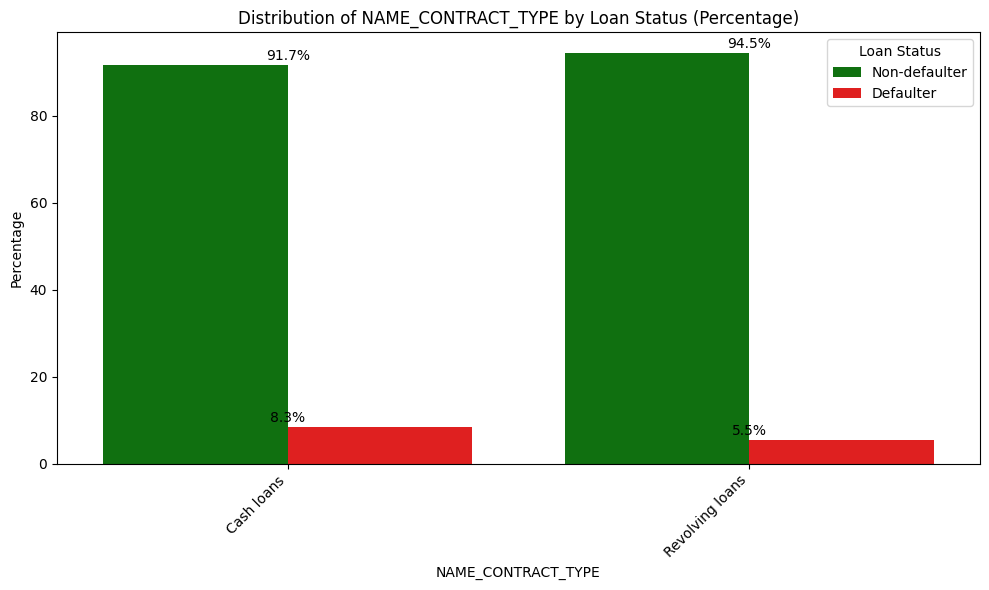

Chi-square Test for NAME_CONTRACT_TYPE:
Chi2 statistic: 293.1505, p-value: 0.0000, Degrees of freedom: 1
There is a significant difference between defaulters and non-defaulters for this variable (NAME_CONTRACT_TYPE).
Analyzing CODE_GENDER...




CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64


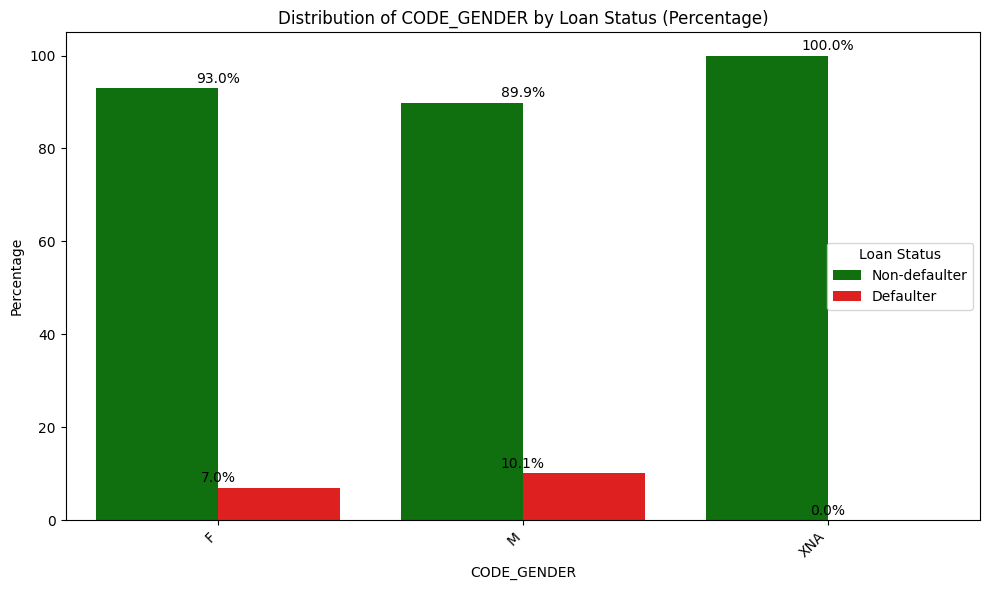

Chi-square Test for CODE_GENDER:
Chi2 statistic: 920.7913, p-value: 0.0000, Degrees of freedom: 2
There is a significant difference between defaulters and non-defaulters for this variable (CODE_GENDER).
Analyzing FLAG_OWN_CAR...




FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64


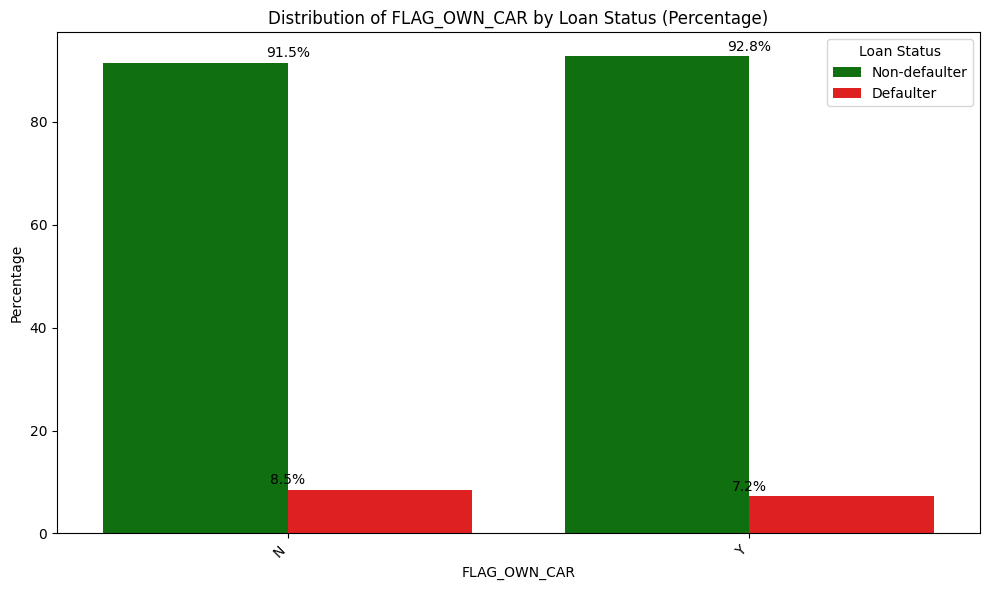

Chi-square Test for FLAG_OWN_CAR:
Chi2 statistic: 146.6560, p-value: 0.0000, Degrees of freedom: 1
There is a significant difference between defaulters and non-defaulters for this variable (FLAG_OWN_CAR).
Analyzing FLAG_OWN_REALTY...




FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64


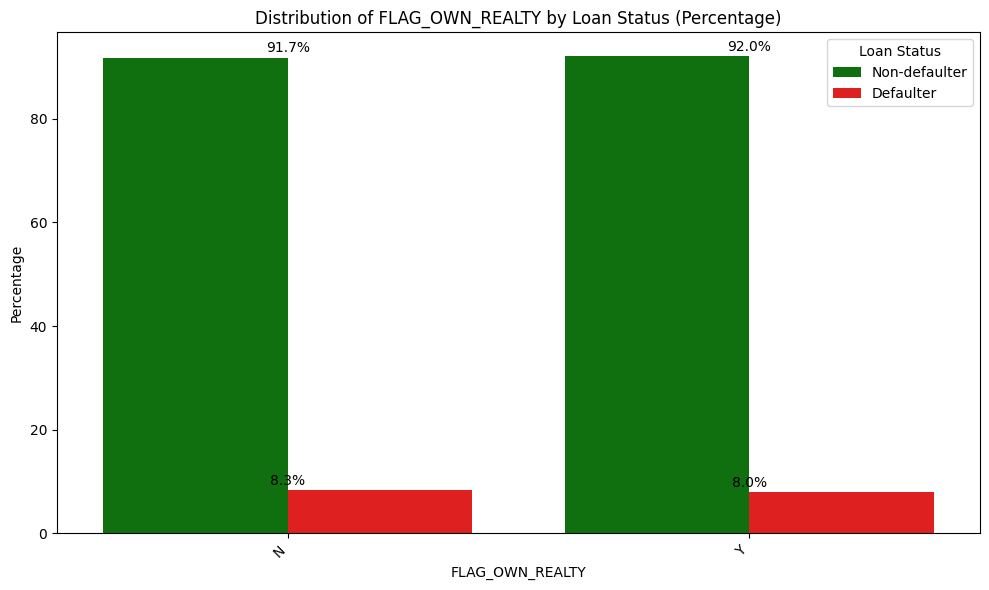

Chi-square Test for FLAG_OWN_REALTY:
Chi2 statistic: 11.5758, p-value: 0.0007, Degrees of freedom: 1
There is a significant difference between defaulters and non-defaulters for this variable (FLAG_OWN_REALTY).
Analyzing NAME_TYPE_SUITE...




NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64


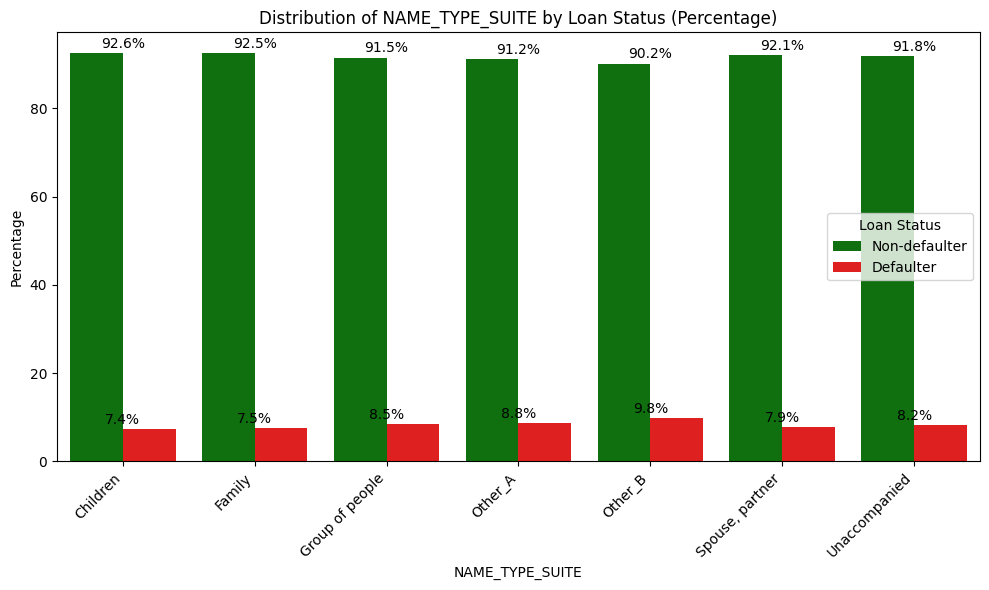

Chi-square Test for NAME_TYPE_SUITE:
Chi2 statistic: 32.8253, p-value: 0.0000, Degrees of freedom: 6
There is a significant difference between defaulters and non-defaulters for this variable (NAME_TYPE_SUITE).
Analyzing NAME_INCOME_TYPE...




NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64


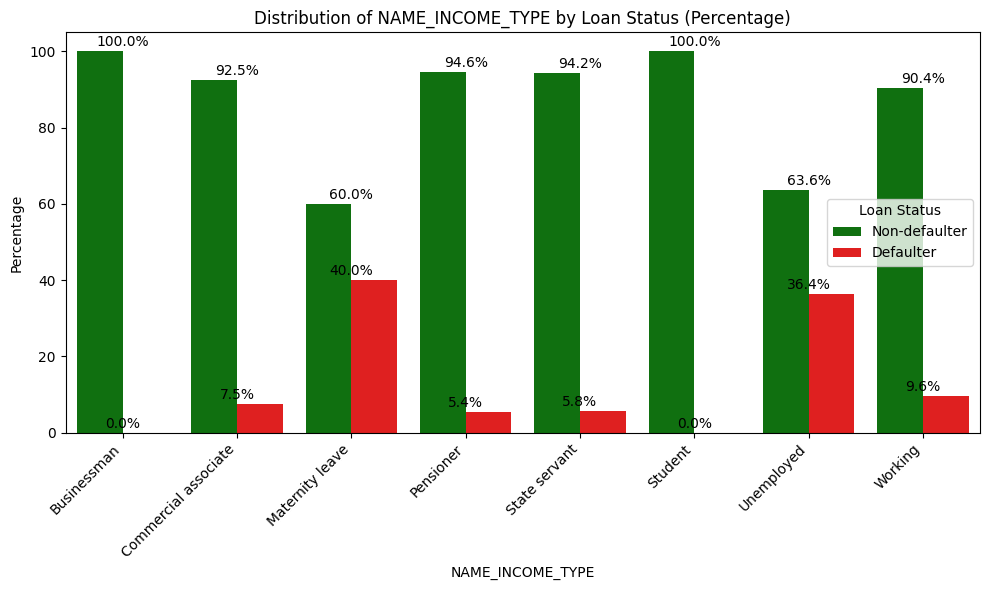

Chi-square Test for NAME_INCOME_TYPE:
Chi2 statistic: 1253.4708, p-value: 0.0000, Degrees of freedom: 7
There is a significant difference between defaulters and non-defaulters for this variable (NAME_INCOME_TYPE).
Analyzing NAME_EDUCATION_TYPE...




NAME_EDUCATION_TYPE
Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: count, dtype: int64


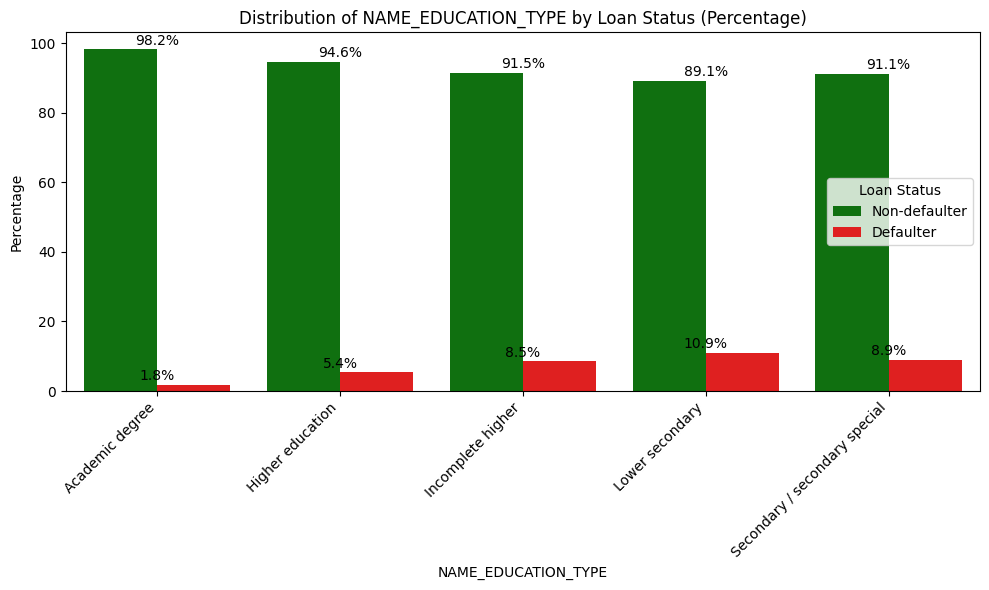

Chi-square Test for NAME_EDUCATION_TYPE:
Chi2 statistic: 1019.2132, p-value: 0.0000, Degrees of freedom: 4
There is a significant difference between defaulters and non-defaulters for this variable (NAME_EDUCATION_TYPE).
Analyzing NAME_FAMILY_STATUS...




NAME_FAMILY_STATUS
Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: count, dtype: int64


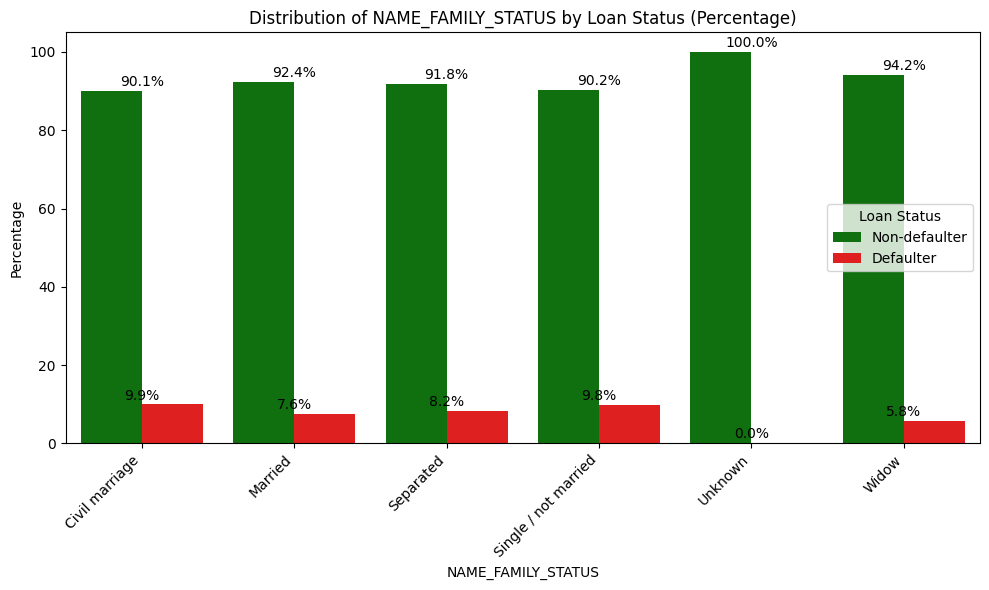

Chi-square Test for NAME_FAMILY_STATUS:
Chi2 statistic: 504.6941, p-value: 0.0000, Degrees of freedom: 5
There is a significant difference between defaulters and non-defaulters for this variable (NAME_FAMILY_STATUS).
Analyzing NAME_HOUSING_TYPE...




NAME_HOUSING_TYPE
House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: count, dtype: int64


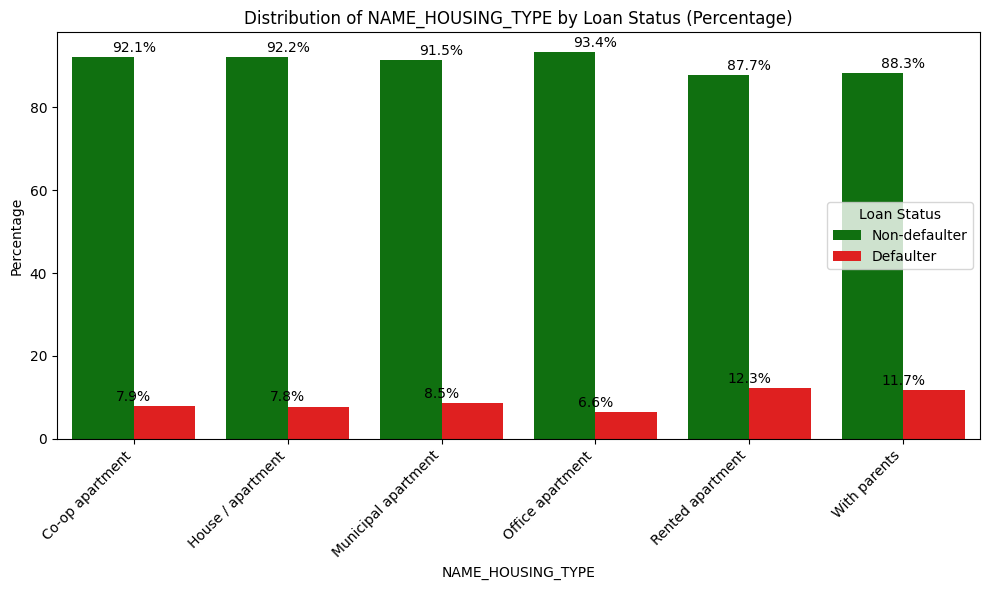

Chi-square Test for NAME_HOUSING_TYPE:
Chi2 statistic: 420.5562, p-value: 0.0000, Degrees of freedom: 5
There is a significant difference between defaulters and non-defaulters for this variable (NAME_HOUSING_TYPE).
Analyzing OCCUPATION_TYPE...




OCCUPATION_TYPE
Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: count, dtype: int64


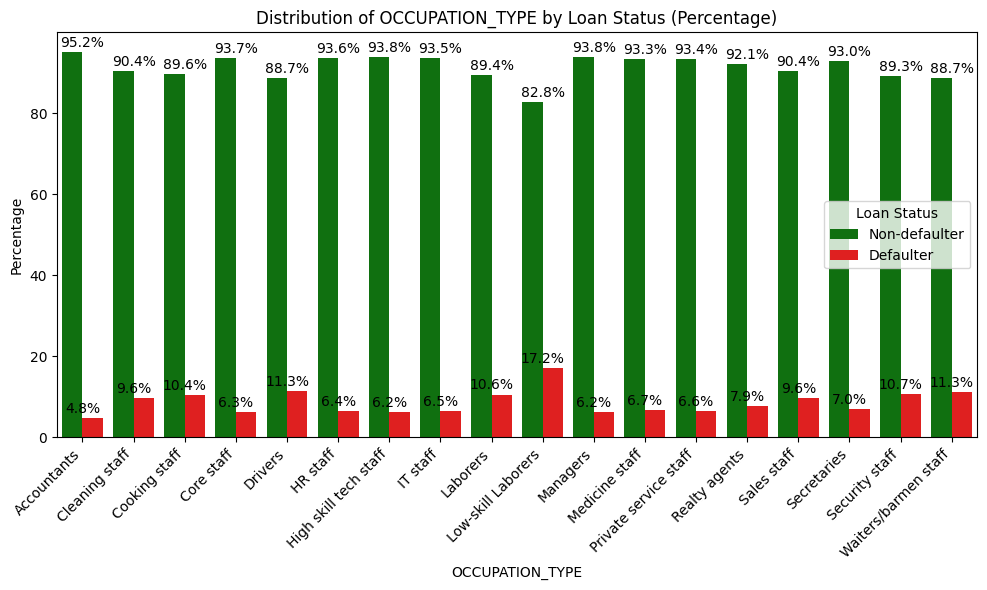

Chi-square Test for OCCUPATION_TYPE:
Chi2 statistic: 1402.8468, p-value: 0.0000, Degrees of freedom: 17
There is a significant difference between defaulters and non-defaulters for this variable (OCCUPATION_TYPE).
Analyzing WEEKDAY_APPR_PROCESS_START...




WEEKDAY_APPR_PROCESS_START
TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
SATURDAY     33852
SUNDAY       16181
Name: count, dtype: int64


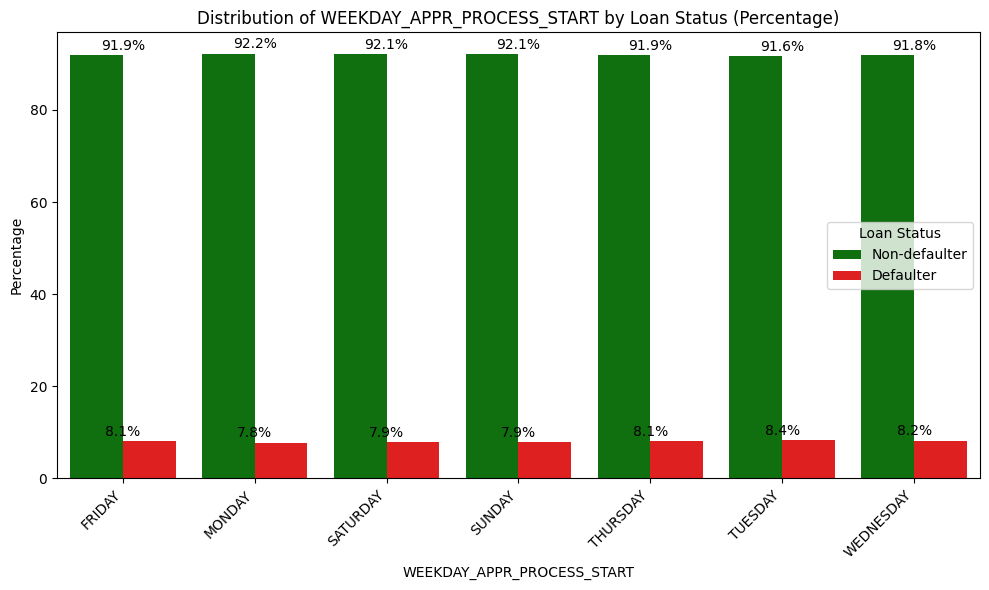

Chi-square Test for WEEKDAY_APPR_PROCESS_START:
Chi2 statistic: 15.3876, p-value: 0.0174, Degrees of freedom: 6
No significant difference between defaulters and non-defaulters for this variable (WEEKDAY_APPR_PROCESS_START).
Analyzing ORGANIZATION_TYPE...




ORGANIZATION_TYPE
Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6880
Construction               6721
Business Entity Type 1     5984
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3278
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police             

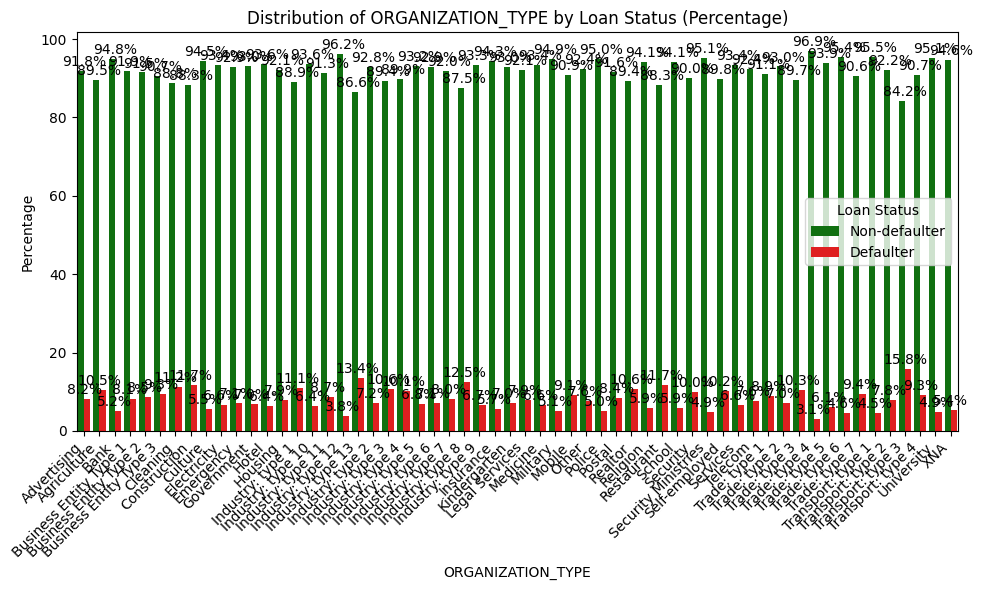

Chi-square Test for ORGANIZATION_TYPE:
Chi2 statistic: 1609.2406, p-value: 0.0000, Degrees of freedom: 57
There is a significant difference between defaulters and non-defaulters for this variable (ORGANIZATION_TYPE).
Analyzing FONDKAPREMONT_MODE...




FONDKAPREMONT_MODE
reg oper account         73830
reg oper spec account    12080
not specified             5687
org spec account          5619
Name: count, dtype: int64


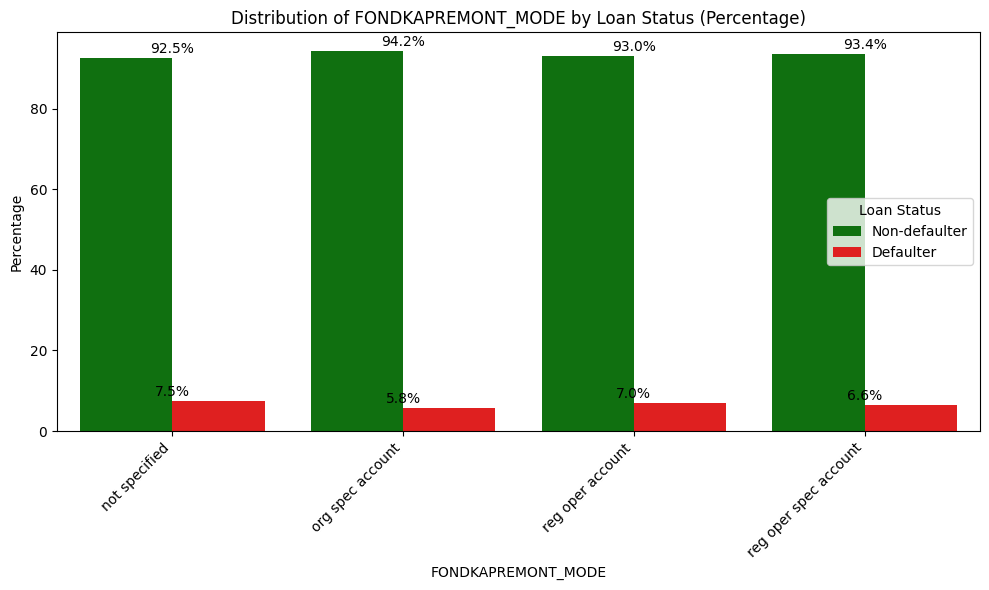

Chi-square Test for FONDKAPREMONT_MODE:
Chi2 statistic: 16.8099, p-value: 0.0008, Degrees of freedom: 3
There is a significant difference between defaulters and non-defaulters for this variable (FONDKAPREMONT_MODE).
Analyzing HOUSETYPE_MODE...




HOUSETYPE_MODE
block of flats      150503
specific housing      1499
terraced house        1212
Name: count, dtype: int64


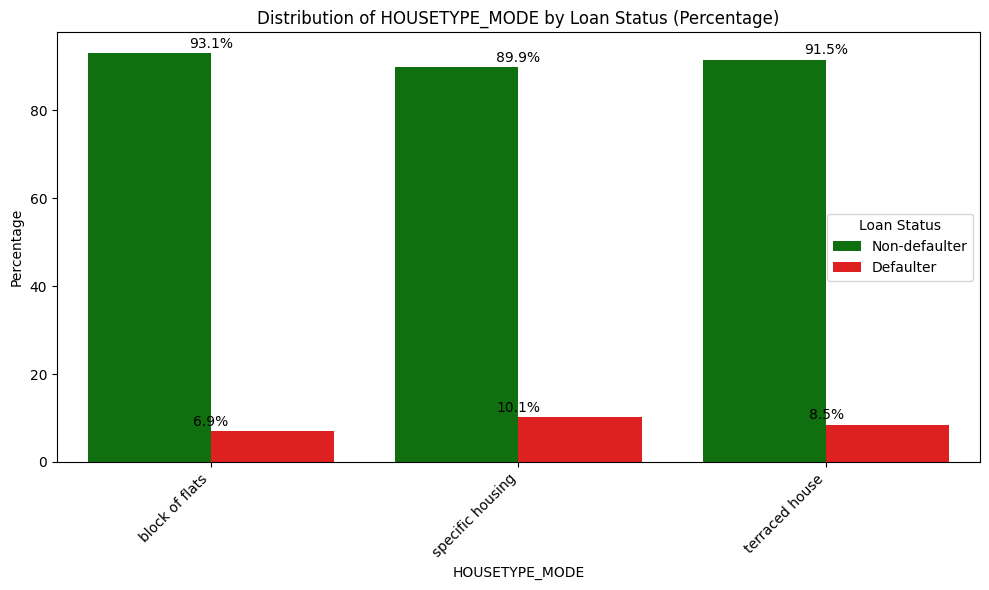

Chi-square Test for HOUSETYPE_MODE:
Chi2 statistic: 27.6326, p-value: 0.0000, Degrees of freedom: 2
There is a significant difference between defaulters and non-defaulters for this variable (HOUSETYPE_MODE).
Analyzing WALLSMATERIAL_MODE...




WALLSMATERIAL_MODE
Panel           66040
Stone, brick    64815
Block            9253
Wooden           5362
Mixed            2296
Monolithic       1779
Others           1625
Name: count, dtype: int64


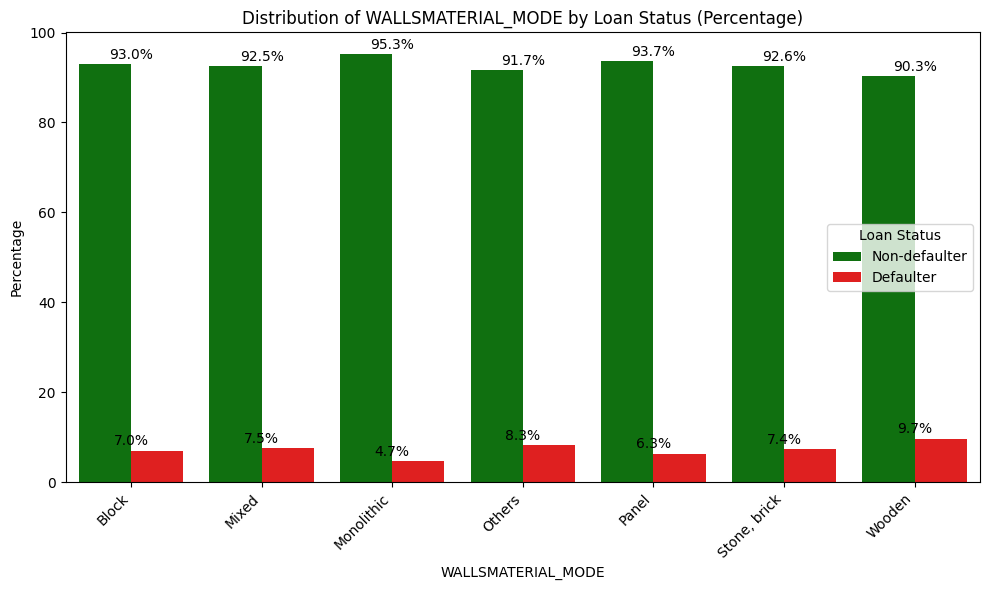

Chi-square Test for WALLSMATERIAL_MODE:
Chi2 statistic: 139.2353, p-value: 0.0000, Degrees of freedom: 6
There is a significant difference between defaulters and non-defaulters for this variable (WALLSMATERIAL_MODE).
Analyzing EMERGENCYSTATE_MODE...




EMERGENCYSTATE_MODE
No     159428
Yes      2328
Name: count, dtype: int64


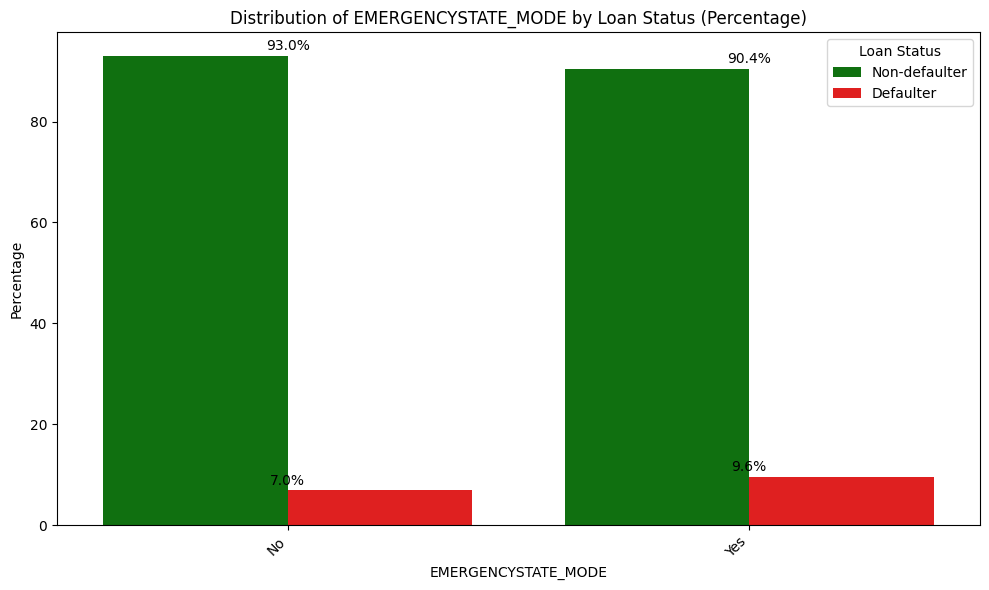

Chi-square Test for EMERGENCYSTATE_MODE:
Chi2 statistic: 23.6782, p-value: 0.0000, Degrees of freedom: 1
There is a significant difference between defaulters and non-defaulters for this variable (EMERGENCYSTATE_MODE).

Summary of significant variables in relation to the target:
['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def plot_categorical_distribution(df, column_name, target='TARGET'):
    """Plots the distribution of a categorical feature against the target variable with percentages."""
    print("\n" * 3)
    print(df[column_name].value_counts())
    
    # Create a normalized crosstab to calculate the percentages
    percentages = pd.crosstab(df[column_name], df[target], normalize='index') * 100
    
    # Reshape the data for plotting
    percentages = percentages.reset_index().melt(
        id_vars=column_name, 
        value_vars=[0, 1], 
        var_name='Loan Status', 
        value_name='Percentage'
    )
    
    # Map the values for better readability
    percentages['Loan Status'] = percentages['Loan Status'].map({0: 'Non-defaulter', 1: 'Defaulter'})
    
    # Create a bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=column_name, 
        y='Percentage', 
        hue='Loan Status', 
        data=percentages, 
        palette={'Non-defaulter': 'green', 'Defaulter': 'red'}
    )
    
    # Add percentages on top of the bars
    for index, row in percentages.iterrows():
        plt.text(
            x=index % len(percentages[column_name].unique()), 
            y=row['Percentage'] + 0.5,  # Adjust for better visibility
            s=f"{row['Percentage']:.1f}%", 
            ha='center', 
            va='bottom'
        )
    
    plt.title(f'Distribution of {column_name} by Loan Status (Percentage)')
    plt.xlabel(column_name)
    plt.ylabel('Percentage')
    plt.legend(title='Loan Status')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def chi_square_test(df, column_name, target='TARGET'):
    """Performs a chi-square test of independence between a categorical feature and the target."""
    # Create a contingency table
    contingency_table = pd.crosstab(df[column_name], df[target])
    
    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    return chi2, p, dof, expected

def categorical_analysis(df, column_name, target='TARGET', significance_level=0.05):
    """Runs both plotting and chi-square test on a single column."""
    plot_categorical_distribution(df, column_name, target)
    
    chi2, p, dof, expected = chi_square_test(df, column_name, target)
    
    print(f'Chi-square Test for {column_name}:')
    print(f'Chi2 statistic: {chi2:.4f}, p-value: {p:.4f}, Degrees of freedom: {dof}')
    
    # Check if the result is statistically significant
    is_significant = p < significance_level
    if is_significant:
        print(f"There is a significant difference between defaulters and non-defaulters for this variable ({column_name}).")
    else:
        print(f"No significant difference between defaulters and non-defaulters for this variable ({column_name}).")
    
    return is_significant

def summarize_categorical_analysis(df, target='TARGET', significance_level=0.05):
    """
    Loops through all categorical columns, performs analysis, and returns
    columns that are statistically significant in relation to the target.
    """
    significant_columns = []
    
    # Select categorical columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    for column in categorical_columns:
        print(f"Analyzing {column}...")
        
        # Perform the analysis for each categorical column
        is_significant = categorical_analysis(df, column, target, significance_level)
        
        # If significant, add to the list
        if is_significant:
            significant_columns.append(column)
    
    print("\nSummary of significant variables in relation to the target:")
    print(significant_columns if significant_columns else "No statistically significant variables found.")
    
    return significant_columns

# Example usage:
significant_columns = summarize_categorical_analysis(df, target='TARGET', significance_level=0.01)


## Significant Categorical Features

In this stage of the analysis, I applied a mass feature selection technique, specifically a **t-test** between groups (defaulters and non-defaulters), to assess the relevance of categorical variables in predicting the target variable (default risk). Through this process, I identified several categorical features that showed a statistically significant relationship with the target.

---

#### Process:
- A t-test was applied to evaluate the relationship between each categorical feature and the target variable, testing for significant differences between defaulters and non-defaulters.
- The selection process involved identifying features with statistically significant differences (based on p-values), highlighting those that demonstrated strong correlations with default risk.

---

#### Results:
The following features were identified as being significantly associated with the target variable:

- **Personal Demographics**:
  - Features such as **gender**, **education level**, **family status**, and **occupation type** demonstrated significant relationships with default risk, indicating that personal characteristics influence the likelihood of default.

- **Financial & Ownership Information**:
  - Variables related to **contract types**, **car ownership**, **real estate ownership**, and **housing type** were relevant, suggesting that financial behaviors and asset ownership are key indicators of creditworthiness.



- **Property & Housing Characteristics**:
  - **Housing details**, such as the type of house, wall materials, and eligibility for repairs, were strongly correlated with default, suggesting that property characteristics reflect the financial stability of the applicant.

- **Risk & Emergency Indicators**:
  - The **emergency state** of the applicant was notably significant, further supporting the idea that applicants under financial stress are at higher risk of defaulting.

---

#### Interpretation:
- This analysis highlights the importance of both **personal** and **financial characteristics** in predicting default risk, with features related to income, family, and asset ownership proving particularly influential.
- **Housing characteristics** and **emergency status** are important indicators of financial vulnerability, serving as potential early warning signals for default.

---

#### Next Steps:
- These significant features will be incorporated into further modeling and analysis to better understand their impact on default prediction.
- Additional focus will be placed on exploring potential interactions between these variables to refine the credit risk model.


# Creating Encoding Pipeline

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Function wrapped in a transforme
class AggregateLowCounts(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=100):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Loop through categorical columns only
        categorical_columns = X.select_dtypes(include=['object', 'category']).columns
        for column in categorical_columns:
            # Use value_counts and map efficiently to avoid multiple passes
            value_counts = X[column].value_counts()
            
            # Find categories to replace with 'Other'
            low_count_categories = value_counts[value_counts <= self.threshold].index
            
            # Replace low count categories with 'Other'
            X[column] = X[column].where(~X[column].isin(low_count_categories), 'Other')
        
        return X

# Custom transformer for binary encoding
class EncodeBinaryVariables(BaseEstimator, TransformerMixin):
    def __init__(self, binary_columns):
        self.binary_columns = binary_columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        label_encoder = LabelEncoder()
        
        for col in self.binary_columns:
            if col in X.columns:  # Check if column exists
                X[col] = label_encoder.fit_transform(X[col])
        
        return X

# Custom transformer for ordinal encoding
class EncodeOrdinalVariables(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_column, mapping_dict, default_value=None):
        self.ordinal_column = ordinal_column
        self.mapping_dict = mapping_dict
        self.default_value = default_value
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        if self.ordinal_column in X.columns:  # Check if column exists
            X[self.ordinal_column] = X[self.ordinal_column].map(self.mapping_dict)
            if self.default_value is not None:
                X[self.ordinal_column] = X[self.ordinal_column].fillna(self.default_value)
        
        return X

# Custom transformer for nominal encoding
class EncodeNominalVariables(BaseEstimator, TransformerMixin):
    def __init__(self, nominal_columns, drop_first=True):
        self.nominal_columns = nominal_columns
        self.drop_first = drop_first
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Only apply get_dummies if the columns are still in the DataFrame
        for col in self.nominal_columns:
            if col in X.columns:
                X = pd.get_dummies(X, columns=[col], drop_first=self.drop_first)
        
        return X

# Define columns for encoding
binary_columns = ['CODE_GENDER', 'FLAG_OWN_REALTY', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR']
ordinal_mapping = {
    'Lower secondary': 1,
    'Secondary / secondary special': 2,
    'Incomplete higher': 3,
    'Higher education': 4,
    'Academic degree': 5
}
nominal_columns = [
    'NAME_TYPE_SUITE', 
    'NAME_INCOME_TYPE', 
    'NAME_FAMILY_STATUS', 
    'NAME_HOUSING_TYPE', 
    'ORGANIZATION_TYPE', 
    'OCCUPATION_TYPE',
    'WEEKDAY_APPR_PROCESS_START',
    'FONDKAPREMONT_MODE',        
    'HOUSETYPE_MODE',            
    'WALLSMATERIAL_MODE',        
    'EMERGENCYSTATE_MODE'        
]

# Create the pipeline with the new aggregation step
encoding_pipeline = Pipeline(steps=[
    ('aggregate_low_counts', AggregateLowCounts(threshold=100)),
    ('binary_encoder', EncodeBinaryVariables(binary_columns=binary_columns)),
    ('ordinal_encoder', EncodeOrdinalVariables(ordinal_column='NAME_EDUCATION_TYPE', mapping_dict=ordinal_mapping, default_value=0)),
    ('nominal_encoder', EncodeNominalVariables(nominal_columns=nominal_columns))
])

# Apply the pipeline to the DataFrame
final_df = encoding_pipeline.fit_transform(df_transformed)

final_df.head()


SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0                1             0          202500.0    406597.5      24700.5   
1                0             0          270000.0   1293502.5      35698.5   
2                1             0           67500.0    135000.0       6750.0   
3                1             0          135000.0    312682.5      29686.5   
4                1             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE  NAME_EDUCATION_TYPE  REGION_POPULATION_RELATIVE  \
0         351000.0                    2                    0.018801   
1        1129500.0                    4                    0.003541   
2         135000.0                    2                    0.010032   
3         297000.0                    2                    0.008019   
4         513000.0                    2                    0.028663   

   DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  \
0        9461            637             3648.0             2120          9.0   
1       16765           1188             1186.0              291          9.0   
2       19046            225             4260.0             2531         26.0   
3       19005           3039             9833.0             2437          9.0   
4       19932           3038             4311.0             3458          9.0   

   FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0           1               1                0                 1           1   
1           1               1                0                 1           1   
2           1               1                1                 1           1   
3           1               1                0                 1           0   
4           1               1                0                 1           0   

   FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
0           0              1.0                     2   
1           0              2.0                     1   
2           0              1.0                     2   
3           0              2.0                     2   
4           0              1.0                     2   

   REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                            2                       10   
1                            1                       11   
2                            2                        9   
3                            2                       17   
4                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.110348   
1                       0                        0      0.311267   
2                       0                        0      0.505998   
3                   

# Feature Selection and Aggregation Strategy

---

### 1. Goal: Reduce the Number of Columns

The primary goal of this step is to reduce the number of columns in our dataset. With so many features, many of which may have limited predictive power, simplifying the dataset will make the model more efficient and interpretable, and reduce the risk of overfitting.

### 2. Approach: Using a Random Forest Classifier for Feature Importance

To identify which features are most predictive of credit risk, I will use a **Random Forest classifier** to rank feature importance. Random Forest is ideal here because it can handle complex datasets, works well with mixed data types, and captures nonlinear relationships. This process will allow me to isolate the top 30 most informative features, which I’ll retain for more extensive feature engineering in the next steps. This selection will give a solid foundation to build upon, focusing on features that already show strong predictive potential.

### 3. Retaining Information from Low-Importance Features through Aggregation

For the remaining features with lower importance scores, I won’t discard them entirely. Instead, I will **aggregate these low-importance features** to capture any underlying patterns without keeping each feature individually. By summing, averaging, or creating indices from similar features (e.g., flags or stability indicators), I’ll retain their informational value while simplifying the dataset. This nuanced approach allows me to maintain valuable data signals, even if individual features aren’t highly predictive, supporting the model's overall robustness.

---

This strategy enables a balanced approach to feature selection, where I prioritize high-impact features for further feature engineering while still retaining value from less-informative features through aggregation. This setup provides a focused and manageable dataset that is well-prepared for deeper analysis and engineering.



In [29]:
for col in final_df.columns:
    print(col)

SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_EDUCATION_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APARTMENTS_MODE
BASEMENTAREA_MODE
YEARS_BEGINEXPLUATATION_MODE
YEARS_BUILD_MODE
COMMONAREA_MODE
ELEVATORS_MODE
ENTRANCES_MODE
FLOORSMAX_

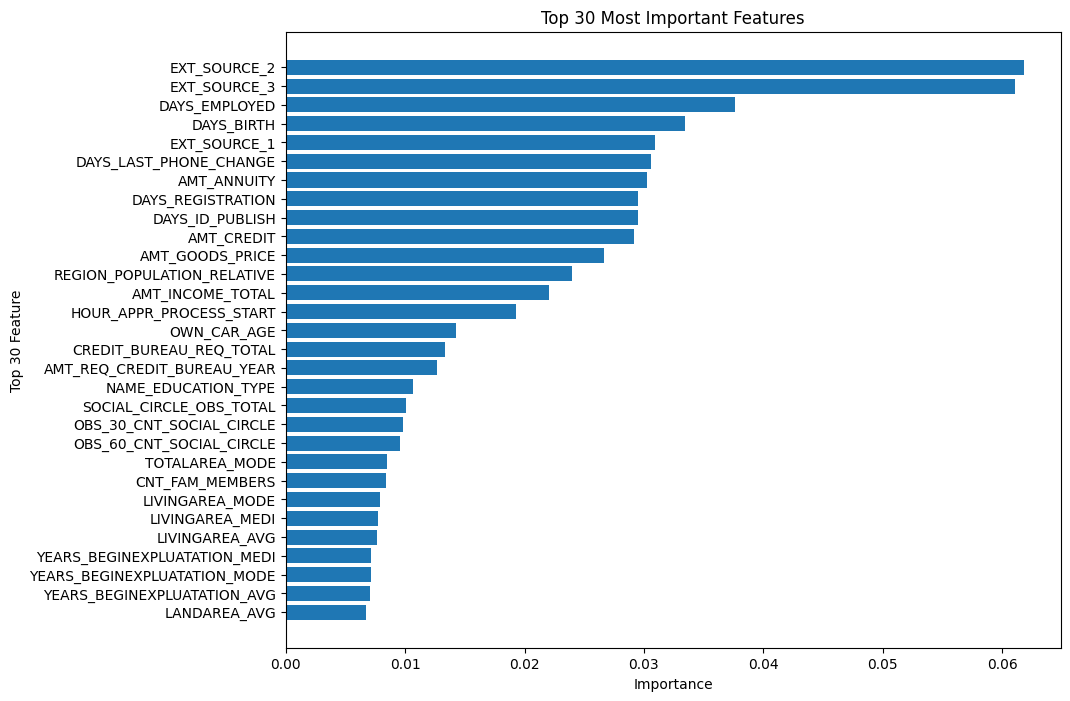

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

# Define features and target
X = final_df.drop(columns=['TARGET', 'SK_ID_CURR', "bin"])
y = final_df['TARGET']

# Identify categorical columns in X
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply OneHotEncoder to categorical columns
X = pd.get_dummies(X, columns=categorical_cols)

# Train the Random Forest Classifier with class weight adjustment for imbalance
model = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
model.fit(X, y)

# Get feature importances and create a DataFrame
feature_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Split into top 30 features and the rest
top_30_features = feature_importances.head(30)
remaining_features = feature_importances.iloc[30:]
# Plot Top 30 Features
plt.figure(figsize=(10, 8))
plt.barh(top_30_features['feature'], top_30_features['importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Top 30 Feature')
plt.title('Top 30 Most Important Features in the Application Dataset')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show() 



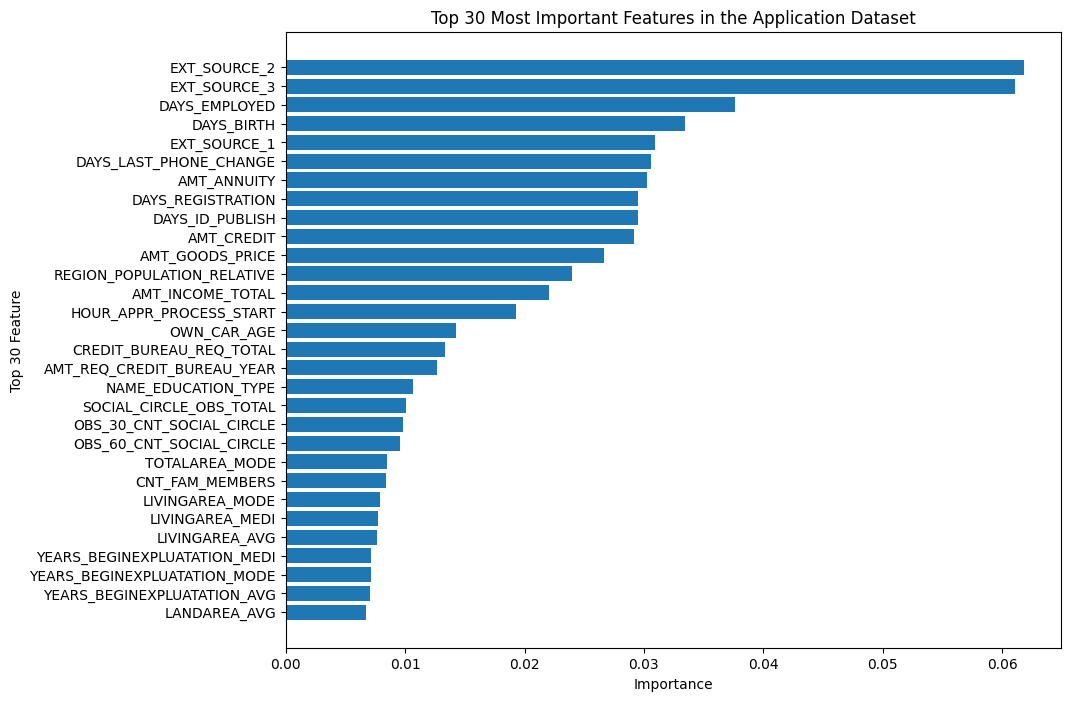

In [31]:
# Plot Top 30 Features
plt.figure(figsize=(10, 8))
plt.barh(top_30_features['feature'], top_30_features['importance'], align='center')
plt.xlabel('Importance')
plt.ylabel('Top 30 Feature')
plt.title('Top 30 Most Important Features in the Application Dataset')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()


## Analysis of Top 30 Most Important Features for Loan Application Data

---

The Random Forest feature importance analysis provides insights into the factors most relevant for assessing credit risk in loan applications. The top 30 features highlight critical aspects of applicants' demographics, credit history, and financial stability, which are likely to influence their likelihood of default.

### Key Observations

1. **External Risk Scores**:
   - `EXT_SOURCE_2`, `EXT_SOURCE_3`, and `EXT_SOURCE_1` are among the highest-ranked features. These external sources likely aggregate various financial and behavioral data into a single score, providing a reliable summary of the applicant's overall risk. The strong weighting of these features suggests that external risk assessments play a significant role in credit decisions.

2. **Age and Stability Indicators**:
   - `DAYS_BIRTH`, `DAYS_ID_PUBLISH`, and `DAYS_REGISTRATION` capture the applicant's age and duration of ID issuance and registration. These indicators are generally associated with stability, with older applicants or those with longer registration durations often seen as lower risk. This suggests that applicants with more stable backgrounds may be less likely to default.

3. **Employment and Financial Health**:
   - Features such as `DAYS_EMPLOYED` and `AMT_ANNUITY` provide insight into the applicant’s employment history and regular payment obligations. Longer employment durations and manageable annuities typically correlate with financial stability, indicating a lower likelihood of default.

4. **Credit and Income**:
   - Variables like `AMT_CREDIT`, `AMT_INCOME_TOTAL`, and `AMT_GOODS_PRICE` are essential indicators of the applicant’s financial capacity relative to the loan amount. High income relative to credit and affordable goods prices are positive signals, while applicants who require larger loans relative to their income may be viewed as higher risk.

5. **Geographic and Residential Factors**:
   - Features like `REGION_POPULATION_RELATIVE`, `LIVINGAREA_AVG`, and `LANDAREA_AVG` reflect aspects of the applicant's residence and area characteristics. Applicants from less populated areas or those with substantial assets in housing may be viewed as more financially stable. Residential stability, often associated with lower risk, is reflected in these variables.

6. **Credit Inquiry and Previous Defaults**:
   - `CREDIT_BUREAU_REQ_TOTAL` and `AMT_REQ_CREDIT_BUREAU_YEAR` capture the number of inquiries made by credit bureaus. High inquiry counts can indicate credit-seeking behavior or financial distress, which are typically associated with elevated risk.

7. **Social Circle and Dependents**:
   - Indicators such as `OBS_30_CNT_SOCIAL_CIRCLE` and `SOCIAL_CIRCLE_OBS_TOTAL` reflect social interactions and networks, which may correlate with risk through social and economic factors. Additionally, `CNT_FAM_MEMBERS` suggests that applicants with more dependents could face higher financial pressure, influencing their risk profile.
   

8. **Absence of Categoricals**:
   - Few encoded categorical variables made it to the top 30, this is indicative that alone these aren't great predictors however I still believe they could be useful as interaction terms with other variables, group membership is not a determining factor but perhaps how people differ to others within their group could be a good predictor for instance if someone earns unusually low for their education level, it could be a sign of heightened default risk, hence I will be leaving the top categorical variables which i will later use to engineer interaction terms with.
---

### Conclusion

The top 30 features highlight a diverse set of predictors, from external risk scores and demographic stability indicators to credit, residential, and social factors. This analysis underscores that applicants’ **financial stability**, **employment history**, and **external risk assessments** are among the most crucial factors in predicting credit risk. By focusing on these features, we gain a well-rounded view of creditworthiness, which is instrumental for further feature engineerin


In [136]:
# Display the remaining features as a ranked list by importance
print("Remaining Features Ranked by Importance")
display(remaining_features)


Remaining Features Ranked by Importance


feature    importance
65               YEARS_BEGINEXPLUATATION_MEDI  6.923071e-03
72                              LANDAREA_MEDI  6.564428e-03
63                            APARTMENTS_MEDI  6.453466e-03
58                              LANDAREA_MODE  6.444971e-03
35                             APARTMENTS_AVG  6.427688e-03
44                               LANDAREA_AVG  6.345724e-03
50                          BASEMENTAREA_MODE  6.144859e-03
64                          BASEMENTAREA_MEDI  6.117260e-03
36                           BASEMENTAREA_AVG  6.080951e-03
49                            APARTMENTS_MODE  6.066506e-03
4                                CNT_CHILDREN  6.000720e-03
1                                 CODE_GENDER  5.946244e-03
24                REGION_RATING_CLIENT_W_CITY  5.363319e-03
48                          NONLIVINGAREA_AVG  5.095954e-03
67                            COMMONAREA_MEDI  5.035182e-03
76                         NONLIVINGAREA_MEDI  5.002331e-03
23                       REGION_RATING_CLIENT  4.980372e-03
39                             COMMONAREA_AVG  4.965261e-03
53                            COMMONAREA_MODE  4.888348e-03
168                  NAME_INCOME_TYPE_Working  4.795257e-03
62                         NONLIVINGAREA_MODE  4.656552e-03
52                           YEARS_BUILD_MODE  4.566962e-03
38                            YEARS_BUILD_AVG  4.509865e-03
107                 AMT_REQ_CREDIT_BUREAU_QRT  4.491669e-03
3                             FLAG_OWN_REALTY  4.459366e-03
66                           YEARS_BUILD_MEDI  4.398271e-03
2                                FLAG_OWN_CAR  4.371833e-03
84                            FLAG_DOCUMENT_3  4.340272e-03
153                         FLAG_EXT_SOURCE_1  4.311337e-03
169                NAME_FAMILY_STATUS_Married  4.213644e-03
59                      LIVINGAPARTMENTS_MODE  4.197788e-03
45                       LIVINGAPARTMENTS_AVG  4.161533e-03
18                            FLAG_WORK_PHONE  4.148321e-03
20                                 FLAG_PHONE  4.145443e-03
183  ORGANIZATION_TYPE_Business Entity Type 3  4.135104e-03
73                      LIVINGAPARTMENTS_MEDI  4.093341e-03
237                  OCCUPATION_TYPE_Laborers  3.952052e-03
30                     REG_CITY_NOT_WORK_CITY  3.871419e-03
106                 AMT_REQ_CREDIT_BUREAU_MON  3.821975e-03
41                              ENTRANCES_AVG  3.732742e-03
252        WEEKDAY_APPR_PROCESS_START_TUESDAY  3.722756e-03
217           ORGANIZATION_TYPE_Self-employed  3.711995e-03
158                   SOCIAL_CIRCLE_DEF_TOTAL  3.693304e-03
31                    LIVE_CITY_NOT_WORK_CITY  3.683571e-03
267                                bin_25-50%  3.671306e-03
253      WEEKDAY_APPR_PROCESS_START_WEDNESDAY  3.627622e-03
251       WEEKDAY_APPR_PROCESS_START_THURSDAY  3.610923e-03
164             NAME_TYPE_SUITE_Unaccompanied  3.585141e-03
248         WEEKDAY_APPR_PROCESS_START_MONDAY  3.578814e-03
268                                bin_50-75%  3.567304e-03
246                   OCCUPATION_TYPE_Unknown  3.461728e-03
69                             ENTRANCES_MEDI  3.398869e-03
55                             ENTRANCES_MODE  3.252835e-03
243               OCCUPATION_TYPE_Sales staff  3.207859e-03
79                   DEF_30_CNT_SOCIAL_CIRCLE  3.076971e-03
172   NAME_FAMILY_STATUS_Single / not married  3.031864e-03
159                    NAME_TYPE_SUITE_Family  3.021525e-03
174       NAME_HOUSING_TYPE_House / apartment  2.967538e-03
232                OCCUPATION_TYPE_Core staff  2.932481e-03
29                     REG_CITY_NOT_LIVE_CITY  2.919027e-03
249       WEEKDAY_APPR_PROCESS_START_SATURDAY  2.902319e-03
0                          NAME_CONTRACT_TYPE  2.847502e-03
155                         FLAG_EXT_SOURCE_3  2.813395e-03
70                             FLOORSMAX_MEDI  2.799571e-03
42                              FLOORSMAX_AVG  2.746686e-03
233                   OCCUPATION_TYPE_Drivers  2.516157e-03
56                

# Creating the reduced df 

In [137]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline


# Custom transformer to select top features
class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, top_features):
        self.top_features = top_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.top_features]


# Custom transformer to create aggregated indexes
class Aggregator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create a new DataFrame with aggregated columns
        aggregated_df = pd.DataFrame(index=X.index)
        
        # Aggregating Document Flags
        aggregated_df['TOTAL_DOCUMENT_FLAGS'] = X[[col for col in X.columns if col.startswith("FLAG_DOCUMENT")]].sum(axis=1)
        
        # Creating a Stability Index
        aggregated_df['STABILITY_INDEX'] = X[['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 
                                              'REG_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_LIVE_CITY']].mean(axis=1)
        
        
        # Creating a Contact Index
        aggregated_df['CONTACT_INDEX'] = X[['FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_EMP_PHONE']].sum(axis=1)
        
        
        # Aggregating Credit Bureau Request Totals
        aggregated_df['CREDIT_BUREAU_REQ_TOTAL'] = X[['AMT_REQ_CREDIT_BUREAU_HOUR', 
                                                      'AMT_REQ_CREDIT_BUREAU_DAY', 
                                                      'AMT_REQ_CREDIT_BUREAU_WEEK', 
                                                      'AMT_REQ_CREDIT_BUREAU_MON', 
                                                      'AMT_REQ_CREDIT_BUREAU_QRT', 
                                                      'AMT_REQ_CREDIT_BUREAU_YEAR']].sum(axis=1)

        # Aggregating Social Circle Observations
        aggregated_df['SOCIAL_CIRCLE_OBS_TOTAL'] = X[['OBS_30_CNT_SOCIAL_CIRCLE', 
                                                      'OBS_60_CNT_SOCIAL_CIRCLE']].sum(axis=1)
        
        # Aggregating Social Circle Defaults
        aggregated_df['SOCIAL_CIRCLE_DEF_TOTAL'] = X[['DEF_30_CNT_SOCIAL_CIRCLE', 
                                                      'DEF_60_CNT_SOCIAL_CIRCLE']].sum(axis=1)
        
        return aggregated_df


# Define top features list
top_features_list = [
    "SK_ID_CURR", "TARGET", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_BIRTH", "DAYS_ID_PUBLISH", "DAYS_REGISTRATION",
    "AMT_ANNUITY", "DAYS_EMPLOYED", "DAYS_LAST_PHONE_CHANGE", "AMT_CREDIT", 
    "REGION_POPULATION_RELATIVE", "AMT_INCOME_TOTAL", "AMT_GOODS_PRICE", "EXT_SOURCE_1", 
    "HOUR_APPR_PROCESS_START", "AMT_REQ_CREDIT_BUREAU_YEAR", 
    "OWN_CAR_AGE", "LIVINGAREA_AVG", "YEARS_BEGINEXPLUATATION_AVG", "OBS_30_CNT_SOCIAL_CIRCLE", 
    "APARTMENTS_AVG", "OBS_60_CNT_SOCIAL_CIRCLE", 
    "CNT_FAM_MEMBERS", "COMMONAREA_AVG", "YEARS_BUILD_AVG", "NAME_EDUCATION_TYPE", "NONLIVINGAREA_AVG", 
    "LANDAREA_AVG", "BASEMENTAREA_AVG", "LIVINGAPARTMENTS_AVG", "CNT_CHILDREN", "NAME_FAMILY_STATUS_Married", "CODE_GENDER", "FLAG_OWN_REALTY"
]

# Creating the pipeline
reduction_pipeline = Pipeline([
    ('top_feature_selector', TopFeatureSelector(top_features=top_features_list)),
    ('aggregator', Aggregator())
])

# Apply the pipeline to the data
reduced_df = pd.concat([reduction_pipeline.named_steps['top_feature_selector'].transform(final_df),
                        reduction_pipeline.named_steps['aggregator'].transform(final_df)], axis=1)

# `reduced_df` now contains the top 30 features along with the aggregated indexes
reduced_df.head()
reduced_df.shape

(252137, 41)

### note on pipelines
the various stages of the pipeline we've made throuhgout the notebook can be found chained together in pipelines.py to be used and imported for future use